In [1]:
# Statistically significant cutoff.
alpha = 0.05
m = 2*6*5 + 2*13
alpha = alpha * (1-(1 - alpha)**(m))

In [2]:
alpha

0.04939298411094704

In [3]:
import pickle as pkl
import numpy as np
import pandas as pd

#plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cycler import cycler


import os
import sys
sys.path.insert(1, '/home/NearingLab/projects/jmframe/lstm_camels_NWM_post_processing_paper_july2020/tools/')
import metrics
import signatures
import corrstats #https://github.com/psinger/CorrelationStats/blob/master/corrstats.py

import scipy
import scipy.stats as st
import statsmodels as sm

# For the regression.
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import xarray as xr
proj_dir = '/home/NearingLab/projects/jmframe/lstm_camels_NWM_post_processing_paper_july2020/'
data_dir = proj_dir + 'data/'
nldas_dir = data_dir + 'basin_dataset_public_v1p2/basin_mean_forcing/nldas_extended/'

In [4]:
dynamic_plots = False
# this command is executed twice for interactive plotting in Jupyter notebook
if dynamic_plots:
    %matplotlib notebook
    %matplotlib notebook

In [5]:
# Get all the metrics available in one list.
mets = metrics.get_available_metrics()
nmets = len(mets)

In [6]:
# LSTM
LSTM_A = ['run_1103_121106_seed83357', 'run_1103_113114_seed604500', 
      'run_1103_121501_seed484165', 'run_1203_181142_seed398144',
      'run_1203_181142_seed602441', 'run_1203_181142_seed712381',
      'run_2402_183736_seed785305', 'run_1906_161642_seed785306',
      'run_1806_082707_seed785307', 'run_1806_054617_seed785308']
# LSTM (with only atm as dynamic inputs) trained only on the calibrated basins.
LSTM_Ac = ['run_0607_174951_seed83357', 'run_0807_144624_seed398144',
       'run_0607_175422_seed785306', 
       'run_0607_234356_seed785307', 'run_0707_130905_seed785308']

#final with RT values
LSTM_ASF = ['run_0806_123405_seed83357', 'run_0806_233426_seed604500',
      'run_0906_004032_seed398144', 'run_0906_235116_seed484165',
      'run_1206_102325_seed712381', 'run_1206_173942_seed602441',
      'run_1506_111315_seed785305', 'run_1506_221658_seed785306',
      'run_1606_045259_seed785307', 'run_1606_155403_seed785308']
# Version 2 without the Atmospheric forcing conditions
# Trained on NWM states and fluxes as dynamic inputs only
LSTM_SF = ['run_2306_104142_seed83357','run_2306_222450_seed398144', 
       'run_2406_055649_seed484165','run_0601_125106_seed604500', 
       'run_0601_184922_seed712381','run_0601_185430_seed602441',
       'run_0701_012022_seed785305','run_0701_012102_seed785306',
       'run_0701_012321_seed785307','run_0701_012257_seed785308']
# Version 2 without the Atmospheric forcing conditions
# Trained on NWM states as dynamic inputs only
LSTM_S = ['run_2806_154330_seed83357', 'run_1507_151710_seed398144', 
        'run_1507_215037_seed484165', 'run_1607_113607_seed604500',
        'run_0601_120756_seed712381', 'run_0701_012915_seed602441',
        'run_0701_013038_seed785305', 'run_0701_013059_seed785306',
        'run_0701_013152_seed785307', 'run_0701_013307_seed785308']
# Version 2 trained only on the calibrated basins. But then evaluated on all basins.
LSTM_ASFc = ['run_0207_030107_seed83357', 'run_0107_175548_seed604500',
       'run_0207_002935_seed398144', 'run_0107_175548_seed484165',
       'run_0207_103653_seed712381', 'run_0207_005343_seed602441',
       'run_0207_110648_seed785305', 'run_0207_110648_seed785306',
       'run_0207_181413_seed785307', 'run_0207_181413_seed785307']
LSTM_S2 = ['run_statesonly_seed83357', 'run_statesonly_seed604500',
           'run_statesonly_seed398144', 'run_statesonly_seed484165',
           'run_statesonly_seed712381', 'run_statesonly_seed602441',
           'run_statesonly_seed785305', 'run_statesonly_seed785306',
           'run_statesonly_seed785307', 'run_statesonly_seed785308']
LSTM_STRM = ['run_streamflow_seed83357', 'run_streamflow_seed604500',
             'run_streamflow_seed398144', 'run_streamflow_seed484165', 
           'run_streamflow_seed712381', 'run_streamflow_seed602441', 
           'run_streamflow_seed785305', 'run_streamflow_seed785306',
           'run_streamflow_seed785307', 'run_streamflow_seed785308']
LSTM_Splus = ['run_statesplus_seed83357', 'run_statesplus_seed604500',
              'run_statesplus_seed398144', 'run_statesplus_seed484165', 
           'run_statesplus_seed712381', 'run_statesplus_seed602441', 
           'run_statesplus_seed785305', 'run_statesplus_seed785306',
           'run_statesplus_seed785307', 'run_statesplus_seed785308']
LSTM_chrt_rt = ['run_chrt_rt_seed83357', 
                'run_chrt_rt_seed712381',  
                'run_chrt_rt_seed785305', 'run_chrt_rt_seed785306',
                'run_chrt_rt_seed785307', 'run_chrt_rt_seed785308']
LSTM_chrt = ['run_chrt_seed83357', 
                'run_chrt_seed712381',  
                'run_chrt_seed785305', 'run_chrt_seed785306',
                'run_chrt_seed785307', 'run_chrt_seed785308']
LSTM_chrtx_rt = ['run_chrtx_rt_seed83357', 
                'run_chrtx_rt_seed712381',  
                'run_chrtx_rt_seed785305', 'run_chrtx_rt_seed785306',
                'run_chrtx_rt_seed785307', 'run_chrtx_rt_seed785308']
LSTM_chrtx = ['run_chrtx_seed83357', 
              'run_chrtx_seed712381',  
              'run_chrtx_seed785305', 'run_chrtx_seed785306',
              'run_chrtx_seed785307', 'run_chrtx_seed785308']
LSTM_ldas_rt = ['run_ldas_rt_seed83357', 
              'run_ldas_rt_seed712381',  
              'run_ldas_rt_seed785305', 'run_ldas_rt_seed785306',
              'run_ldas_rt_seed785307', 'run_ldas_rt_seed785308']
LSTM_ldas = ['run_ldas_seed83357', 
              'run_ldas_seed712381',  
              'run_ldas_seed785305', 'run_ldas_seed785306',
              'run_ldas_seed785307', 'run_ldas_seed785308']
LSTM_rt = ['run_rt_seed83357', 
           'run_rt_seed712381',  
           'run_rt_seed785305', 'run_rt_seed785306',
           'run_rt_seed785307', 'run_rt_seed785308']


In [7]:
#######################################################################################
###########  INITIALIZE A BUNCH OF STUFF   #######   INITIALIZE A BUNCH OF STUFF  #####
#######################################################################################

#####################################
calculate_metric_dictionary = False##
calculate_flow_categories = False  ##
calculate_metric_matrix = False    ##
#####################################


# Definitions
area_index='area_geospa_fabric'
sample_basin = '11532500'
drop_these = ['high_prec_timing','root_depth_50',
              'root_depth_99','zero_q_freq','water_frac','organic_frac']

val_start='1994-10-01'
val_end='2003-09-30'
date_range = pd.date_range(start=val_start, end=val_end)
# train_start='2004-10-01'
# train_end='2014-09-30'
# training_date_range = pd.date_range(start=train_start, end=train_end)

sample_lstm_run = 'runs/run_1103_121106_seed83357/lstm_seed83357_statclimtest.p'


# A list of all the run types. LSTM version numbers explained in comments above
base_models=['NWM', 'LSTM_A']

lstm_version_list = ['LSTM_A', 'LSTM_Ac', 'LSTM_ASF', 'LSTM_SF', 'LSTM_S', 'LSTM_ASFc', 
                     'LSTM_S2', 'LSTM_STRM', 'LSTM_Splus', 'LSTM_chrt_rt', 'LSTM_chrt', 'LSTM_chrtx_rt',
                     'LSTM_chrtx', 'LSTM_ldas_rt', 'LSTM_ldas', 'LSTM_rt']
nwm_lstm_version_list = ['NWM', 'LSTM_A', 'LSTM_Ac', 'LSTM_ASF', 'LSTM_SF', 'LSTM_S', 'LSTM_ASFc',
                         'LSTM_S2', 'LSTM_STRM', 'LSTM_Splus', 'LSTM_chrt_rt', 'LSTM_chrt', 'LSTM_chrtx_rt',
                     'LSTM_chrtx', 'LSTM_ldas_rt', 'LSTM_ldas', 'LSTM_rt']
obs_nwm_lstm_version_list = ['obs','NWM', 'LSTM_A', 'LSTM_Ac', 'LSTM_ASF', 'LSTM_SF', 'LSTM_S', 'LSTM_ASFc', 
                             'LSTM_S2', 'LSTM_STRM', 'LSTM_Splus', 'LSTM_chrt_rt', 'LSTM_chrt', 'LSTM_chrtx_rt',
                     'LSTM_chrtx', 'LSTM_ldas_rt', 'LSTM_ldas', 'LSTM_rt']

count_zero_q_freq = {m:0 for m in obs_nwm_lstm_version_list}
dict_ensembles = {'LSTM_A':LSTM_A, 'LSTM_Ac':LSTM_Ac, 'LSTM_ASF':LSTM_ASF, 
                  'LSTM_SF':LSTM_SF, 'LSTM_S':LSTM_S, 'LSTM_ASFc':LSTM_ASFc,
                  'LSTM_S2':LSTM_S2, 'LSTM_STRM':LSTM_STRM, 'LSTM_Splus':LSTM_Splus,
                  'LSTM_chrt_rt':LSTM_chrt_rt, 'LSTM_chrt':LSTM_chrt, 'LSTM_chrtx_rt':LSTM_chrtx_rt,
                  'LSTM_chrtx':LSTM_chrtx, 'LSTM_ldas_rt':LSTM_ldas_rt, 
                  'LSTM_ldas':LSTM_ldas, 'LSTM_rt':LSTM_rt}

n_models = len(nwm_lstm_version_list)

combined_metric_list = ['nse', 'bias', 'variance', 'pearsonr']

use_metrics = ['NSE', 'Beta-NSE', 'Peak-Timing']
metric_names = ['Nash-Sutcliffe Efficiency', 'Total Bias', 'Peak Timing Error']
short_metric_names = ['NSE', 'Bias', 'Timing']
use_metric_names = ['Nash-Sutcliffe Efficiency', 'Total (absolute) Bias', 'Peak Timing Error']
use_metric_locs = [0,6,11]


flow_categories = ['all', 'rise', 'fall','above_mean', 'below_mean',
                       'above_mid', 'below_mid', 'below_20', 'above_80']
flow_categories_slim = ['all', 'rise' , 'fall','below_20', 'above_80']

flow_categories_very_slim = ['all', 'rise' , 'fall']

# Read in basin list
basin_list = []
with open(proj_dir+'data/basin_list.txt', 'r') as f:
    for line in f:
        basin_list.append(str(line[0:8]))
nbasins = len(basin_list)

In [8]:
if True: # Open the attributes from the coding workshop. These are already set up to do regression
    openthis = '/home/NearingLab/data/camels_all_coding_workshop.csv'
    attributes = pd.read_csv(openthis, sep=',', index_col='gauge_id')
else: # Open a slightly more extrnsive data set.
    openthis = '/home/NearingLab/data/camels_attributes_v2.0/camels_all.txt'
    attributes = pd.read_csv(openthis, sep=';', index_col='gauge_id')
    
# Add the basin ID as a 8 element string with a leading zero if neccessary
basin_id_str = []
for a in attributes.index.values:
    basin_id_str.append(str(a).zfill(8))
attributes['basin_id_str'] = basin_id_str

# These are bad for the regression analysis.
attributes = attributes.drop(drop_these, axis=1)

In [9]:
openthis = '/home/NearingLab/projects/jmframe/lstm_camels_NWM_post_processing_paper_july2020/data/calibrated_basins.txt'
calibrated_basins = pd.read_csv(openthis)
cb = calibrated_basins['Domain_Meta.gage_id'].values
attributes['calibrated'] = [np.nan]*attributes.shape[0]
calibrated_basins_list = []
for ib, b in enumerate(basin_list):
    if b in cb:
        calibrated_basins_list.append(b)
        attributes.loc[int(b), 'calibrated'] = True
    else:
        attributes.loc[int(b), 'calibrated'] = False

In [10]:
# Get the hydrologic units for each basin.
with open(data_dir + 'usgs_site_info.csv', 'r') as f:
    usgs_sites = pd.read_csv(f, skiprows=24, index_col='site_no')
usgs_idx_int = []
for idx in usgs_sites.index.values:
    usgs_idx_int.append(int(idx))
usgs_sites.reindex(usgs_idx_int)
usgs_sites = usgs_sites.reindex(usgs_idx_int)
basin_hydro_unit = []
for b in attributes.basin_id_str.values:
    huc_cd = usgs_sites.loc[int(b),'huc_cd']
    hu = '{:08d}'.format(huc_cd)
    basin_hydro_unit.append(hu[0:2])
attributes['basin_hydro_unit'] = basin_hydro_unit

In [11]:
usgs_sites.columns.values

array(['agency_cd', 'station_nm', 'site_tp_cd', 'dec_lat_va',
       'dec_long_va', 'coord_acy_cd', 'dec_coord_datum_cd', 'alt_va',
       'alt_acy_va', 'alt_datum_cd', 'huc_cd', 'drain_area_va',
       'contrib_drain_area_va', 'sv_begin_date', 'sv_end_date',
       'sv_count_nu'], dtype=object)

In [12]:
# Convert NWM streamflow (m3/s) to mm
sid = 60*60*24 # seconds in day
mikm = 0.001 # meter in kilometer
mmim = 0.001 # millimeter in meter

In [13]:
# open a sample of a LSTM run, to get the observation values
openthis = proj_dir+sample_lstm_run
with open(openthis, 'rb') as f:
    lstm_sample = pkl.load(f)

In [14]:
# NWM Reanalysis
openthis = proj_dir+'data/nwm_chrt_v2_1d_local.p'
with open(openthis, 'rb') as f:
    nwm = pkl.load(f)

In [15]:
# Empty metrics array, to fill in a dictionary with the different run version, and basins.
empty_metrics_array = np.full([nbasins,nmets],np.nan)

# An empty dictionary of basins, to then put in a dictionary of flow types
empty_basins_q_dictionary = {b:np.full(nwm[b]['streamflow'].shape, np.nan) for b in basin_list}

# This will have the ensemble mean flow for each simulation type
ensemble_q_dictionary = {rt:empty_basins_q_dictionary for rt in nwm_lstm_version_list}

In [16]:
# Convert the NWM streamflow (m3/s) to surface runoff (mm)
for i, b in enumerate(basin_list):
    A = attributes.loc[int(b), area_index]
    conversion_factor = sid * mmim / A
    ensemble_q_dictionary['NWM'][b] = conversion_factor * nwm[b]['streamflow']

In [17]:
# Get the streamflow predictions for a specific run instance
def get_streamflow_prediction(specifc_run):
    # Get the seed from the run name
    seed = specifc_run.split('seed')[1]
    
    flow_dict = {b:empty_basins_q_dictionary for b in basin_list}
    seed = str(seed)
    openthis = proj_dir+'runs/'+specifc_run+'/lstm_seed'+seed+'_statclimtest.p'
    with open(openthis, 'rb') as f:
        temp_simulation_file = pkl.load(f)
    
    for i, b in enumerate(basin_list):
        flow_dict[b] = temp_simulation_file[b].loc[date_range, 'qsim']

    return flow_dict

In [18]:
# Combined all the ensemble flows into ONE mean ensemble flow.
# loop through the simulation types
seed_discrepancies = {version:[] for version in lstm_version_list}
for sim_type in dict_ensembles.keys():
    print(sim_type)
    # get the number of ensemble members
    n_ensemble_members = len(dict_ensembles[sim_type])
    # Loop through each ensemble member
    for em in range(n_ensemble_members):
        temp_streamflow_sum=0 # For average flows across basins.
        # If it is the first, set the mean values to the streamflow
        if em == 0:
            temp_streamflow = get_streamflow_prediction(dict_ensembles[sim_type][em])
            mean_streamflow = temp_streamflow
        # If it is not the first, the sum the streamflow values, will devide by n below
        else:
            temp_streamflow = get_streamflow_prediction(dict_ensembles[sim_type][em])
            # Loop through the basins, to sum the streamflow values up seperately
            for ib, b in enumerate(basin_list):
                mean_streamflow[b] = mean_streamflow[b] + temp_streamflow[b]
                
        # Record the mean streamflow across basins for each ensemble member, to get seed discrepancies.
        for ib, b in enumerate(basin_list):
            temp_streamflow_sum = temp_streamflow_sum + np.mean(temp_streamflow[b])
        seed_discrepancies[sim_type].append(temp_streamflow_sum/nbasins)
        
    # Devide by the number of ensemble members at each basin to get the average flow.
    for ib, b in enumerate(basin_list):
        mean_streamflow[b] = mean_streamflow[b] / n_ensemble_members
    # Finally put the average flow in the ensemble flow dictionary under the corresponding simulation type.
    ensemble_q_dictionary[sim_type] = mean_streamflow
    
    seed_mean = np.mean(seed_discrepancies[sim_type])
    seed_std = np.std(seed_discrepancies[sim_type])
    print('relative standard error of the mean streamflow = {:.2f}'.format(seed_std/seed_mean))

LSTM_A
relative standard error of the mean streamflow = 0.01
LSTM_Ac
relative standard error of the mean streamflow = 0.01
LSTM_ASF
relative standard error of the mean streamflow = 0.01
LSTM_SF
relative standard error of the mean streamflow = 0.01
LSTM_S
relative standard error of the mean streamflow = 0.01
LSTM_ASFc
relative standard error of the mean streamflow = 0.01
LSTM_S2
relative standard error of the mean streamflow = 0.01
LSTM_STRM
relative standard error of the mean streamflow = 0.01
LSTM_Splus
relative standard error of the mean streamflow = 0.01
LSTM_chrt_rt
relative standard error of the mean streamflow = 0.01
LSTM_chrt
relative standard error of the mean streamflow = 0.01
LSTM_chrtx_rt
relative standard error of the mean streamflow = 0.01
LSTM_chrtx
relative standard error of the mean streamflow = 0.01
LSTM_ldas_rt
relative standard error of the mean streamflow = 0.01
LSTM_ldas
relative standard error of the mean streamflow = 0.01
LSTM_rt
relative standard error of the me

In [19]:
# Caclulate the difference in NSE across ensemble members.
seed_discrepancies = {version:[] for version in lstm_version_list}
for sim_type in dict_ensembles.keys():
    print(sim_type)
    # get the number of ensemble members
    n_ensemble_members = len(dict_ensembles[sim_type])
    # Loop through each ensemble member
    list_sim=[]
    list_obs=[]
    for em in range(n_ensemble_members):
        dict_sim = get_streamflow_prediction(dict_ensembles[sim_type][em])
        for i, b in enumerate(basin_list):
            list_sim.extend(dict_sim[b].loc[date_range])
            list_obs.extend(lstm_sample[b].loc[date_range, 'qobs'])
        xsim = xr.DataArray(list_sim).rename({'dim_0': 'date'})
        xobs = xr.DataArray(list_obs).rename({'dim_0': 'date'})
        seed_discrepancies[sim_type].append(metrics.nse(xobs, xsim))
    print('Percent NSE discrepancy between random seeds = {:.4f}'.format(\
           100*np.std(seed_discrepancies[sim_type])/np.mean(seed_discrepancies[sim_type])))

LSTM_A
Percent NSE discrepancy between random seeds = 0.0806
LSTM_Ac
Percent NSE discrepancy between random seeds = 0.1107
LSTM_ASF
Percent NSE discrepancy between random seeds = 0.0570
LSTM_SF
Percent NSE discrepancy between random seeds = 0.0749
LSTM_S
Percent NSE discrepancy between random seeds = 0.1463
LSTM_ASFc
Percent NSE discrepancy between random seeds = 0.1839
LSTM_S2
Percent NSE discrepancy between random seeds = 0.1268
LSTM_STRM
Percent NSE discrepancy between random seeds = 0.1076
LSTM_Splus
Percent NSE discrepancy between random seeds = 0.1921
LSTM_chrt_rt
Percent NSE discrepancy between random seeds = 0.0462
LSTM_chrt
Percent NSE discrepancy between random seeds = 0.0797
LSTM_chrtx_rt
Percent NSE discrepancy between random seeds = 0.1135
LSTM_chrtx
Percent NSE discrepancy between random seeds = 0.2284
LSTM_ldas_rt
Percent NSE discrepancy between random seeds = 0.1194
LSTM_ldas
Percent NSE discrepancy between random seeds = 0.1473
LSTM_rt
Percent NSE discrepancy between r

# calculate all the evaluation metrics for each basin.

In [20]:
# calculate all the evaluation metrics for each basin.
# This function works if proj_dir and empty_mets have been defined above. 
def calculate_metric(dict_sim, date_range):
    met_dict = np.copy(empty_metrics_array)
    for i, b in enumerate(basin_list):
        obs = lstm_sample[b].loc[date_range, 'qobs']
        sim = dict_sim[b].loc[date_range]
        xsim = xr.DataArray(sim).rename({'dim_0': 'date'})
        xobs = xr.DataArray(obs).rename({'dim_0': 'date'})
        metric_values = metrics.calculate_metrics(xobs,xsim, mets)
        #Have to loop through the dictionary to get the specific metric value.
        for imet, kmet in enumerate(mets):
            met_dict[i][imet] = metric_values[kmet]
    
    return met_dict

In [21]:
if calculate_metric_dictionary:
    # This will have the metrics for each flow type, calculated across all basins.
    ensemble_metric_dictionary = {rt:empty_metrics_array for rt in nwm_lstm_version_list}
    # Calculate all the metrics for each simulation type.
    for simulation in nwm_lstm_version_list:
        ensemble_metric_dictionary[simulation] = calculate_metric(ensemble_q_dictionary[simulation], date_range)
    with open(data_dir+'performance_metrics_2021_diagnostics.p','wb') as f:
        pkl.dump(ensemble_metric_dictionary, f, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(data_dir+'performance_metrics_2021_diagnostics.p','rb') as f:
        ensemble_metric_dictionary = pkl.load(f)

In [22]:
def CALCULATE_CORRELATION(control, test, use_metrics=use_metrics):
    corrs = np.full(len(use_metrics), np.nan)
    for m, metric in enumerate(use_metrics):
        test_m = np.array(ensemble_metric_dictionary[test][:,metric])
        control_m = np.array(ensemble_metric_dictionary[control][:,metric])
        corrs[m] = st.stats.pearsonr(control_m, test_m)[0]
    return corrs

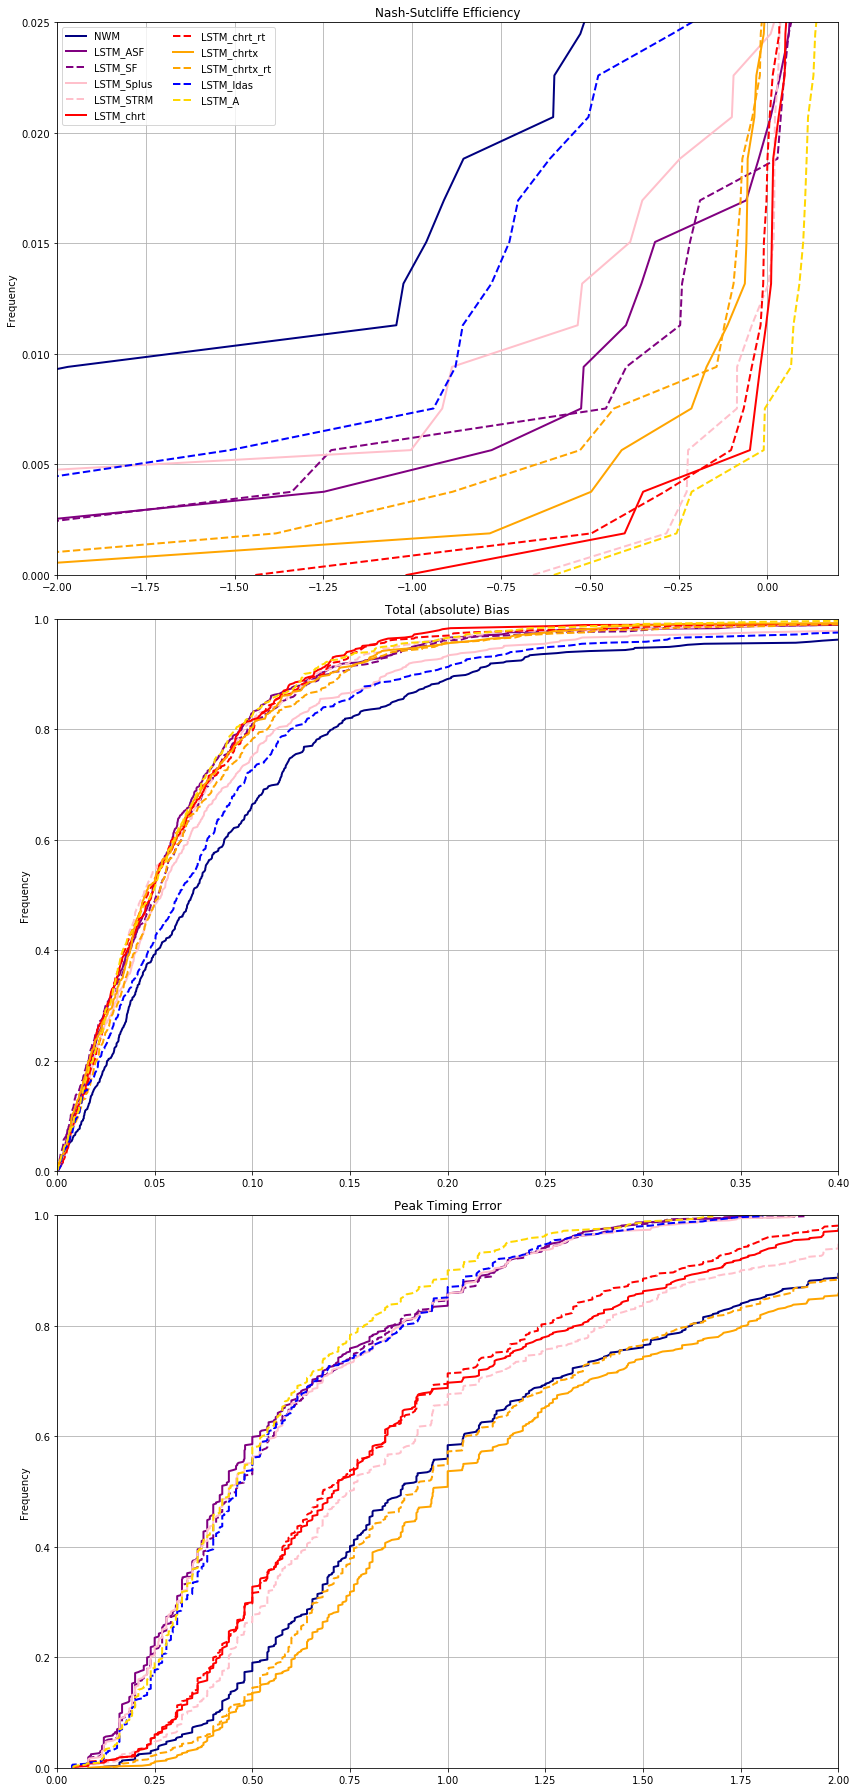

In [23]:
met_xlims = [[-2,.2], [-5,40], [-5,10], [-1,1], [0,2], [0,1], [0,.4],[-50,50], [],[],[],[0,2]]
met_ylims = [[0,0.025], [],[],[],[],[],[0,1],[],[],[],[],[0,1]]
place_text = [[[0,.9], [.6,.0]], [[-.2,.2],[.1,.3]], [[0,1.7], [0,1.6]]]
yvalues = list(range(len(basin_list)))
for i, _ in enumerate(yvalues):
    yvalues[i] = yvalues[i]/len(yvalues)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
mpl.rcParams.update({'font.size': 10})
fig, axes = plt.subplots(3, figsize=(12,25))

plot_mods = ['NWM', 
             'LSTM_ASF',
             'LSTM_SF',
             'LSTM_Splus',
             'LSTM_STRM',
             'LSTM_chrt', 
             'LSTM_chrt_rt', 
             'LSTM_chrtx',
             'LSTM_chrtx_rt', 
             'LSTM_ldas',
             'LSTM_A']

linestylz=['-','-','--', '-','--', '-', '--','-','--','--', '--']
colorz = plt.cm.jet(np.linspace(0,1,len(plot_mods)))
colorz = ['navy','purple','purple','pink','pink','red', 'red', 'orange','orange', 'blue','gold']

for imet, nmet in enumerate([0,6,11]):
    met_name = mets[imet]
    x = [np.array(ensemble_metric_dictionary[i_plot_mods][:,nmet]) for i_plot_mods in plot_mods]
    # Just use absolute values for the bias, since negative values are hard to interpret
    if nmet==6:
        x = list(np.abs(x))
    for imod,X in enumerate(x):
        plotdata = X
        plotdata = np.sort(plotdata[~pd.isnull(plotdata)])
        axes[imet].plot(plotdata,  yvalues[:len(plotdata)], 
                        color=colorz[imod], 
                        linestyle=linestylz[imod],
                        linewidth=2,
                        markevery=20,
                        markersize=15)
        axes[imet].grid()
        axes[imet].set_xlim(list(met_xlims[nmet]))
        axes[imet].set_ylim(list(met_ylims[nmet]))
        axes[imet].set_title(use_metric_names[imet])
        axes[imet].set_ylabel('Frequency')


        
axes[0].legend(plot_mods, fontsize=10, ncol=2)
fig.tight_layout() 

In [24]:
# Find bad basins
for i, b in enumerate(basin_list):
    if ensemble_metric_dictionary['NWM'][i,0] < 0:
        if ensemble_metric_dictionary['LSTM_A'][i,0] < 0:
            print(b)

06409000
06847900


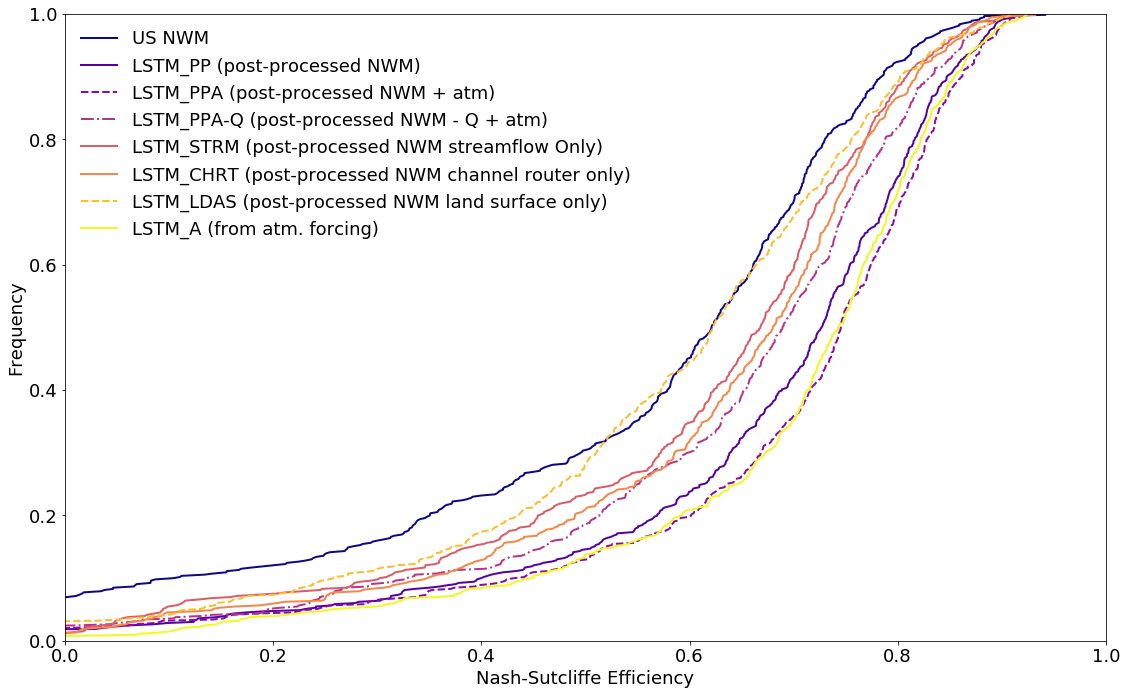

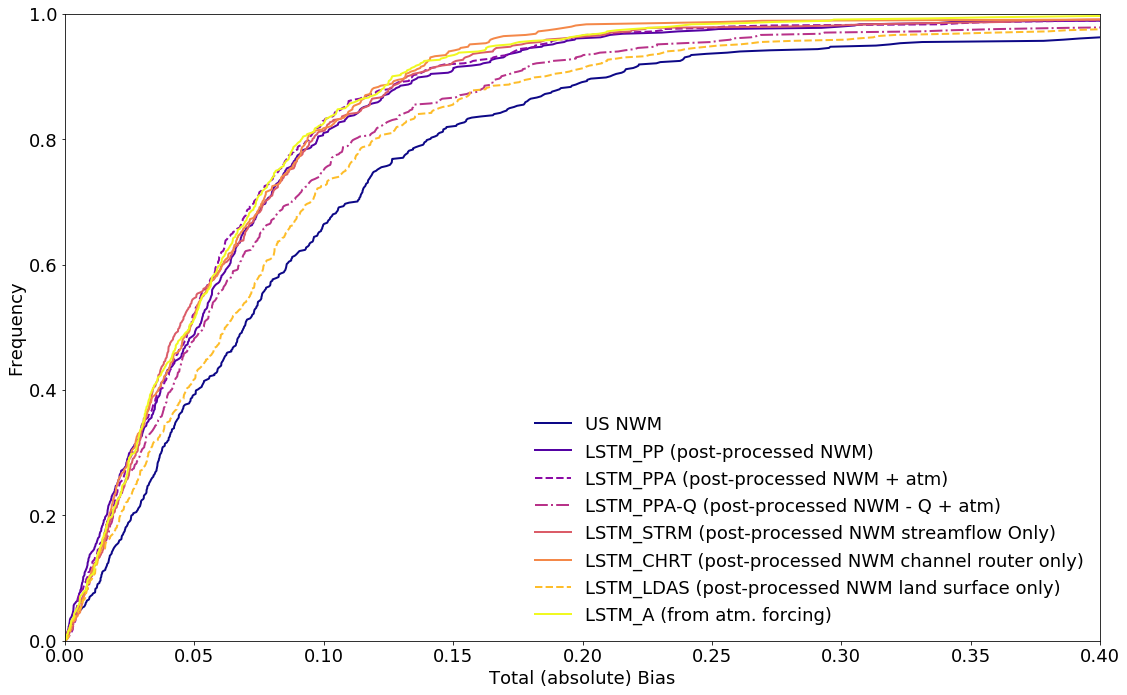

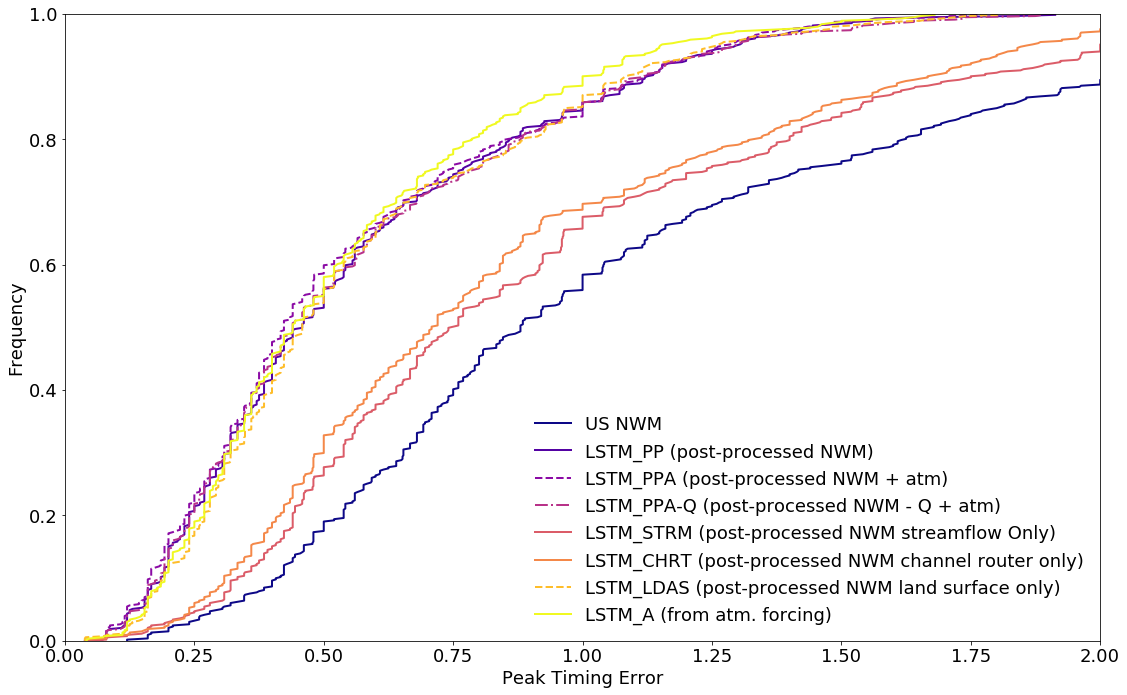

In [25]:
met_xlims = [[0,1], [-5,40], [-5,10], [-1,1], [0,2], [0,1], [0,.4],[-50,50], [],[],[],[0,2]]
met_ylims = [[0,1], [],[],[],[],[],[0,1],[],[],[],[],[0,1]]
place_text = [[[0,.9], [.6,.0]], [[-.2,.2],[.1,.3]], [[0,1.7], [0,1.6]]]
legend_loc = ['upper left', 'lower right', 'lower right']
yvalues = list(range(len(basin_list)))
for i, _ in enumerate(yvalues):
    yvalues[i] = yvalues[i]/len(yvalues)

# cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

plot_mods = ['NWM', 'LSTM_SF', 'LSTM_ASF', 'LSTM_Splus','LSTM_STRM', 'LSTM_chrt', 'LSTM_ldas', 'LSTM_A']
colorz= plt.cm.plasma(np.linspace(0,1,len(plot_mods)))
linestylz=['-','-','--', '-.','-', '-','--','-']
labelz=['US NWM', 
        'LSTM_PP (post-processed NWM)', 
        'LSTM_PPA (post-processed NWM + atm)', 
        'LSTM_PPA-Q (post-processed NWM - Q + atm)', 
        'LSTM_STRM (post-processed NWM streamflow Only)', 
        'LSTM_CHRT (post-processed NWM channel router only)',
        'LSTM_LDAS (post-processed NWM land surface only)',
        'LSTM_A (from atm. forcing)']
for imet, nmet in enumerate([0,6,11]):
    mpl.rcParams.update({'font.size': 18})
    fig, axes = plt.subplots(figsize=(16,10))
    met_name = mets[imet]
    x = [np.array(ensemble_metric_dictionary[i_plot_mods][:,nmet]) for i_plot_mods in plot_mods]
    # Just use absolute values for the bias, since negative values are hard to interpret
    if nmet==6:
        x = list(np.abs(x))
    for imod,X in enumerate(x):
        plotdata = X
        plotdata = np.sort(plotdata[~pd.isnull(plotdata)])
        axes.plot(plotdata,  yvalues[:len(plotdata)], 
                        label=labelz[imod],
                        color=colorz[imod], 
                        linestyle=linestylz[imod],
                        linewidth=2,
                        markevery=20,
                        markersize=15)
        axes.plot
        axes.grid(False)
        axes.set_xlabel(use_metric_names[imet])
        axes.set_xlim(list(met_xlims[nmet]))
        axes.set_ylim(list(met_ylims[nmet]))
        axes.set_ylabel('Frequency')
#        axes[imet].set_xlabel('NSE', fontsize=22, labelpad=20)

    # axes.spines["top"].set_visible(False)
    # axes.spines["right"].set_visible(False)
    axes.legend(loc=legend_loc[imet], fontsize=18, frameon=False)
    #axes.tick_params(axis="both", which="major", labelsize=16)
    #ax.set_ylabel('cumulative density', fontsize=22, labelpad=20)
    fig.tight_layout() 
    plt.show()
    plt.close()

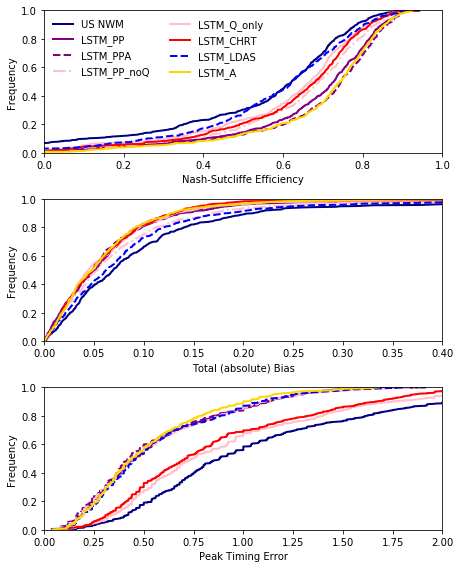

In [82]:
met_xlims = [[0,1], [-5,40], [-5,10], [-1,1], [0,2], [0,1], [0,.4],[-50,50], [],[],[],[0,2]]
met_ylims = [[0,1], [],[],[],[],[],[0,1],[],[],[],[],[0,1]]
place_text = [[[0,.9], [.6,.0]], [[-.2,.2],[.1,.3]], [[0,1.7], [0,1.6]]]
legend_loc = ['upper left', 'lower right', 'lower right']
yvalues = list(range(len(basin_list)))
for i, _ in enumerate(yvalues):
    yvalues[i] = yvalues[i]/len(yvalues)

# cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

plot_mods = ['NWM', 'LSTM_SF', 'LSTM_ASF', 'LSTM_Splus','LSTM_STRM', 'LSTM_chrt', 'LSTM_ldas', 'LSTM_A']
colorz= plt.cm.plasma(np.linspace(0,1,len(plot_mods)))
colorz = ['navy','purple','purple','pink','pink','red', 'blue','gold']
linestylz=['-','-','--', '-.','-', '-','--','-']
labelz=['US NWM', 
        'LSTM_PP', 
        'LSTM_PPA', 
        'LSTM_PP_noQ', 
        'LSTM_Q_only', 
        'LSTM_CHRT',
        'LSTM_LDAS',
        'LSTM_A']

mpl.rcParams.update({'font.size': 10})
fig, axes = plt.subplots(3, figsize=(6.5,8))

for imet, nmet in enumerate([0,6,11]):

    met_name = mets[imet]
    x = [np.array(ensemble_metric_dictionary[i_plot_mods][:,nmet]) for i_plot_mods in plot_mods]
    # Just use absolute values for the bias, since negative values are hard to interpret
    if nmet==6:
        x = list(np.abs(x))
    for imod,X in enumerate(x):
        plotdata = X
        plotdata = np.sort(plotdata[~pd.isnull(plotdata)])
        axes[imet].plot(plotdata,  yvalues[:len(plotdata)], 
                        label=labelz[imod],
                        color=colorz[imod], 
                        linestyle=linestylz[imod],
                        linewidth=2,
                        markevery=20,
                        markersize=15)
        axes[imet].plot
        axes[imet].grid(False)
        axes[imet].set_xlabel(use_metric_names[imet])
        axes[imet].set_xlim(list(met_xlims[nmet]))
        axes[imet].set_ylim(list(met_ylims[nmet]))
        axes[imet].set_ylabel('Frequency')
#        axes[imet].set_xlabel('NSE', fontsize=22, labelpad=20)

# axes.spines["top"].set_visible(False)
# axes.spines["right"].set_visible(False)
axes[0].legend(loc='upper left', ncol=2, fontsize=10, frameon=False)
#axes.tick_params(axis="both", which="major", labelsize=16)
#ax.set_ylabel('cumulative density', fontsize=22, labelpad=20)
fig.tight_layout() 
plt.show()
fig.savefig('fig12.png', dpi=1200)
plt.close()

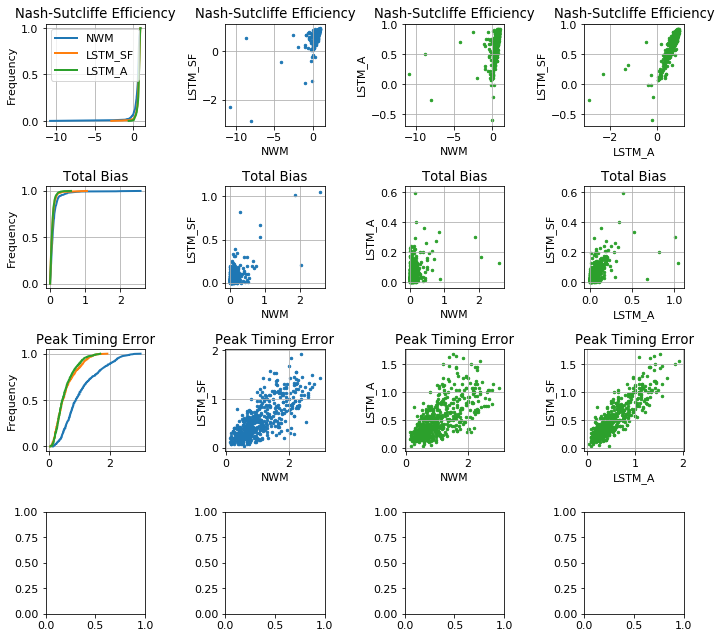

In [26]:
# met_lims = [[0,1], [-5,40], [-5,10], [-1,1], [0,2], [0,1], [0,.4],[-50,50], [],[],[],[0,2]]
# place_text = [[[0,.9], [.6,.0]], [[-.2,.2],[.1,.3]], [[0,1.7], [0,1.6]]]
yvalues = list(range(len(basin_list)))
for i, _ in enumerate(yvalues):
    yvalues[i] = yvalues[i]/len(yvalues)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
mpl.rcParams.update({'font.size': 11})
fig, axes = plt.subplots(4,4, figsize=(10,9))

plot_mods = ['NWM', 'LSTM_SF', 'LSTM_A']
for imet, nmet in enumerate([0,6,11]):
    met_name = mets[imet]
#    x_lim_imet = met_lims[imet]
    x = [np.array(ensemble_metric_dictionary[i_plot_mods][:,nmet]) for i_plot_mods in plot_mods]
    if nmet==6:
        x = list(np.abs(x))
    for imod,X in enumerate(x):
        plotdata = X
        plotdata = np.sort(plotdata[~pd.isnull(plotdata)])
        axes[imet,0].plot(plotdata,  yvalues[:len(plotdata)], label=plot_mods[imod], lw=2)
        axes[imet,0].grid()
#        axes[imet,0].set_xlim(list(met_lims[nmet]))
        axes[imet,0].set_title(metric_names[imet])
        axes[imet,0].set_ylabel('Frequency')

    ydata = x[1]
    xdata = x[0]
#    axes[imet,1].plot(list(met_lims[imet]), list(met_lims[imet]), 'k--')
    axes[imet,1].scatter(xdata,  ydata, label=plot_mods[imod], marker='o', s=6, c=cycle[0])
    axes[imet,1].grid()
#     axes[imet,1].set_xlim(list(met_lims[nmet]))
#     axes[imet,1].set_ylim(list(met_lims[nmet]))
#     mmiinn = np.min(np.minimum(xdata, ydata))
#     mmaaxx = np.max(np.maximum(xdata, ydata))
#     axes[imet,1].set_xlim([mmiinn, mmaaxx])
#     axes[imet,1].set_ylim([mmiinn, mmaaxx])
    axes[imet,1].set_title(metric_names[imet])
    axes[imet,1].set_ylabel('LSTM_SF')
    axes[imet,1].set_xlabel('NWM')
    corr = 'r$^2$: {:.2f}'.format(st.stats.pearsonr(xdata, ydata)[0])
#    axes[imet,1].text(place_text[imet][0][0],place_text[imet][0][1],corr)

    ydata = x[2]
    xdata = x[0]
#    axes[imet,2].plot(list(met_lims[imet]), list(met_lims[imet]), 'k--')
    axes[imet,2].scatter(xdata,  ydata, label=plot_mods[imod], marker='o', s=6, c=cycle[2])
    axes[imet,2].grid()
#     axes[imet,2].set_xlim(list(met_lims[nmet]))
#     axes[imet,2].set_ylim(list(met_lims[nmet]))
#     mmiinn = np.min(np.minimum(xdata, ydata))
#     mmaaxx = np.max(np.maximum(xdata, ydata))
#     axes[imet,2].set_xlim([mmiinn, mmaaxx])
#     axes[imet,2].set_ylim([mmiinn, mmaaxx])
    axes[imet,2].set_title(metric_names[imet])
    axes[imet,2].set_ylabel('LSTM_A')
    axes[imet,2].set_xlabel('NWM')
    corr = 'r$^2$: {:.2f}'.format(st.stats.pearsonr(xdata, ydata)[0])
#    axes[imet,2].text(place_text[imet][1][0],place_text[imet][1][1],corr)

    ydata = x[2]
    xdata = x[1]
#    axes[imet,2].plot(list(met_lims[imet]), list(met_lims[imet]), 'k--')
    axes[imet,3].scatter(xdata,  ydata, label=plot_mods[imod], marker='o', s=6, c=cycle[2])
    axes[imet,3].grid()
#     axes[imet,2].set_xlim(list(met_lims[nmet]))
#     axes[imet,2].set_ylim(list(met_lims[nmet]))
#     mmiinn = np.min(np.minimum(xdata, ydata))
#     mmaaxx = np.max(np.maximum(xdata, ydata))
#     axes[imet,2].set_xlim([mmiinn, mmaaxx])
#     axes[imet,2].set_ylim([mmiinn, mmaaxx])
    axes[imet,3].set_title(metric_names[imet])
    axes[imet,3].set_ylabel('LSTM_SF')
    axes[imet,3].set_xlabel('LSTM_A')
    corr = 'r$^2$: {:.2f}'.format(st.stats.pearsonr(xdata, ydata)[0])

        
axes[0,0].legend()
fig.tight_layout() 

# Plot the change in performance on a map

In [27]:
plot_lats = []
plot_lons = []
for i, b in enumerate(basin_list):
    plot_lats.append(attributes.loc[int(b),'gauge_lat'])
    plot_lons.append(attributes.loc[int(b),'gauge_lon'])
plot_lats = np.array(plot_lats)
plot_lons = np.array(plot_lons)

In [28]:
# spatial plot of improvements
bounds = [(-0,1), (-0.2,0.1), (0,2)]
diff_bounds = [1, 0.2, 2]
optimal = [1, 0, 0]
display_colors_from_control = {'NWM':'PRGn', 'LSTM_A':'PRGn'} #Alternative color scheme: 'PuOr'
display_bounds_from_control = {'NWM':[(-0,1), (-0.2,0.1), (0,2)], 'LSTM_A':[(-0,1), (-0.2,0.1), (0,2)]}

In [29]:
def PERFORMANCE_IMPROVEMENTS(control, test, percent=False):
    improvement = np.full([len(basin_list),len(use_metrics)], np.nan)
    percent_improvement = np.full([len(basin_list),len(use_metrics)], np.nan)
    for m, metric in enumerate(use_metrics):
        imet=use_metric_locs[m]
        if optimal[m] == 1:
            improvement[:,m] = ensemble_metric_dictionary[test][:,imet] - \
                               ensemble_metric_dictionary[control][:,imet]
            percent_improvement[:,m] = improvement[:,m] / np.abs(ensemble_metric_dictionary[control][:,imet])
        elif optimal[m] == 0:
            improvement[:,m] = np.abs(ensemble_metric_dictionary[control][:,imet]) - \
                                np.abs(ensemble_metric_dictionary[test][:,imet])
            percent_improvement[:,m] = improvement[:,m] / np.abs(ensemble_metric_dictionary[control][:,imet])
    if percent:
        return percent_improvement
    else:
        return improvement

In [30]:
# Correlation grid
models_to_do_corr = nwm_lstm_version_list
for imet, nmet in enumerate(use_metric_locs):
    print(use_metrics[imet])
    corrs = pd.DataFrame(index=models_to_do_corr, columns=models_to_do_corr)
    for i, imod in enumerate(models_to_do_corr):
        for j, jmod in enumerate(models_to_do_corr):
            corrs.iloc[i,j] = CALCULATE_CORRELATION(imod, jmod, use_metrics=[nmet])[0]
    print(corrs)

NSE
                    NWM    LSTM_A   LSTM_Ac  LSTM_ASF   LSTM_SF    LSTM_S  \
NWM                   1  0.406531  0.669919  0.710596   0.70057  0.360566   
LSTM_A         0.406531         1  0.750612  0.782916  0.763352  0.497187   
LSTM_Ac        0.669919  0.750612         1    0.6698  0.656005  0.452886   
LSTM_ASF       0.710596  0.782916    0.6698         1  0.982861   0.65153   
LSTM_SF         0.70057  0.763352  0.656005  0.982861         1  0.717287   
LSTM_S         0.360566  0.497187  0.452886   0.65153  0.717287         1   
LSTM_ASFc      0.637254  0.269676  0.731886  0.310574   0.30144  0.194429   
LSTM_S2        0.303275  0.400095  0.381319  0.555988  0.627995  0.978713   
LSTM_STRM      0.496034  0.831509  0.680557  0.741548  0.768742  0.485031   
LSTM_Splus     0.656294    0.6551  0.593548  0.900369  0.936301  0.825042   
LSTM_chrt_rt   0.428511  0.819297  0.632729  0.733698  0.752537   0.42497   
LSTM_chrt      0.443608  0.834359  0.632203  0.742381  0.763302  0.45324

In [31]:
use_metrics

['NSE', 'Beta-NSE', 'Peak-Timing']

In [32]:
def COUNT_PERFORMANCE_IMPROVEMENTS(improvement, control, test, threshold=1, verbose=True):
    for m, metric in enumerate(use_metrics):
        count_improved = 0
        count_detriment = 0
        count_total = 0
        imet=use_metric_locs[m]
        for i, ival in enumerate(improvement[:,m]):
            if ensemble_metric_dictionary['NWM'][i,0] < threshold:
                count_total += 1
                if ival > 0:
                    count_improved+= 1
                if ival < 0:
                    count_detriment+= 1
        if verbose:
            print(metric)
            print('Number of improved basins = {}, {:.2f}%'.format(count_improved, 
                                                                   count_improved/count_total))
            print('Number of detrimented basins = {}, {:.2f}%'.format(count_detriment, 
                                                                      count_detriment/count_total))
        else:
            if metric == 'NSE':
                return count_improved/count_total

In [33]:
def PLOT_PERFORMANCE_IMPROVEMENTS(improvement, control, test, percent=False):
    
    bound = display_bounds_from_control[control]
    
    fig = plt.figure(figsize=(10, 9))
    gs = fig.add_gridspec(len(use_metrics),3)

    for m, metric in enumerate(use_metrics):

        imet=use_metric_locs[m]

        ax0 = fig.add_subplot(gs[m,:2])
        im = ax0.scatter(plot_lons, plot_lats,
                        c=improvement[:,m],
                        s=20,
                        cmap=display_colors_from_control[control],
                        vmin=-diff_bounds[m], vmax=diff_bounds[m])
        ax0.set_title(use_metric_names[m])
        if m == 2:
            ax0.set_xlabel('Longitude')
        if m == 1:
            ax0.set_ylabel('Latitude')
        clims = im.get_clim()

        # colorbar
        divider = make_axes_locatable(ax0)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')

        ax1 = fig.add_subplot(gs[m,2])    
        ax1.plot(bounds[m], bounds[m], 'k--', lw=0.6)
        for b, basin in enumerate(basin_list):
            basin_color = im.to_rgba(improvement[b,m])
            ax1.scatter(ensemble_metric_dictionary[control][b,imet], 
                        ensemble_metric_dictionary[test][b,imet],
                        s=5,
                        color=im.to_rgba(improvement[b,m]))
        ax1.set_xlabel(control)
        ax1.set_ylabel(test)
        ax1.set_xlim(bounds[m])
        ax1.set_ylim(bounds[m])
        ax1.grid()

    plt.tight_layout()

NSE
Number of improved basins = 290, 0.55%
Number of detrimented basins = 241, 0.45%
Beta-NSE
Number of improved basins = 284, 0.53%
Number of detrimented basins = 247, 0.47%
Peak-Timing
Number of improved basins = 471, 0.89%
Number of detrimented basins = 42, 0.08%
NSE
Number of improved basins = 293, 0.55%
Number of detrimented basins = 238, 0.45%
Beta-NSE
Number of improved basins = 290, 0.55%
Number of detrimented basins = 241, 0.45%
Peak-Timing
Number of improved basins = 467, 0.88%
Number of detrimented basins = 48, 0.09%


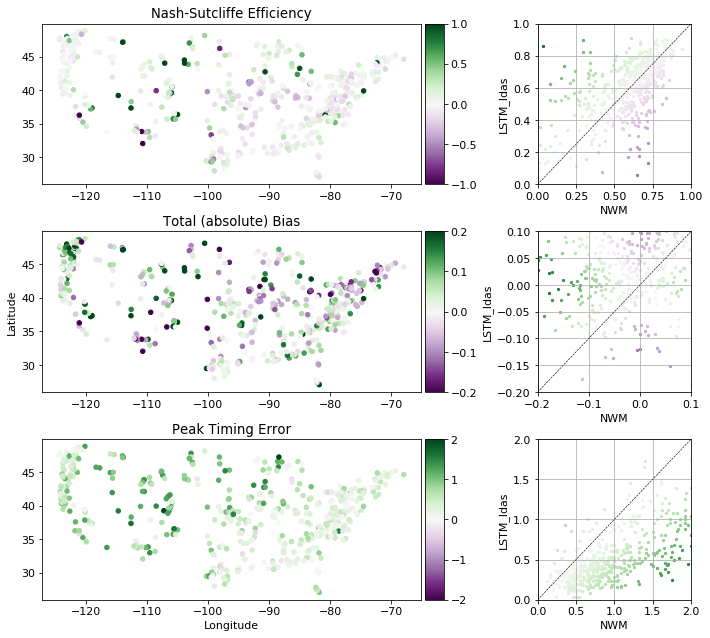

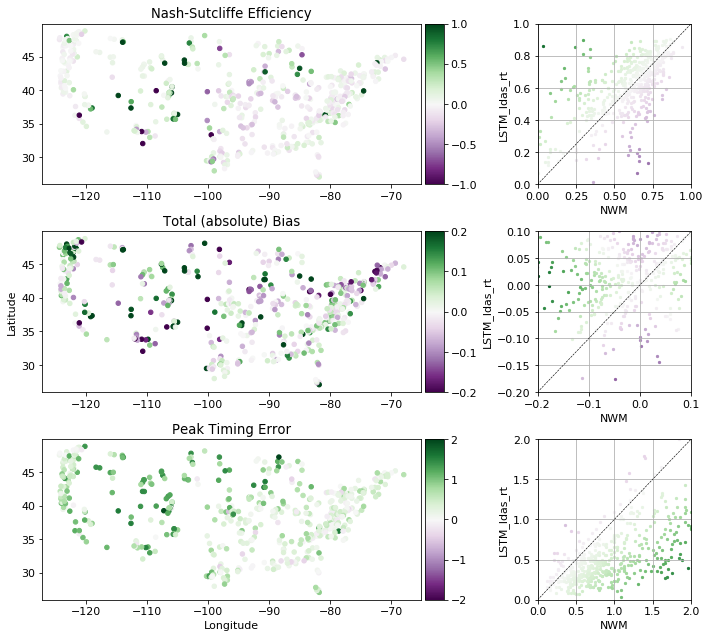

In [34]:
control='NWM'

# for test in ['LSTM_A', 
#              'LSTM_ASF',
#              'LSTM_SF', 
#              'LSTM_STRM',
#              'LSTM_chrt', 
#              'LSTM_ldas']:
for test in ['LSTM_ldas', 'LSTM_ldas_rt']:
    improvement = PERFORMANCE_IMPROVEMENTS(control, test, percent=False)
    PLOT_PERFORMANCE_IMPROVEMENTS(improvement, control, test)
    COUNT_PERFORMANCE_IMPROVEMENTS(improvement, control, test, verbose=True)

# Performance metrics for the NWM and the LSTM, LSTM Post Processor

In [35]:
# Get the days of the record that correspond to each flow type, for each basin.

if calculate_flow_categories:
    flow_dates = {fc:{b:[] for b in basin_list} for fc in flow_categories}

    for ib, b in enumerate(basin_list):  
        df = lstm_sample[b]

        for i_date, today in enumerate(date_range):
            # For a baseline also evaluate the whole record
            flow_dates['all'][b].append(today)

            # Rising and falling limbs
            if i_date>0:
                yesterday =  date_range[i_date-1]
                diff_1d = df.loc[today,'qobs']-df.loc[yesterday,'qobs']
                if diff_1d < 0:
                    flow_dates['fall'][b].append(today)
                if diff_1d > 0:
                    flow_dates['rise'][b].append(today)

            # Above or below Median
            if df.loc[today,'qobs'] > np.median(df.loc[:,'qobs']):
                flow_dates['above_mid'][b].append(today)
            else:
                flow_dates['below_mid'][b].append(today)

            # Above or below Mean
            if df.loc[today,'qobs'] > np.mean(df.loc[:,'qobs']):
                flow_dates['above_mean'][b].append(today)
            else:
                flow_dates['below_mean'][b].append(today)

            # Above or below 20th/80th percentile
            if df.loc[today,'qobs'] > np.percentile(df.loc[:,'qobs'], 80):
                flow_dates['above_80'][b].append(today)
            elif df.loc[today,'qobs'] < np.percentile(df.loc[:,'qobs'], 20):
                flow_dates['below_20'][b].append(today) 
        # Save values to pickle file
        with open(data_dir+'flow_category_dates.p','wb') as f:
            pkl.dump(flow_dates, f)
else:
    with open(data_dir+'flow_category_dates.p','rb') as f:
        flow_dates = pkl.load(f)

In [36]:
def calc_nse(obs, sim):
    diff1 = obs - sim
    diff2 = obs - np.mean(obs)
    numer = np.nanmean(np.power(diff1,2))
    denom = np.nanmean(np.power(diff2,2))
    return 1-numer/denom
def calc_bias(obs, sim):
    sum_obs = np.sum(obs)
    sum_sim = np.sum(sim)
    return sum_obs - sum_sim
def calc_beta_nse(obs, sim):
    return float((sim.mean() - obs.mean()) / obs.std())
def calc_alpha_nse(obs, sim):
    return float(sim.std() / obs.std())

In [37]:
# Get all the metrics available in one list.

if calculate_metric_matrix:

    met_mat = {fc:np.full([nbasins,n_models,nmets],np.nan) for fc in flow_categories}

    flow_mat = {fc:{mt:[] for mt in obs_nwm_lstm_version_list} for fc in flow_categories}

    did_not_calculate = []

    # Loop through the basins and calculate the performance metric.
    for ib, b in enumerate(basin_list):  
        # Keep a record of any infinities that come out of performance metric calculations.
        basin_inf = {fc:[] for fc in nwm_lstm_version_list}

        # Loop through the flow categories, and calculate the performance metrics.
        # Any flow category that is split up by percentile 
        for fc in flow_categories:
            # But some of the metrics do not make sense when the flow is split up by category
            #             i.e., the timing metrics don't make sense without consecutive days.
            if fc != flow_categories[0]:
                loop_mets = mets[0:7]
            else:
                loop_mets = mets

            flow_set = flow_dates[fc][b]

            xobs = xr.DataArray(lstm_sample[b].loc[flow_set, 'qobs']).rename({'dim_0': 'date'})
            flow_mat[fc]['obs'].extend(list(lstm_sample[b].loc[flow_set,'qobs']))

            # Do not calculate the metrics on the basins that have a mean close to zero.
            # This will lead to -inf or very low (-100xxx) Nash-Sutcliffe values.
            if np.mean(lstm_sample[b].loc[flow_set, 'qobs']) > 0:
                is_calc_metrics = True
            else:
                is_calc_metrics = False
                did_not_calculate.append([b,fc])

            # 1) combined flows from all basins into one dictionary, for overall metrics
            # 2) Calculate the metrics for each model type.
            for imt, model_type in enumerate(nwm_lstm_version_list):
                # Combine all the basins so the metrics can be calculated across them all at once.
                flow_mat[fc][model_type].extend(list(ensemble_q_dictionary[model_type][b].loc[flow_set]))
                # Now just put the curent basin's flow into an xarray to get the metrics for this basin alone.
                xsim = xr.DataArray(ensemble_q_dictionary[model_type][b].loc[flow_set]).rename({'dim_0': 'date'})
                if is_calc_metrics:
                    met_dict = metrics.calculate_metrics(xobs, xsim, loop_mets)
                    for imet, met_name in enumerate(loop_mets):
                        if np.isinf(met_dict[met_name]):
                                basin_inf[model_type].append([b, met_name])
                        met_mat[fc][ib,imt,imet] = met_dict[met_name]
                        
    with open(data_dir+'metrics_matrix_diagnostics.p','wb') as f:
            pkl.dump(met_mat, f)
    with open(data_dir+'flow_regime_matrix_diagnostics.p','wb') as f:
            pkl.dump(flow_mat, f)
else:
    with open(data_dir+'metrics_matrix_diagnostics.p','rb') as f:
        met_mat = pkl.load(f)
    with open(data_dir+'flow_regime_matrix_diagnostics.p','rb') as f:
        flow_mat = pkl.load(f)

In [38]:
combined_metric_results={fr:pd.DataFrame(index=nwm_lstm_version_list, columns=combined_metric_list) 
                         for fr in flow_categories_slim}
for fc in flow_categories_slim:
    for imodel, model_name in enumerate(nwm_lstm_version_list):
        obs = np.array(flow_mat[fc]['obs'])
        sim = np.array(flow_mat[fc][model_name])
        combined_metric_results[fc].loc[model_name,'nse']=calc_nse(obs,sim)
        combined_metric_results[fc].loc[model_name,'bias']=calc_beta_nse(obs,sim)
        combined_metric_results[fc].loc[model_name,'variance']=calc_alpha_nse(obs,sim)
        combined_metric_results[fc].loc[model_name,'pearsonr'], _ = st.pearsonr(obs,sim)
combined_metric_results

{'all':                     nse        bias  variance  pearsonr
 NWM            0.751816  -0.0184721  0.846744  0.867519
 LSTM_A         0.817737  0.00984948   0.88938  0.904467
 LSTM_Ac        0.805034   0.0122224   0.88262  0.897442
 LSTM_ASF       0.824265   0.0156675  0.925918  0.908199
 LSTM_SF        0.811488   0.0183173  0.920332  0.901215
 LSTM_S         0.743632  0.00851037  0.845505  0.862551
 LSTM_ASFc      0.809742 -0.00130417  0.883554  0.900008
 LSTM_S2        0.739816  0.00976128   0.84419  0.860332
 LSTM_STRM      0.776955   0.0071056  0.852285  0.881979
 LSTM_Splus     0.789046   0.0222409  0.910283   0.88882
 LSTM_chrt_rt   0.787157   0.0068911  0.867827  0.887463
 LSTM_chrt      0.787313  0.00724987  0.864413   0.88764
 LSTM_chrtx_rt  0.716849   0.0040348  0.823694     0.847
 LSTM_chrtx     0.714935  0.00105308  0.819425  0.845955
 LSTM_ldas_rt   0.750956   0.0253924  0.905435  0.867767
 LSTM_ldas       0.74617   0.0276119  0.896303  0.864825
 LSTM_rt        0.211232

In [39]:
# 4 = states and fluxes
# 5 = states only

pd.options.display.float_format = '{:.5f}'.format
pd.set_option('expand_frame_repr', False)
locz = [0,1,3,4,8, 11, 15]
namz = ['NWM','LSTM_A','LSTM_ASF', 'LSTM_SF','LSTM_STRM','LSTM_chrt','LSTM_ldas']
for fc in flow_categories_slim:
    print(fc)
    G = [np.nanmean(met_mat[fc][:,ilx,0]) for ilx in locz]
    H = [np.nanmedian(met_mat[fc][:,ilx,0]) for ilx in locz]
    I = [np.nanmedian(met_mat[fc][:,ilx,3]) for ilx in locz]
    J = [np.nanmedian(met_mat[fc][:,ilx,4]) for ilx in locz]
    K = [np.nanmedian(met_mat[fc][:,ilx,6]) for ilx in locz]
    L = [np.nanmedian(met_mat[fc][:,ilx,5]) for ilx in locz]
    M = [np.nanmedian(met_mat[fc][:,ilx,11]) for ilx in locz]
    df = pd.DataFrame(data=np.array([G, H, I, J, K, L, M]).reshape(7,len(locz)).transpose(),
                      index=namz,  
            columns=['NSE(mean)','NSE(median)','KGE','Alpha-NSE','Beta-NSE','Pearsonr','PeakTiming'])
    print(df)
    
def calc_wilcoxon(fc, column):
    stat0, p0 = st.wilcoxon(met_mat[fc][:,0,column], met_mat[fc][:,set_test_model,column])
    return [p0]

for set_test_model in [4,5]:
    pd.options.display.float_format = '{:.5f}'.format
    pd.set_option('expand_frame_repr', False)
    for fc in flow_categories_slim:
        print(fc)
        H = calc_wilcoxon(fc, 0)   
        I = calc_wilcoxon(fc, 3)
        J = calc_wilcoxon(fc, 4)
        K = calc_wilcoxon(fc, 6)
        L = calc_wilcoxon(fc, 5)
        M = calc_wilcoxon(fc, 11)
        df = pd.DataFrame(data=np.array([H, I, J, K, L, M]).reshape(6,1).transpose(),
                          index=['NWM'],  
                columns=['NSE','KGE','Alpha-NSE','Beta-NSE','Pearsonr','PeakTiming'])
        print(nwm_lstm_version_list[set_test_model])
        print(df)

all
           NSE(mean)  NSE(median)     KGE  Alpha-NSE  Beta-NSE  Pearsonr  PeakTiming
NWM          0.45578      0.62108 0.64431    0.82388  -0.00928   0.81508     0.88000
LSTM_A       0.68767      0.74258 0.73979    0.83477   0.02058   0.87725     0.44000
LSTM_ASF     0.67037      0.74526 0.75980    0.87112   0.02119   0.87975     0.42308
LSTM_SF      0.65171      0.72655 0.74223    0.85766   0.02378   0.86855     0.45833
LSTM_STRM    0.60138      0.66803 0.68301    0.80021   0.01615   0.83263     0.74074
LSTM_chrt    0.61808      0.67983 0.70054    0.81181   0.01584   0.84408     0.70833
LSTM_ldas    0.51793      0.62295 0.66951    0.84509   0.04256   0.81595     0.45833
rise
           NSE(mean)  NSE(median)     KGE  Alpha-NSE  Beta-NSE  Pearsonr  PeakTiming
NWM          0.47008      0.60100 0.59946    0.77427  -0.06680   0.81274         nan
LSTM_A       0.66240      0.71157 0.71971    0.80473  -0.00906   0.86278         nan
LSTM_ASF     0.65046      0.71657 0.74190    0.84704   0

/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2882: RuntimeWarning: invalid value encountered in greater
  r_plus = np.sum((d > 0) * r, axis=0)
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2883: RuntimeWarning: invalid value encountered in less
  r_minus = np.sum((d < 0) * r, axis=0)


# Calculate the hydrologic signatures for all the models and oberservation

In [40]:
# Calculate the hydrologic signatures for all the models, and see which is closer to the observation.
sigs = signatures.get_available_signatures()
nsigs = len(sigs)
sigs_dict = {imod:pd.DataFrame(index=basin_list, data=np.full([nbasins,nsigs],np.nan), columns=sigs) \
             for imod in obs_nwm_lstm_version_list}

for root, subdirs, files in os.walk(nldas_dir):
    for file in files:
        file_path = os.path.join(root, file)
        b = file[0:8]
        if b not in flow_dates['all'].keys():
            continue
        flow_set = flow_dates['all'][b]
        hu = attributes.loc[int(b), 'basin_hydro_unit']
        with open(file_path, 'r') as f:
            df = pd.read_csv(f, sep="\s+",header=3)
        dti = pd.date_range('1980-01-01', periods=df.shape[0], freq='D')
        df['date'] = dti
        df = df.set_index('date')
        prcp=xr.DataArray(df['PRCP(mm/day)'])

        for imt, model_type in enumerate(nwm_lstm_version_list):
            xsim = xr.DataArray(ensemble_q_dictionary[model_type][b].loc[flow_set]).rename({'dim_0': 'date'})
            sigs_dict[model_type].loc[b,:] = signatures.calculate_all_signatures(da=xsim, prcp=prcp)
            
        xobs = xr.DataArray(lstm_sample[b].loc[flow_set, 'qobs']).rename({'dim_0': 'date'})
        sigs_dict['obs'].loc[b,:] = signatures.calculate_all_signatures(da=xobs, prcp=prcp)

high_q_freq


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


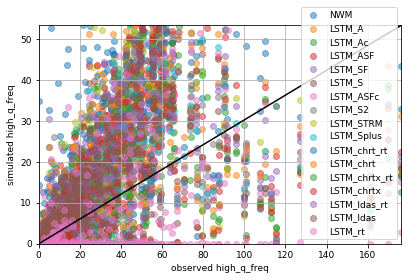

high_q_dur


/home/NearingLab/projects/jmframe/lstm_camels_NWM_post_processing_paper_july2020/tools/corrstats.py:84: RuntimeWarning: divide by zero encountered in double_scalars
  ab_z = 0.5 * np.log((1 + ab)/(1 - ab))


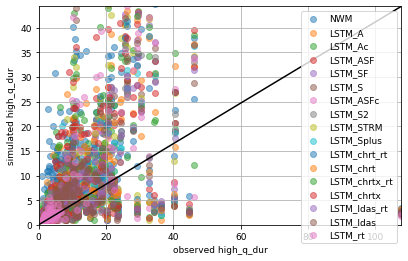

low_q_freq


/home/NearingLab/projects/jmframe/lstm_camels_NWM_post_processing_paper_july2020/tools/corrstats.py:84: RuntimeWarning: divide by zero encountered in double_scalars
  ab_z = 0.5 * np.log((1 + ab)/(1 - ab))


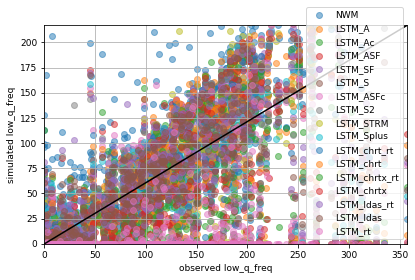

low_q_dur


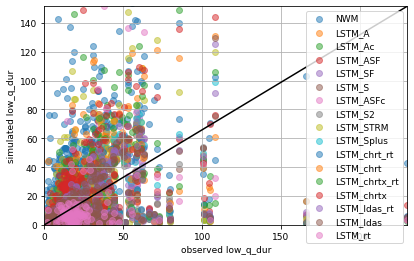

zero_q_freq


/home/NearingLab/projects/jmframe/lstm_camels_NWM_post_processing_paper_july2020/tools/corrstats.py:84: RuntimeWarning: divide by zero encountered in double_scalars
  ab_z = 0.5 * np.log((1 + ab)/(1 - ab))


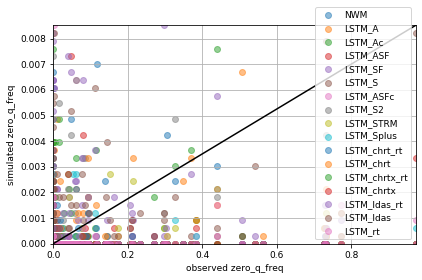

q95


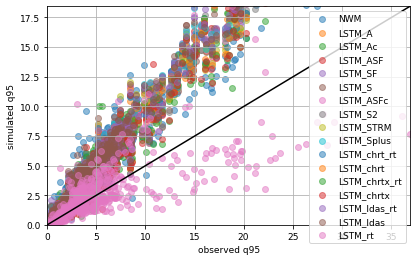

q5


/home/NearingLab/projects/jmframe/lstm_camels_NWM_post_processing_paper_july2020/tools/corrstats.py:84: RuntimeWarning: divide by zero encountered in double_scalars
  ab_z = 0.5 * np.log((1 + ab)/(1 - ab))


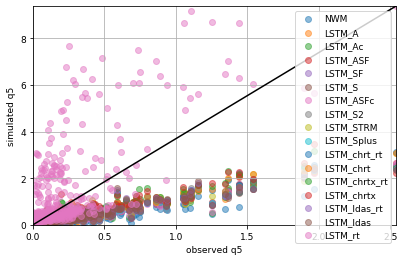

q_mean


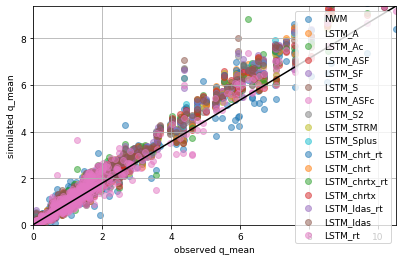

hfd_mean


/home/NearingLab/projects/jmframe/lstm_camels_NWM_post_processing_paper_july2020/tools/corrstats.py:84: RuntimeWarning: divide by zero encountered in double_scalars
  ab_z = 0.5 * np.log((1 + ab)/(1 - ab))


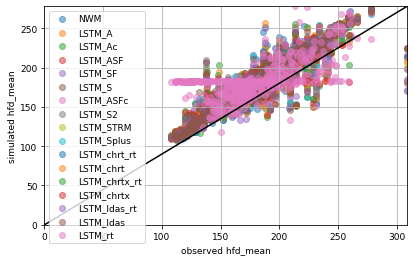

baseflow_index


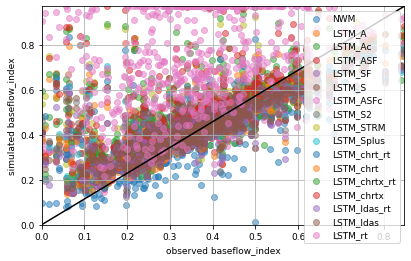

slope_fdc


/home/NearingLab/projects/jmframe/lstm_camels_NWM_post_processing_paper_july2020/tools/corrstats.py:84: RuntimeWarning: divide by zero encountered in double_scalars
  ab_z = 0.5 * np.log((1 + ab)/(1 - ab))


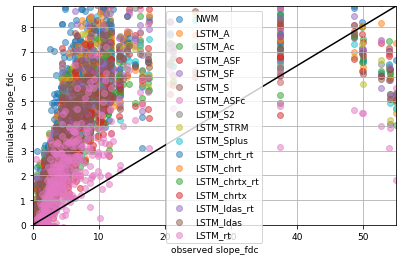

stream_elas


/home/NearingLab/projects/jmframe/lstm_camels_NWM_post_processing_paper_july2020/tools/corrstats.py:84: RuntimeWarning: divide by zero encountered in double_scalars
  ab_z = 0.5 * np.log((1 + ab)/(1 - ab))


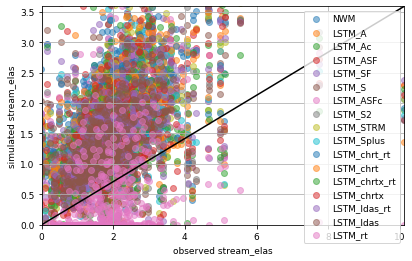

runoff_ratio


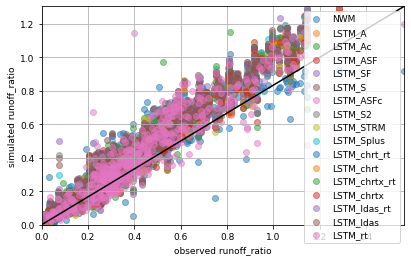

In [41]:
#RMSE Values
model_types = nwm_lstm_version_list

df_sigs={'rmse':pd.DataFrame(index=sigs_dict['obs'].columns.values, columns=model_types),
         'r-squared':pd.DataFrame(index=sigs_dict['obs'].columns.values, columns=model_types)}

df_sigs_signif = pd.DataFrame(index=sigs_dict['obs'].columns.values, columns=model_types+['n'])

for sig in sigs_dict['obs'].columns.values:
    print(sig)
    if sig=="zero_q_freq":
        df_temp = sigs_dict['obs'].loc[:,sig]
        count_zero_q_freq["obs"] = df_temp[df_temp > 0].count() 
        
    for imod in model_types:
        df_sigs['rmse'].loc[sig,imod] = np.log(np.sqrt(np.square(np.mean(sigs_dict['obs'].loc[:,sig] - 
                                         sigs_dict[imod].loc[:,sig]))))
        if sig=="zero_q_freq":
            df_temp = sigs_dict[imod].loc[:,sig]
            count_zero_q_freq[imod] = df_temp[df_temp > 0].count() 
            

    mpl.rcParams.update({'font.size': 9})
    fig, ax = plt.subplots(figsize=(6.5,4.02))
    
    for imod in model_types:
        obs_1d = np.array(sigs_dict['obs'].loc[:,sig]).reshape(sigs_dict['obs'].loc[:,sig].shape[0],)
        sigs_1d = np.array(sigs_dict[imod].loc[:,sig]).reshape(sigs_dict[imod].loc[:,sig].shape[0],)
        df = pd.DataFrame({'obs':obs_1d, 'sig':sigs_1d})
        df = df.dropna()
        slope, intercept, r_value, p_value, std_err = st.linregress(df['obs'], df['sig'])

        df_sigs['r-squared'].loc[sig,imod] = r_value**2
        
        #Calculates the statistic significance between two dependent correlation coefficients
        if imod == 'LSTM_SF':
            df_nanfree = pd.DataFrame({jmod:sigs_dict[jmod].loc[:,sig] for jmod in obs_nwm_lstm_version_list})
            df_nanfree = df_nanfree.replace([np.inf, -np.inf], np.nan)
            df_nanfree = df_nanfree.dropna()

            xy = st.pearsonr(df_nanfree['NWM'], df_nanfree['obs'])[0]

            for jmod in obs_nwm_lstm_version_list:
                xz = st.pearsonr(df_nanfree[jmod], df_nanfree['obs'])[0]
                yz = st.pearsonr(df_nanfree['NWM'], df_nanfree[jmod])[0]
                _, df_sigs_signif.loc[sig,jmod] = corrstats.independent_corr(xy, xz, df_nanfree.shape[0])
            
            df_sigs_signif.loc[sig,'n'] = df_nanfree.shape[0]
        
        ax.scatter(sigs_dict['obs'].loc[:,sig], sigs_dict[imod].loc[:,sig], alpha=.5, label=imod)
        plt.grid()
    
    plt.ylabel('simulated '+sig,fontname="Arial")
    plt.xlabel('observed '+sig,fontname="Arial")
    plt.plot([0,np.max(sigs_dict['obs'].loc[:,sig])],
             [0,np.max(sigs_dict[imod].loc[:,sig])], c='k')
    plt.xlim([0,np.max(sigs_dict['obs'].loc[:,sig])])
    plt.ylim([0,np.max(sigs_dict[imod].loc[:,sig])])
    plt.legend()
    plt.show()
    plt.close()

In [42]:
count_zero_q_freq

{'obs': 101,
 'NWM': 57,
 'LSTM_A': 35,
 'LSTM_Ac': 69,
 'LSTM_ASF': 29,
 'LSTM_SF': 25,
 'LSTM_S': 21,
 'LSTM_ASFc': 19,
 'LSTM_S2': 27,
 'LSTM_STRM': 21,
 'LSTM_Splus': 13,
 'LSTM_chrt_rt': 39,
 'LSTM_chrt': 37,
 'LSTM_chrtx_rt': 4,
 'LSTM_chrtx': 6,
 'LSTM_ldas_rt': 68,
 'LSTM_ldas': 61,
 'LSTM_rt': 9}

In [43]:
df_sigs_signif

NWM  LSTM_A LSTM_Ac LSTM_ASF LSTM_SF  LSTM_S LSTM_ASFc LSTM_S2 LSTM_STRM LSTM_Splus LSTM_chrt_rt LSTM_chrt LSTM_chrtx_rt LSTM_chrtx LSTM_ldas_rt LSTM_ldas LSTM_rt    n     obs
high_q_freq       1 0.29305 0.05676  0.82749 0.37300 0.03256   0.09419 0.10124   0.20364    0.06331      0.57557   0.47070       0.00885    0.01547      0.08201   0.02354 0.00000  531 0.00000
high_q_dur        1 0.16996 0.68827  0.18333 0.16268 0.22539   0.94762 0.15852   0.27955    0.14173      0.24182   0.58313       0.37070    0.46602      0.17806   0.15916 0.46845  160 0.00000
low_q_freq        1 0.07118 0.00027  0.96668 0.03258 0.00056   0.02005 0.02636   0.00000    0.00014      0.00402   0.00155       0.00000    0.00000      0.04016   0.00341 0.00000  531 0.00000
low_q_dur         1 0.22488 0.92614  0.38038 0.35781 0.21606   0.41789 0.17352   0.57065    0.10458      0.44666   0.15827       0.24622    0.17989      0.14360   0.10043 0.27721  103 0.00000
zero_q_freq       1 0.00014 0.00000  0.00000 0.00000 0.11711   0.00000 0.00041   0.00000    0.00001      0.00000   0.00000       0.00000    0.00000      0.00000   0.00007 0.00000  531 0.00000
q95               1 0.00000 0.00000  0.00000 0.00000 0.00000   0.00000 0.00000   0.00000    0.00000      0.00000   0.00000       0.00000    0.00000      0.00000   0.00000 0.00000  531 0.00000
q5                1 0.00000 0.00313  0.00000 0.00000 0.00040   0.00027 0.00007   0.00009    0.00018      0.00000   0.00000       0.07000    0.97744      0.00349   0.00719 0.00000  531 0.00000
q_mean            1 0.00000 0.00000  0.00000 0.00000 0.00000   0.00000 0.00000   0.00000    0.00000      0.00000   0.00000       0.00000    0.00000      0.00000   0.00000 0.00000  531 0.00000
hfd_mean          1 0.00004 0.00355  0.00000 0.00030 0.00139   0.00089 0.02932   0.07950    0.00433      0.01558   0.14070       0.64744    0.72691      0.06220   0.02628 0.00000  531 0.00000
baseflow_index    1 0.72149 0.03206  0.02402 0.75016 0.03926   0.75258 0.28228   0.00000    0.01345      0.00887   0.02647       0.00000    0.00000      0.36440   0.05388 0.00000  531 0.00000
slope_fdc         1 0.07658 0.05160  0.05152 0.03534 0.02869   0.01847 0.03539   0.00104    0.02799      0.20401   0.05417       0.03839    0.02391      0.01213   0.01898 0.00000  531 0.00000
stream_elas       1 0.63692 0.36285  0.38222 0.09285 0.09625   0.03056 0.04475   0.81620    0.61134      0.18786   0.23935       0.00164    0.01763      0.03087   0.03468 0.00000  531 0.00000
runoff_ratio      1 0.00000 0.00000  0.00000 0.00000 0.00000   0.00000 0.00000   0.00000    0.00000      0.00000   0.00000       0.00000    0.00000      0.00000   0.00000 0.00020  531 0.00000

In [44]:
sig='zero_q_freq'
df_nanfree = pd.DataFrame({imod:sigs_dict[imod].loc[:,sig] for imod in nwm_lstm_version_list})
df_nanfree = df_nanfree.replace([np.inf, -np.inf], np.nan)
df_nanfree = df_nanfree.dropna()
count_above_zero = {imod:0 for imod in nwm_lstm_version_list}
for i in df_nanfree.iterrows():
    for mod in nwm_lstm_version_list:
        if i[1][mod] > 0:
            count_above_zero[mod] += 1
count_above_zero

{'NWM': 57,
 'LSTM_A': 35,
 'LSTM_Ac': 69,
 'LSTM_ASF': 29,
 'LSTM_SF': 25,
 'LSTM_S': 21,
 'LSTM_ASFc': 19,
 'LSTM_S2': 27,
 'LSTM_STRM': 21,
 'LSTM_Splus': 13,
 'LSTM_chrt_rt': 39,
 'LSTM_chrt': 37,
 'LSTM_chrtx_rt': 4,
 'LSTM_chrtx': 6,
 'LSTM_ldas_rt': 68,
 'LSTM_ldas': 61,
 'LSTM_rt': 9}

In [45]:
df_sigs['r-squared'].sort_values('NWM').loc[:, nwm_lstm_version_list]

NWM  LSTM_A LSTM_Ac LSTM_ASF LSTM_SF  LSTM_S LSTM_ASFc LSTM_S2 LSTM_STRM LSTM_Splus LSTM_chrt_rt LSTM_chrt LSTM_chrtx_rt LSTM_chrtx LSTM_ldas_rt LSTM_ldas LSTM_rt
low_q_dur      0.15416 0.10477 0.08848  0.14883 0.13700 0.15108   0.10669 0.17209   0.17181    0.14400      0.13706   0.14276       0.22284    0.13522      0.16358   0.15303 0.04876
zero_q_freq    0.22281 0.07370 0.04396  0.04524 0.00354 0.15504   0.00259 0.08225   0.03593    0.05719      0.01670   0.00810       0.00006    0.00000      0.02052   0.06891 0.00004
high_q_dur     0.24113 0.38291 0.32637  0.38572 0.38289 0.34635   0.30912 0.38356   0.36770    0.37274      0.33911   0.31743       0.32957    0.32210      0.36611   0.34352 0.31270
stream_elas    0.28626 0.30852 0.32925  0.32754 0.36572 0.20978   0.38842 0.19461   0.29720    0.26249      0.34853   0.34188       0.14653    0.17876      0.18800   0.19002 0.03192
high_q_freq    0.50762 0.46121 0.42223  0.49816 0.46842 0.41146   0.43289 0.43449   0.45127    0.42445      0.48315   0.47599       0.38903    0.39824      0.42989   0.40555 0.10446
slope_fdc      0.51701 0.43846 0.43040  0.43037 0.42312 0.41927   0.41147 0.42315   0.36814    0.41882      0.46120   0.43137       0.42468    0.41599      0.40437   0.41193 0.28149
low_q_freq     0.60246 0.53012 0.44948  0.60087 0.51598 0.45817   0.50789 0.51240   0.36223    0.44220      0.48380   0.47101       0.30291    0.27418      0.51962   0.48153 0.06247
baseflow_index 0.71113 0.70029 0.64110  0.77264 0.72056 0.64400   0.70156 0.67745   0.49453    0.62936      0.62408   0.63841       0.40152    0.37191      0.68291   0.64867 0.10492
runoff_ratio   0.82127 0.95552 0.93277  0.95251 0.95275 0.92955   0.90354 0.92792   0.94852    0.94167      0.94854   0.95094       0.94018    0.94457      0.93107   0.92810 0.88288
hfd_mean       0.84806 0.90518 0.89130  0.91584 0.89981 0.89479   0.89635 0.88162   0.87566    0.89051      0.88485   0.87158       0.85576    0.84194      0.87724   0.88220 0.40669
q5             0.85500 0.92547 0.89685  0.92527 0.92160 0.90366   0.90480 0.90845   0.90781    0.90591      0.93361   0.93719       0.88222    0.85453      0.89645   0.89360 0.53123
q95            0.91019 0.98006 0.96535  0.97956 0.97813 0.96869   0.95315 0.97046   0.97426    0.97292      0.97305   0.97486       0.96060    0.96135      0.97318   0.97062 0.52261
q_mean         0.94297 0.98819 0.98005  0.98799 0.98845 0.98118   0.97494 0.98125   0.98712    0.98567      0.98598   0.98616       0.98322    0.98349      0.98211   0.97987 0.96798

In [46]:
sig_improvement_dict = {sig:{} for sig in sigs}
for row in df_sigs['r-squared'].sort_values('NWM').loc[:,nwm_lstm_version_list].iterrows():
    for jmod in nwm_lstm_version_list:
        sig_improvement_dict[sig][jmod] = {(row[1][jmod] - row[1]['NWM'])/row[1]['NWM']}
    
print(sig_improvement_dict)

{'high_q_freq': {}, 'high_q_dur': {}, 'low_q_freq': {}, 'low_q_dur': {}, 'zero_q_freq': {'NWM': {0.0}, 'LSTM_A': {0.04795720877170653}, 'LSTM_Ac': {0.03932916309998217}, 'LSTM_ASF': {0.04774950482148879}, 'LSTM_SF': {0.048234701965035875}, 'LSTM_S': {0.04052495610603199}, 'LSTM_ASFc': {0.03390846246295435}, 'LSTM_S2': {0.040596861798311096}, 'LSTM_STRM': {0.04682180469747407}, 'LSTM_Splus': {0.045287615699905956}, 'LSTM_chrt_rt': {0.045613934389872615}, 'LSTM_chrt': {0.045803164218035444}, 'LSTM_chrtx_rt': {0.042693928726743775}, 'LSTM_chrtx': {0.04297712030713234}, 'LSTM_ldas_rt': {0.04150953619406179}, 'LSTM_ldas': {0.03913921978810995}, 'LSTM_rt': {0.026526084387875987}}, 'q95': {}, 'q5': {}, 'q_mean': {}, 'hfd_mean': {}, 'baseflow_index': {}, 'slope_fdc': {}, 'stream_elas': {}, 'runoff_ratio': {}}


In [47]:
df_sigs['r-squared'].sort_values('NWM').loc[:, nwm_lstm_version_list].mean()

NWM             0.58616
LSTM_A          0.59649
LSTM_Ac         0.56905
LSTM_ASF        0.61312
LSTM_SF         0.59677
LSTM_S          0.57485
LSTM_ASFc       0.57642
LSTM_S2         0.58075
LSTM_STRM       0.55709
LSTM_Splus      0.57292
LSTM_chrt_rt    0.58613
LSTM_chrt       0.58059
LSTM_chrtx_rt   0.52609
LSTM_chrtx      0.51402
LSTM_ldas_rt    0.57193
LSTM_ldas       0.56597
LSTM_rt         0.32755
dtype: float64

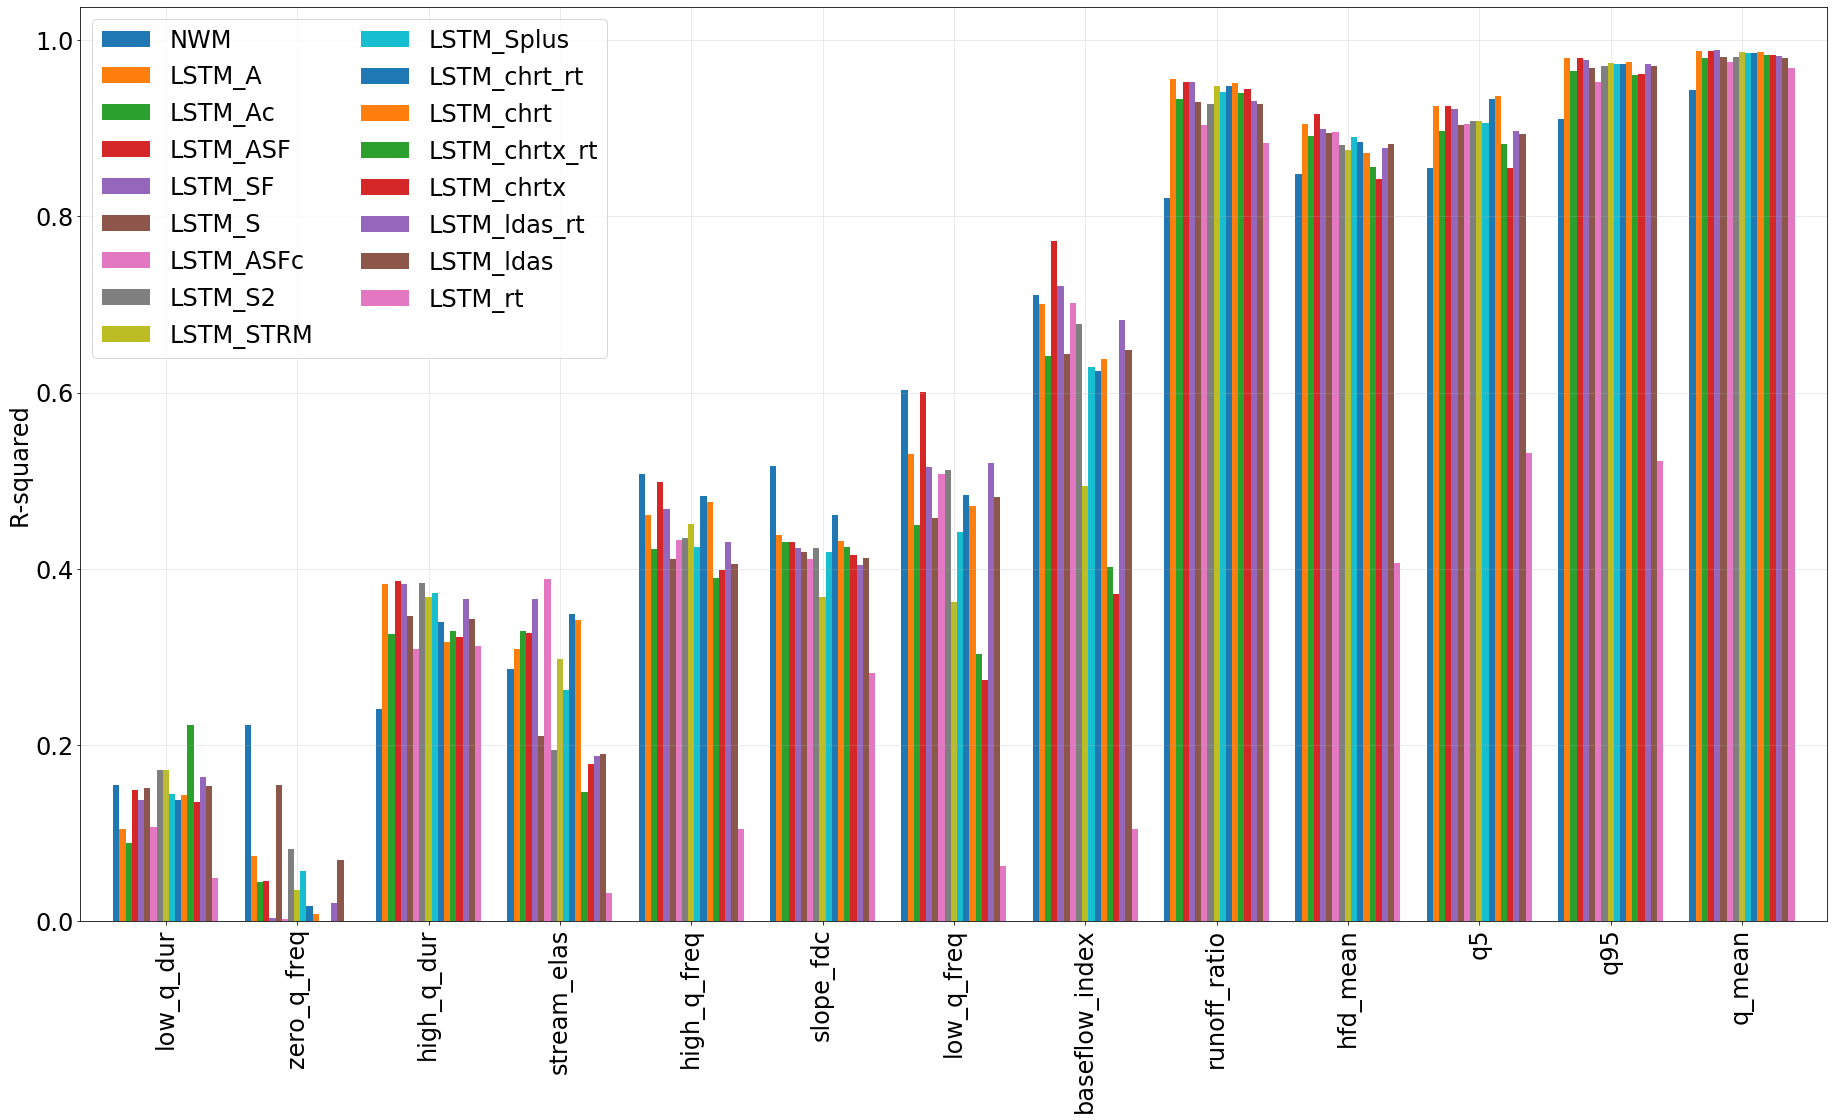

In [48]:
plot_model_names = nwm_lstm_version_list

fig_scale=4
mpl.rcParams.update({'font.size': 24})
#fig, (ax0, ax1) = plt.subplots(ncols=2, sharex=False, figsize=(fig_scale*6.5, fig_scale*4.02))
fig, ax0 = plt.subplots(figsize=(fig_scale*6.5, fig_scale*4.02))

df_plot = df_sigs['r-squared'].sort_values('NWM').loc[:,plot_model_names]

df_plot.plot.bar(ax=ax0, width=.8)

ax0.set_ylabel('R-squared')
ax0.grid(alpha=0.3)
ax0.legend(plot_model_names, fontsize=24, ncol=2)

plt.tight_layout()
plt.show()
plt.close()

# POST PROCESSOR PERFORMANCE REGRESSION

In [49]:
# Python program to sort  
# one list using 
# the other list 
def sort_list(list1, list2): 
    zipped_pairs = zip(list2, list1) 
    z = [x for _, x in sorted(zipped_pairs)] 
    return z

In [50]:
def print_stats(d):
    print("mean = {:.2f},  median = {:.2f}, stdev = {:.2f}, min = {:.2f}, max = {:.2f}".format(
        np.nanmean(np.array(d)),
        np.nanmedian(np.array(d)),
        np.nanstd(np.array(d)),
        np.nanmin(np.array(d)),
        np.nanmax(np.array(d))
        )
    )

In [51]:
# Random Forest Regression in a K-fold loop
def cross_val_rf(X,y,feature_list,kf,ynormal=False,
                 n_estimators=10,random_state=42,
                 criterion='mse', min_samples_leaf=1, min_samples_split=2, max_depth=None,
                 min_weight_fraction_leaf=0, feature_list_short=[]):

    if len(feature_list_short) > 1:
        index_labs = feature_list_short
    else:
        index_labs = feature_list
    feature_importances = pd.DataFrame(index=index_labs, columns=['total_importance'])
    for iF, F in enumerate(feature_importances.index.values):
        feature_importances.loc[F, 'total_importance'] = 0
    
    rmse_list = []
    r2_list = []
    y_hat_list = []
    y_hat_indx_list = []
    
    fig, ax = plt.subplots(figsize=(6.5,4.02))
    grid = plt.GridSpec(1, 3, wspace=0.33333)
    plt.subplot(grid[0, 0:2])
    for train_index, test_index in kf.split(X):
                
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        rf = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state,
                                  criterion=criterion, min_samples_leaf=min_samples_leaf,
                                  min_samples_split=min_samples_split, max_depth=max_depth,
                                  min_weight_fraction_leaf=min_weight_fraction_leaf)
        rf.fit(X_train, y_train);
        y_hat = rf.predict(X_test)

        # Get numerical feature importances
        importances = list(rf.feature_importances_)
        for iF, F in enumerate(feature_importances.index.values):
            feature_importances.loc[F, 'total_importance'] += importances[iF]
        
        rmse = np.sqrt(np.mean(np.power((y_test - y_hat),2)))
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_test, y_hat)
        r2 = r_value**2        
        plt.scatter(y_test,y_hat)
        
        rmse_list.append(rmse)
        r2_list.append(r2)
        y_hat_list.extend(y_hat)
        y_hat_indx_list.extend(test_index)
    
    feature_importances.loc[:, 'total_importance'] = feature_importances.loc[:, 'total_importance'] / \
                                                     kf.get_n_splits()

    #plt.title("Cross validation results with {:2d} splits".format(kf.get_n_splits()))
    plt.xlabel("true target values")
    plt.ylabel("predicted values")

    y_hat_all = sort_list(y_hat_list, y_hat_indx_list)
    
    overall_rmse = np.sqrt(np.mean(np.power((y - y_hat_all),2)))
    slope, intercept, overall_r_value, _, _ = scipy.stats.linregress(y, y_hat_all)
    overall_r2_value = overall_r_value**2
    print('Overall rmse for the out-of-sample predictions: {:.2f}'.format(overall_rmse))
    print('Overall r^2 for the out-of-sample predictions: {:.2f}'.format(overall_r_value**2))
    print("RMSE Value stats for cross validation")
    print_stats(rmse_list)
    print("R-squared Value stats for cross validation")
    print_stats(r2_list)
    x=np.linspace(np.min(y), np.max(y), num=2)
    omax = np.max([np.max(y), np.max(y_hat_all)])
    omin = np.min([np.min(y), np.min(y_hat_all)])
    plt.xlim([omin,omax])
    plt.ylim([omin,omax])
    plt.plot(x, x*slope+intercept)
    plt.grid()
    
    plt.subplot(grid[0, 2])
    feature_importances.sort_values('total_importance', ascending=False).iloc[0:5].plot.bar(ax = plt.gca())
    plt.legend([])
    plt.ylabel('feature importance')
    plt.xticks(rotation=90)
    plt.grid()

    grid.tight_layout(fig)
    plt.show()
    plt.close()    

    return y_hat_all, overall_rmse, overall_r2_value, feature_importances

In [52]:
# Set the training and targets.
def set_X_y(df, regressor_attributes, target, xnormal=False, ynormal=False, xlog=False, ylog=False):
    X=np.array(df.loc[:,regressor_attributes])
    y=np.array(df[target])
    X_krig=np.array(df.loc[:,['gauge_lat', 'gauge_lon']])

    if ynormal:
        y_mean = np.nanmean(y)
        y_std = np.nanstd(y)
        y = (y-y_mean)/y_std
    
    if xnormal:
        for i, r in enumerate(regressor_attributes):
            iX = np.array(df.loc[:,r])
            X_mean = np.nanmean(iX)
            X_std = np.nanstd(iX)
            X[:,i] = (iX - X_mean) / X_std
    
    if xlog:
        for i, r in enumerate(regressor_attributes):
            for iX in range(X.shape[0]):
                if np.abs(np.log(np.array(df.iloc[iX,i]))) > 0:
                    X[iX] = np.log(np.array(df.iloc[iX,i]))
    if ylog:
        for iy in range(y.shape[0]):
            if np.abs(np.log(y[iy])) > 0:
                y[iy] = np.log(y[iy])
        
    return X, y

LSTM_A-NWM


/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Overall rmse for the out-of-sample predictions: 0.40
Overall r^2 for the out-of-sample predictions: 0.91
RMSE Value stats for cross validation
mean = 0.35,  median = 0.32, stdev = 0.18, min = 0.15, max = 0.59
R-squared Value stats for cross validation
mean = 0.90,  median = 0.93, stdev = 0.05, min = 0.83, max = 0.94


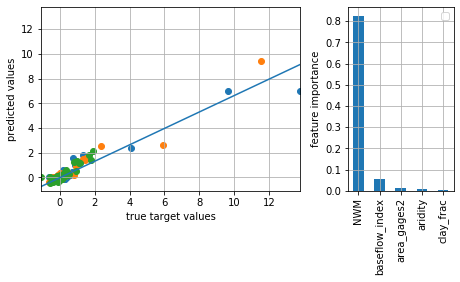

LSTM_Ac-NWM


/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Overall rmse for the out-of-sample predictions: 0.56
Overall r^2 for the out-of-sample predictions: 0.70
RMSE Value stats for cross validation
mean = 0.51,  median = 0.35, stdev = 0.25, min = 0.32, max = 0.86
R-squared Value stats for cross validation
mean = 0.85,  median = 0.84, stdev = 0.02, min = 0.82, max = 0.88


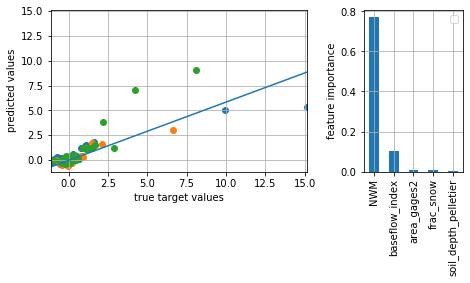

LSTM_ASF-NWM


/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Overall rmse for the out-of-sample predictions: 0.46
Overall r^2 for the out-of-sample predictions: 0.83
RMSE Value stats for cross validation
mean = 0.44,  median = 0.54, stdev = 0.16, min = 0.21, max = 0.56
R-squared Value stats for cross validation
mean = 0.85,  median = 0.84, stdev = 0.05, min = 0.79, max = 0.91


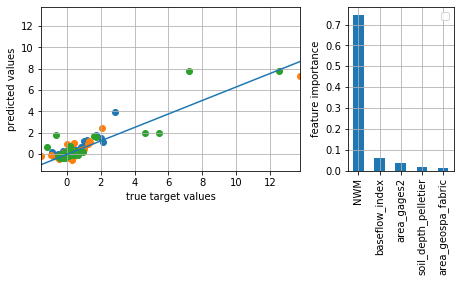

LSTM_SF-NWM


/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Overall rmse for the out-of-sample predictions: 0.44
Overall r^2 for the out-of-sample predictions: 0.83
RMSE Value stats for cross validation
mean = 0.42,  median = 0.41, stdev = 0.14, min = 0.25, max = 0.60
R-squared Value stats for cross validation
mean = 0.80,  median = 0.78, stdev = 0.10, min = 0.69, max = 0.94


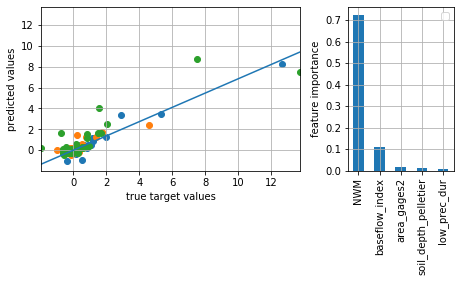

LSTM_S-NWM


/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Overall rmse for the out-of-sample predictions: 0.88
Overall r^2 for the out-of-sample predictions: 0.25
RMSE Value stats for cross validation
mean = 0.87,  median = 0.97, stdev = 0.16, min = 0.64, max = 1.00
R-squared Value stats for cross validation
mean = 0.33,  median = 0.40, stdev = 0.16, min = 0.12, max = 0.49


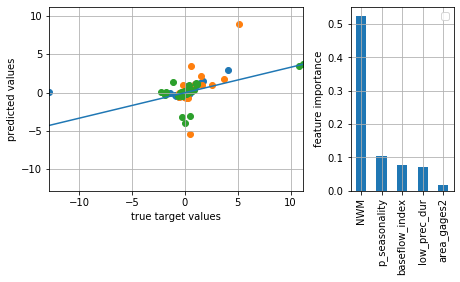

LSTM_ASFc-NWM


/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Overall rmse for the out-of-sample predictions: 1.31
Overall r^2 for the out-of-sample predictions: 0.23
RMSE Value stats for cross validation
mean = 1.16,  median = 1.49, stdev = 0.62, min = 0.29, max = 1.69
R-squared Value stats for cross validation
mean = 0.30,  median = 0.30, stdev = 0.03, min = 0.27, max = 0.33


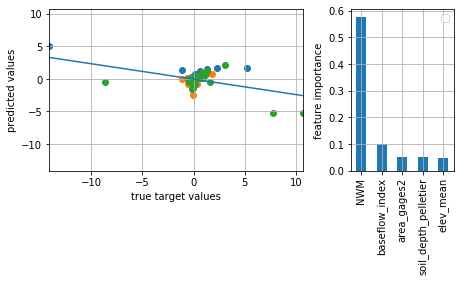

LSTM_S2-NWM


/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Overall rmse for the out-of-sample predictions: 1.06
Overall r^2 for the out-of-sample predictions: 0.09
RMSE Value stats for cross validation
mean = 1.03,  median = 0.89, stdev = 0.26, min = 0.81, max = 1.39
R-squared Value stats for cross validation
mean = 0.18,  median = 0.19, stdev = 0.01, min = 0.16, max = 0.19


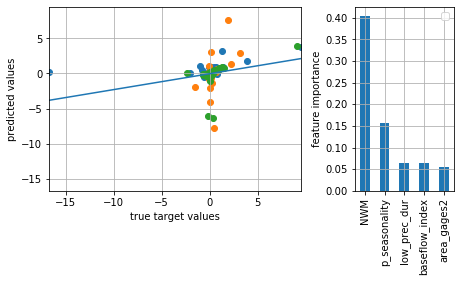

LSTM_STRM-NWM


/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Overall rmse for the out-of-sample predictions: 0.40
Overall r^2 for the out-of-sample predictions: 0.84
RMSE Value stats for cross validation
mean = 0.37,  median = 0.28, stdev = 0.17, min = 0.22, max = 0.60
R-squared Value stats for cross validation
mean = 0.87,  median = 0.91, stdev = 0.10, min = 0.73, max = 0.97


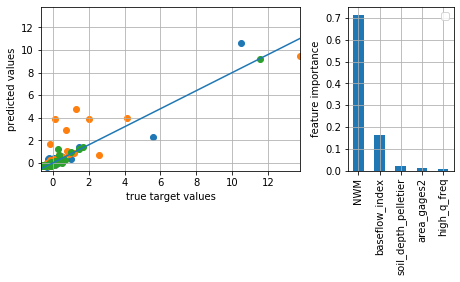

LSTM_Splus-NWM


/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Overall rmse for the out-of-sample predictions: 0.75
Overall r^2 for the out-of-sample predictions: 0.50
RMSE Value stats for cross validation
mean = 0.66,  median = 0.53, stdev = 0.35, min = 0.31, max = 1.15
R-squared Value stats for cross validation
mean = 0.52,  median = 0.52, stdev = 0.09, min = 0.41, max = 0.63


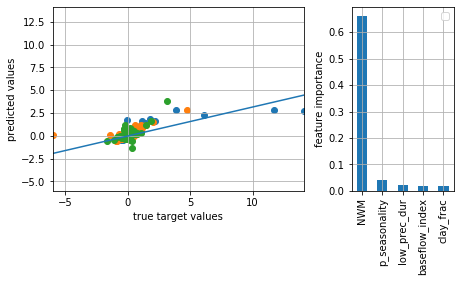

LSTM_chrt_rt-NWM


/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Overall rmse for the out-of-sample predictions: 0.39
Overall r^2 for the out-of-sample predictions: 0.88
RMSE Value stats for cross validation
mean = 0.34,  median = 0.36, stdev = 0.18, min = 0.12, max = 0.56
R-squared Value stats for cross validation
mean = 0.86,  median = 0.81, stdev = 0.07, min = 0.80, max = 0.96


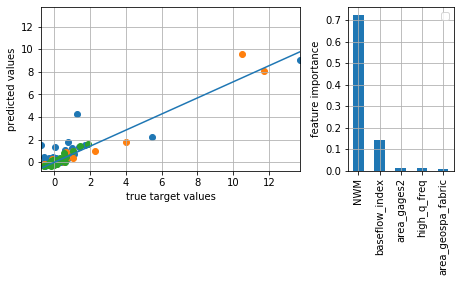

LSTM_chrt-NWM


/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Overall rmse for the out-of-sample predictions: 0.66
Overall r^2 for the out-of-sample predictions: 0.79
RMSE Value stats for cross validation
mean = 0.53,  median = 0.38, stdev = 0.40, min = 0.13, max = 1.08
R-squared Value stats for cross validation
mean = 0.73,  median = 0.68, stdev = 0.10, min = 0.63, max = 0.87


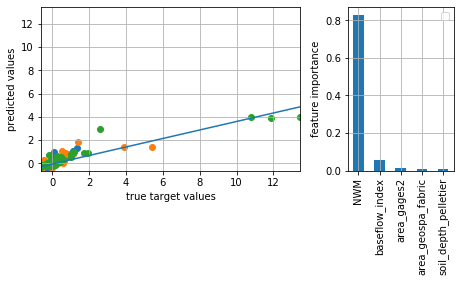

LSTM_chrtx_rt-NWM


/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Overall rmse for the out-of-sample predictions: 0.50
Overall r^2 for the out-of-sample predictions: 0.79
RMSE Value stats for cross validation
mean = 0.44,  median = 0.36, stdev = 0.24, min = 0.19, max = 0.76
R-squared Value stats for cross validation
mean = 0.75,  median = 0.81, stdev = 0.20, min = 0.48, max = 0.95


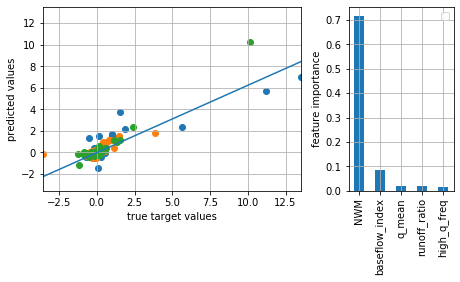

LSTM_chrtx-NWM


/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Overall rmse for the out-of-sample predictions: 0.44
Overall r^2 for the out-of-sample predictions: 0.81
RMSE Value stats for cross validation
mean = 0.44,  median = 0.45, stdev = 0.03, min = 0.41, max = 0.47
R-squared Value stats for cross validation
mean = 0.86,  median = 0.87, stdev = 0.06, min = 0.77, max = 0.92


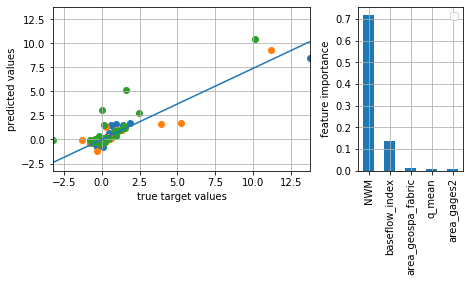

LSTM_ldas_rt-NWM


/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Overall rmse for the out-of-sample predictions: 1.10
Overall r^2 for the out-of-sample predictions: 0.05
RMSE Value stats for cross validation
mean = 1.05,  median = 0.98, stdev = 0.32, min = 0.70, max = 1.47
R-squared Value stats for cross validation
mean = 0.15,  median = 0.15, stdev = 0.12, min = 0.00, max = 0.29


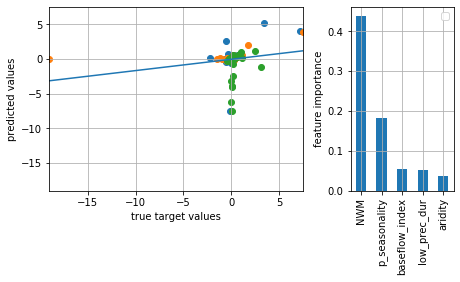

LSTM_ldas-NWM


/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Overall rmse for the out-of-sample predictions: 0.96
Overall r^2 for the out-of-sample predictions: 0.16
RMSE Value stats for cross validation
mean = 0.93,  median = 0.79, stdev = 0.24, min = 0.72, max = 1.26
R-squared Value stats for cross validation
mean = 0.22,  median = 0.19, stdev = 0.15, min = 0.06, max = 0.42


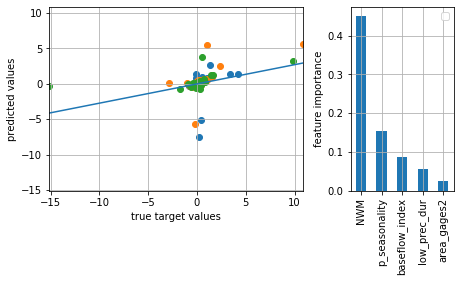

LSTM_rt-NWM


/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Overall rmse for the out-of-sample predictions: 0.45
Overall r^2 for the out-of-sample predictions: 0.85
RMSE Value stats for cross validation
mean = 0.39,  median = 0.32, stdev = 0.21, min = 0.18, max = 0.68
R-squared Value stats for cross validation
mean = 0.86,  median = 0.84, stdev = 0.04, min = 0.81, max = 0.92


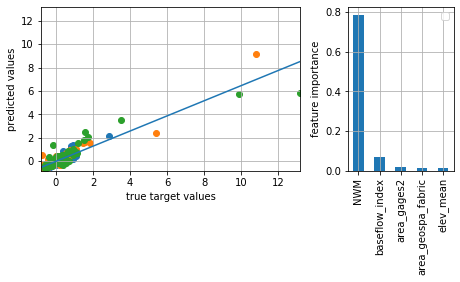

In [53]:
model2 = 'NWM'
mpl.rcParams.update({'font.size': 10})

for model1 in lstm_version_list:
    model_diff_name = str(model1)+'-'+str(model2)
    print(model_diff_name)
    attributes[model2] = [np.nan]*attributes.shape[0]
    attributes[model_diff_name] = [np.nan]*attributes.shape[0]
    imet=0
    r=0
    plot_change = np.full([nbasins,3],np.nan)
    for i, b in enumerate(basin_list):
        attributes.loc[int(b), model2] = ensemble_metric_dictionary[model2][i,imet]
        attributes.loc[int(b), model_diff_name] = ensemble_metric_dictionary[model1][i,imet] - \
                           ensemble_metric_dictionary[model2][i,imet]
    # Remove any rows with nan
    df = attributes.dropna()

    for i in range(df.shape[0]):
        df.basin_hydro_unit.iloc[i] = int(df.basin_hydro_unit.iloc[i])

    # 528 basins / 16 splits = 33 samples in each split.
    n_splits = 3 

    # Make a dictionary for all the X, y values
    X = {'X_krig':np.array(df.loc[:,['gauge_lat','gauge_lon']])}
    y = {}
    z = {}
    y_hat = {}
    Cross = {}
    regressor_attributes = list(attributes.columns.values[0:44])
    regressor_attributes.append('basin_hydro_unit')
    regressor_attributes.append('NWM')
    #regressor_attributes = ['nwm', 'baseflow_index', 'runoff_ratio', 'slope_fdc', 'stream_elas', 
    #                         'basin_hydro_unit']
    feature_list_short = ['nwm', 'B.I.', 'R.R.', 'F.D.C.', 'elast.', 'HUC']
    target=model_diff_name
    ynormal = True
    X[target], y[target] = set_X_y(df, regressor_attributes, target, xnormal=True, ynormal=ynormal)

    kf = KFold(n_splits=n_splits, shuffle=True)
    y_hat[target], rmse, r2, feature_importance = cross_val_rf(X[target],y[target],regressor_attributes,kf,
                    ynormal=ynormal, n_estimators=1000,random_state=100,
                    criterion='mse', min_samples_leaf=1, min_samples_split=2, max_depth=None,
                    min_weight_fraction_leaf=0)

NWM-LSTM_A


/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Overall rmse for the out-of-sample predictions: 1.07
Overall r^2 for the out-of-sample predictions: 0.03
RMSE Value stats for cross validation
mean = 0.98,  median = 0.86, stdev = 0.43, min = 0.52, max = 1.56
R-squared Value stats for cross validation
mean = 0.15,  median = 0.19, stdev = 0.09, min = 0.02, max = 0.24


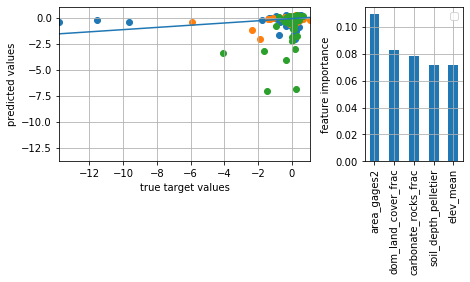

NWM-LSTM_Ac


/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Overall rmse for the out-of-sample predictions: 1.05
Overall r^2 for the out-of-sample predictions: 0.02
RMSE Value stats for cross validation
mean = 0.97,  median = 0.94, stdev = 0.40, min = 0.50, max = 1.48
R-squared Value stats for cross validation
mean = 0.07,  median = 0.01, stdev = 0.08, min = 0.01, max = 0.19


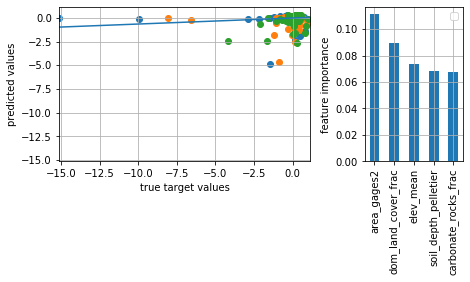

NWM-LSTM_ASF


/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Overall rmse for the out-of-sample predictions: 1.06
Overall r^2 for the out-of-sample predictions: 0.02
RMSE Value stats for cross validation
mean = 0.96,  median = 0.67, stdev = 0.45, min = 0.61, max = 1.59
R-squared Value stats for cross validation
mean = 0.06,  median = 0.06, stdev = 0.03, min = 0.03, max = 0.10


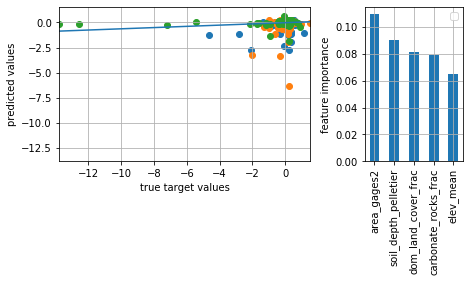

NWM-LSTM_SF


/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Overall rmse for the out-of-sample predictions: 1.11
Overall r^2 for the out-of-sample predictions: 0.01
RMSE Value stats for cross validation
mean = 1.10,  median = 1.20, stdev = 0.15, min = 0.88, max = 1.22
R-squared Value stats for cross validation
mean = 0.05,  median = 0.02, stdev = 0.06, min = 0.01, max = 0.13


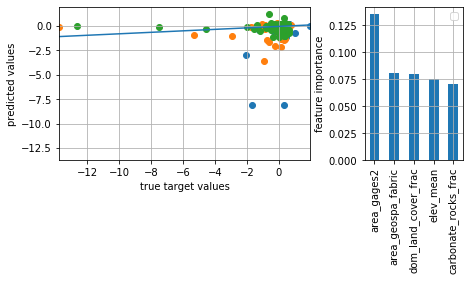

NWM-LSTM_S


/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Overall rmse for the out-of-sample predictions: 1.17
Overall r^2 for the out-of-sample predictions: 0.02
RMSE Value stats for cross validation
mean = 1.13,  median = 1.29, stdev = 0.30, min = 0.71, max = 1.39
R-squared Value stats for cross validation
mean = 0.02,  median = 0.02, stdev = 0.01, min = 0.01, max = 0.03


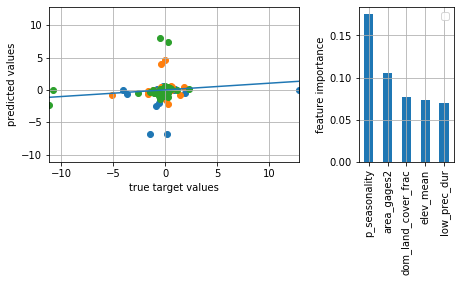

NWM-LSTM_ASFc


/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Overall rmse for the out-of-sample predictions: 1.30
Overall r^2 for the out-of-sample predictions: 0.01
RMSE Value stats for cross validation
mean = 1.22,  median = 1.47, stdev = 0.45, min = 0.59, max = 1.60
R-squared Value stats for cross validation
mean = 0.09,  median = 0.07, stdev = 0.07, min = 0.01, max = 0.18


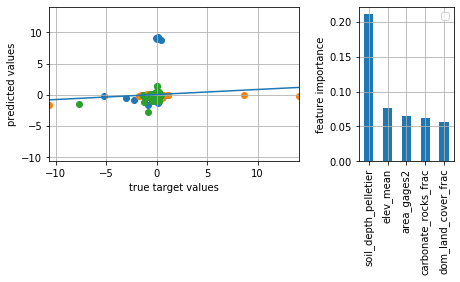

NWM-LSTM_S2


/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Overall rmse for the out-of-sample predictions: 1.09
Overall r^2 for the out-of-sample predictions: 0.01
RMSE Value stats for cross validation
mean = 0.98,  median = 0.74, stdev = 0.47, min = 0.57, max = 1.63
R-squared Value stats for cross validation
mean = 0.08,  median = 0.09, stdev = 0.06, min = 0.00, max = 0.15


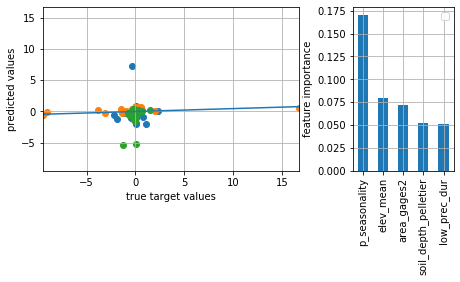

NWM-LSTM_STRM


/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Overall rmse for the out-of-sample predictions: 1.11
Overall r^2 for the out-of-sample predictions: 0.01
RMSE Value stats for cross validation
mean = 1.06,  median = 0.92, stdev = 0.35, min = 0.71, max = 1.54
R-squared Value stats for cross validation
mean = 0.02,  median = 0.03, stdev = 0.01, min = 0.00, max = 0.03


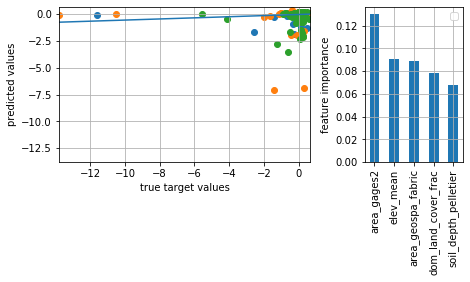

NWM-LSTM_Splus


/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Overall rmse for the out-of-sample predictions: 1.08
Overall r^2 for the out-of-sample predictions: 0.02
RMSE Value stats for cross validation
mean = 1.06,  median = 1.17, stdev = 0.21, min = 0.76, max = 1.24
R-squared Value stats for cross validation
mean = 0.05,  median = 0.02, stdev = 0.05, min = 0.01, max = 0.12


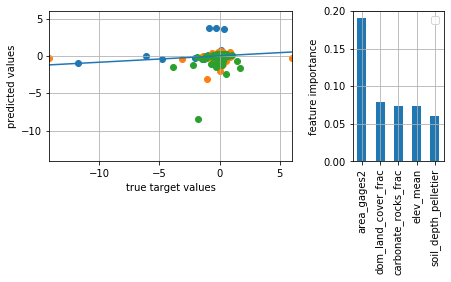

NWM-LSTM_chrt_rt


/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Overall rmse for the out-of-sample predictions: 1.00
Overall r^2 for the out-of-sample predictions: 0.04
RMSE Value stats for cross validation
mean = 0.93,  median = 1.15, stdev = 0.35, min = 0.44, max = 1.21
R-squared Value stats for cross validation
mean = 0.06,  median = 0.05, stdev = 0.02, min = 0.04, max = 0.09


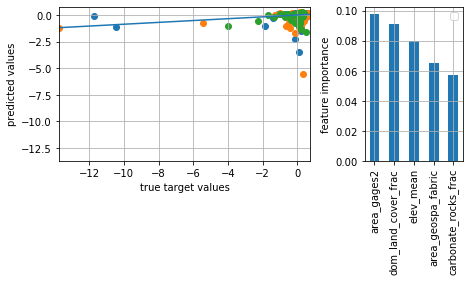

NWM-LSTM_chrt


/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Overall rmse for the out-of-sample predictions: 1.07
Overall r^2 for the out-of-sample predictions: 0.02
RMSE Value stats for cross validation
mean = 1.01,  median = 1.07, stdev = 0.35, min = 0.56, max = 1.40
R-squared Value stats for cross validation
mean = 0.06,  median = 0.01, stdev = 0.08, min = 0.01, max = 0.17


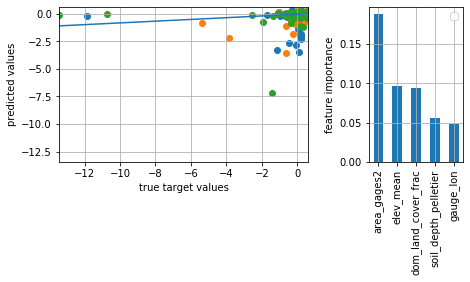

NWM-LSTM_chrtx_rt


/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Overall rmse for the out-of-sample predictions: 1.12
Overall r^2 for the out-of-sample predictions: 0.01
RMSE Value stats for cross validation
mean = 1.12,  median = 1.13, stdev = 0.08, min = 1.01, max = 1.21
R-squared Value stats for cross validation
mean = 0.03,  median = 0.01, stdev = 0.03, min = 0.01, max = 0.07


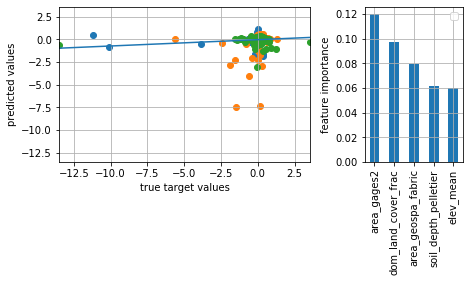

NWM-LSTM_chrtx


/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Overall rmse for the out-of-sample predictions: 1.10
Overall r^2 for the out-of-sample predictions: 0.01
RMSE Value stats for cross validation
mean = 1.05,  median = 1.10, stdev = 0.33, min = 0.63, max = 1.42
R-squared Value stats for cross validation
mean = 0.04,  median = 0.03, stdev = 0.03, min = 0.00, max = 0.08


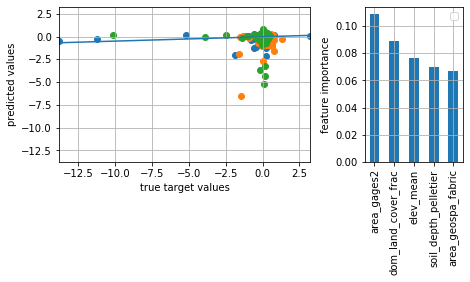

NWM-LSTM_ldas_rt


/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Overall rmse for the out-of-sample predictions: 1.36
Overall r^2 for the out-of-sample predictions: 0.00
RMSE Value stats for cross validation
mean = 1.24,  median = 1.57, stdev = 0.55, min = 0.47, max = 1.68
R-squared Value stats for cross validation
mean = 0.03,  median = 0.01, stdev = 0.03, min = 0.00, max = 0.06


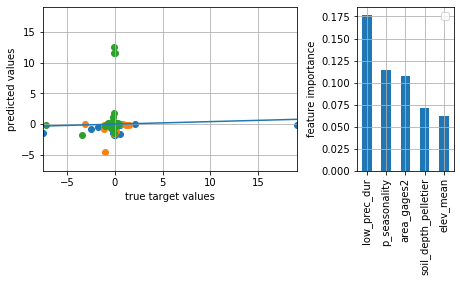

NWM-LSTM_ldas


/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Overall rmse for the out-of-sample predictions: 1.12
Overall r^2 for the out-of-sample predictions: 0.00
RMSE Value stats for cross validation
mean = 1.08,  median = 1.02, stdev = 0.28, min = 0.77, max = 1.46
R-squared Value stats for cross validation
mean = 0.00,  median = 0.00, stdev = 0.00, min = 0.00, max = 0.01


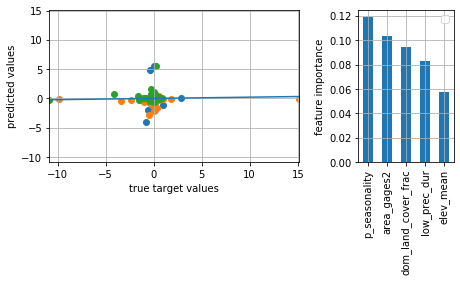

NWM-LSTM_rt


/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Overall rmse for the out-of-sample predictions: 0.95
Overall r^2 for the out-of-sample predictions: 0.12
RMSE Value stats for cross validation
mean = 0.93,  median = 0.86, stdev = 0.20, min = 0.73, max = 1.20
R-squared Value stats for cross validation
mean = 0.16,  median = 0.11, stdev = 0.07, min = 0.11, max = 0.26


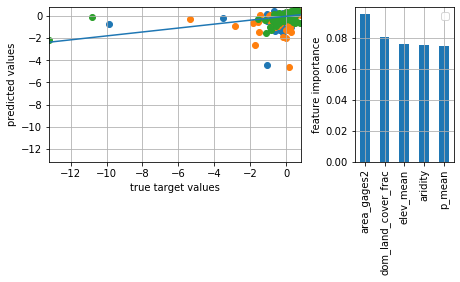

In [54]:
model1 = 'NWM'
for model2 in lstm_version_list:
    model_diff_name = str(model1)+'-'+str(model2)
    print(model_diff_name)
    attributes[model2] = [np.nan]*attributes.shape[0]
    attributes[model_diff_name] = [np.nan]*attributes.shape[0]
    imet=0
    r=0
    plot_change = np.full([nbasins,3],np.nan)
    for i, b in enumerate(basin_list):
        attributes.loc[int(b), model2] = ensemble_metric_dictionary[model2][i,imet]
        attributes.loc[int(b), model_diff_name] = ensemble_metric_dictionary[model1][i,imet] - \
                           ensemble_metric_dictionary[model2][i,imet]
    # Remove any rows with nan
    df = attributes.dropna()

    for i in range(df.shape[0]):
        df.basin_hydro_unit.iloc[i] = int(df.basin_hydro_unit.iloc[i])

    # 528 basins / 16 splits = 33 samples in each split.
    n_splits = 3

    # Make a dictionary for all the X, y values
    X = {'X_krig':np.array(df.loc[:,['gauge_lat','gauge_lon']])}
    y = {}
    z = {}
    y_hat = {}
    Cross = {}

    # Basin characteristics only. No flow signatures. Hydrologic signatures require an observation.
    regressor_attributes = list(attributes.columns.values[12:44]) 
    regressor_attributes.append('basin_hydro_unit')
    
    target=model_diff_name
    ynormal = True
    X[target], y[target] = set_X_y(df, regressor_attributes, target, xnormal=True, ynormal=ynormal)

    kf = KFold(n_splits=n_splits, shuffle=True)
    y_hat[target], rmse, r2, feature_importance = cross_val_rf(X[target],y[target],regressor_attributes,kf,
                    ynormal=ynormal, n_estimators=1000,random_state=100,
                    criterion='mse', min_samples_leaf=1, min_samples_split=2, max_depth=None,
                    min_weight_fraction_leaf=0)

In [55]:
regressor_attributes = ['geol_1st_class','glim_1st_class_frac','carbonate_rocks_frac','geol_porostiy','geol_permeability',
 'p_mean','pet_mean','p_seasonality','frac_snow','aridity','high_prec_freq','high_prec_dur','low_prec_freq',
 'low_prec_dur','low_prec_timing',
 'gauge_lat','gauge_lon','elev_mean',
 'area_gages2','area_geospa_fabric',
 'soil_depth_pelletier','soil_depth_statsgo',
 'max_water_content','sand_frac','silt_frac','clay_frac','other_frac','frac_forest',
 'lai_max','gvf_max','dom_land_cover_frac','dom_land_cover','basin_hydro_unit']

r2 = 1.0
slope = 1.0


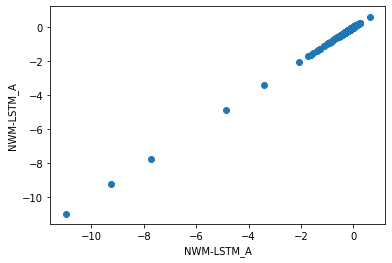

r2 = 0.96
slope = 0.86


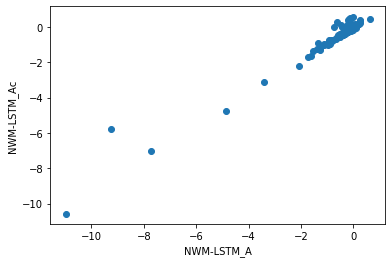

r2 = 0.95
slope = 0.82


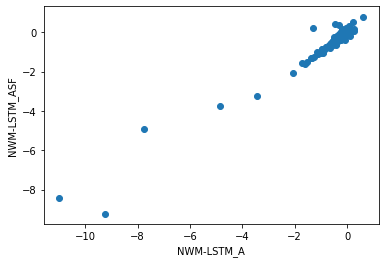

r2 = 0.95
slope = 0.82


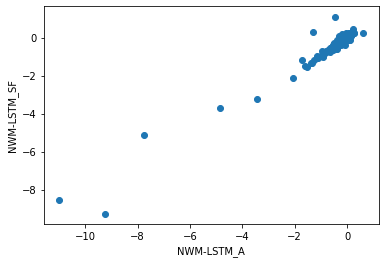

r2 = 0.61
slope = 0.84


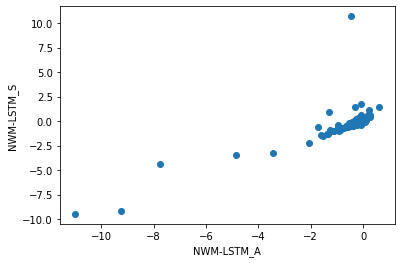

r2 = 0.07
slope = 0.27


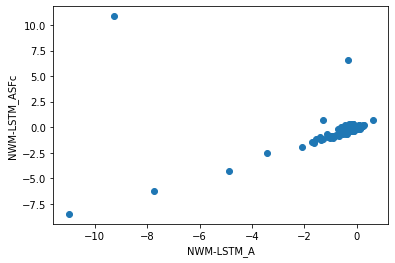

r2 = 0.38
slope = 0.8


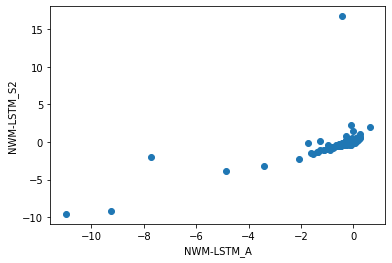

r2 = 0.98
slope = 0.95


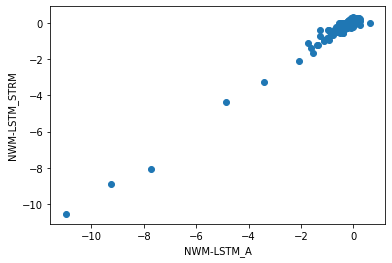

r2 = 0.81
slope = 0.74


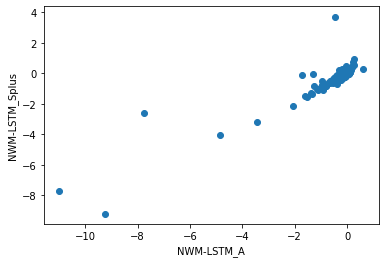

r2 = 0.97
slope = 0.97


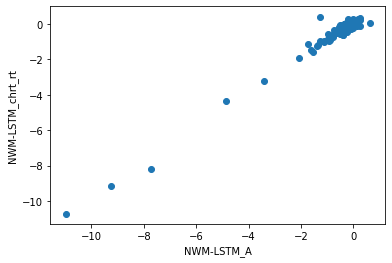

r2 = 0.98
slope = 0.97


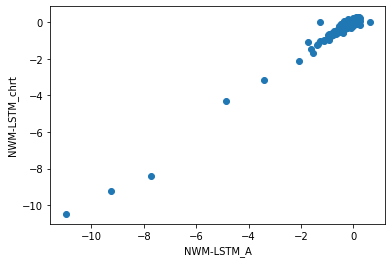

r2 = 0.94
slope = 1.0


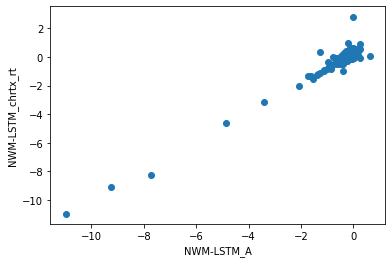

r2 = 0.95
slope = 1.01


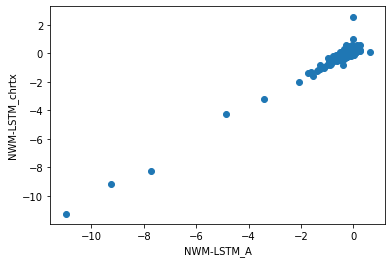

r2 = 0.26
slope = 0.83


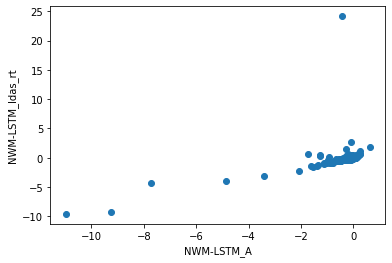

r2 = 0.44
slope = 0.78


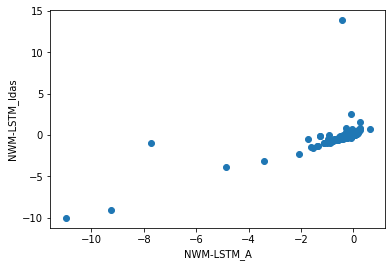

r2 = 0.92
slope = 1.02


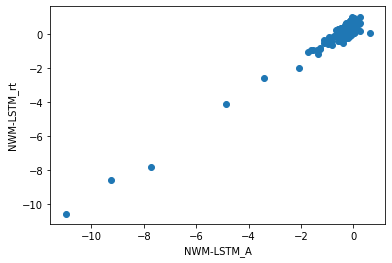

r2 = 0.96
slope = 1.11


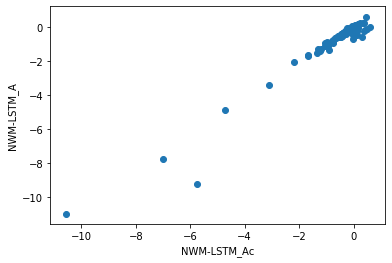

r2 = 1.0
slope = 1.0


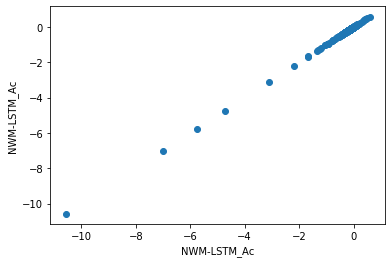

r2 = 0.88
slope = 0.89


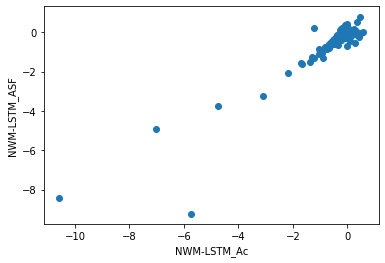

r2 = 0.88
slope = 0.9


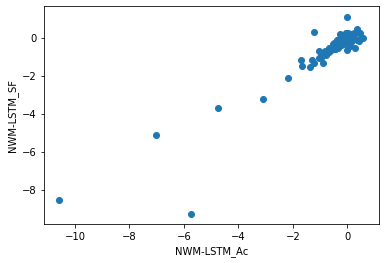

r2 = 0.58
slope = 0.94


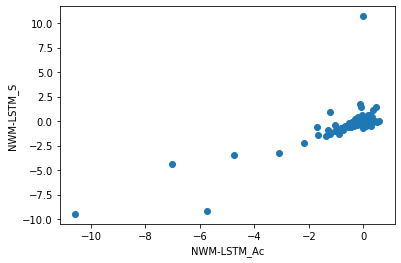

r2 = 0.17
slope = 0.47


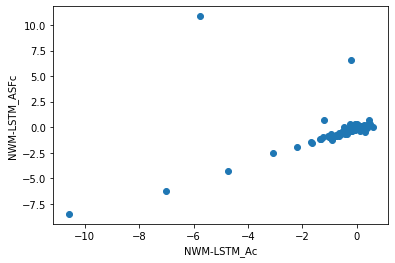

r2 = 0.37
slope = 0.89


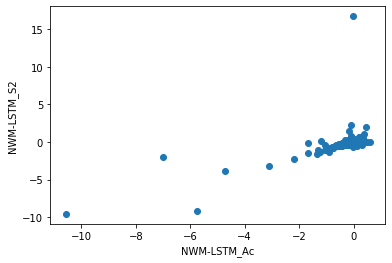

r2 = 0.93
slope = 1.06


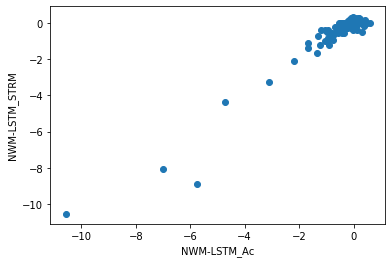

r2 = 0.74
slope = 0.81


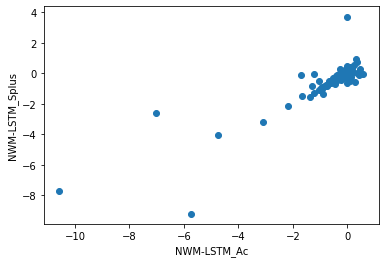

r2 = 0.92
slope = 1.08


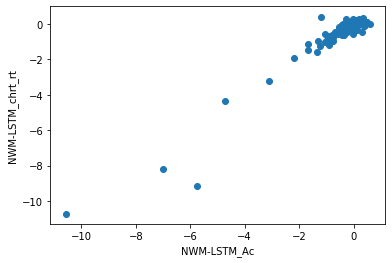

r2 = 0.93
slope = 1.08


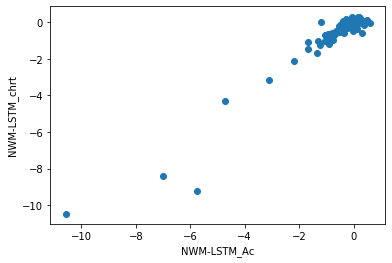

r2 = 0.9
slope = 1.12


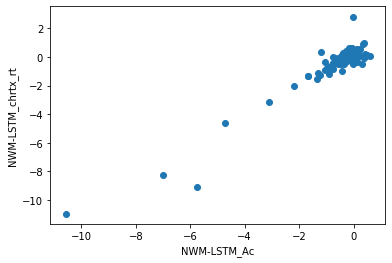

r2 = 0.91
slope = 1.13


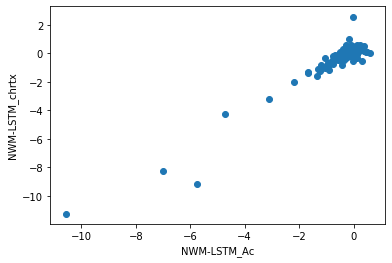

r2 = 0.26
slope = 0.95


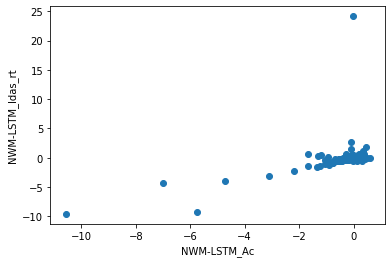

r2 = 0.42
slope = 0.87


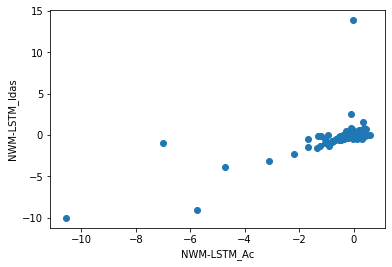

r2 = 0.89
slope = 1.14


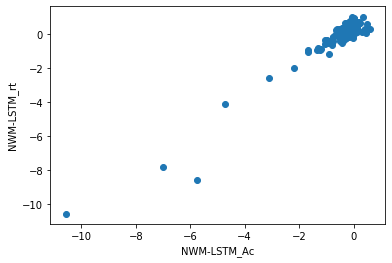

r2 = 0.95
slope = 1.16


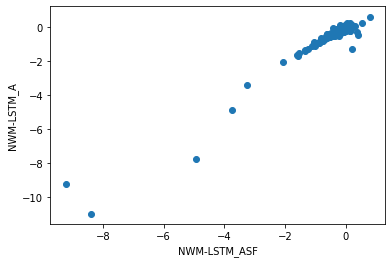

r2 = 0.88
slope = 0.98


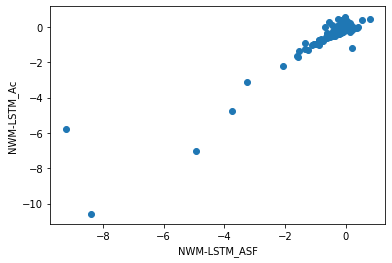

r2 = 1.0
slope = 1.0


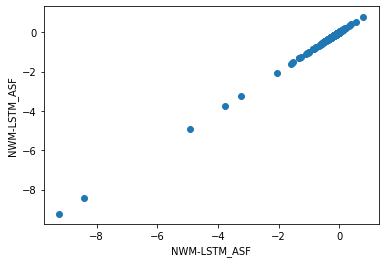

r2 = 0.99
slope = 1.01


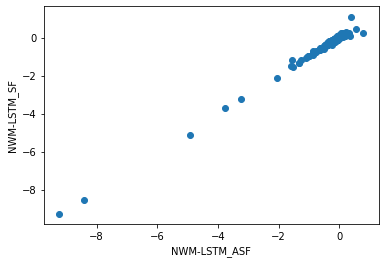

r2 = 0.69
slope = 1.07


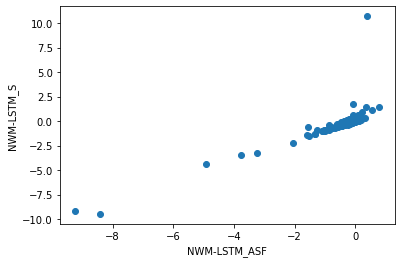

r2 = 0.03
slope = 0.21


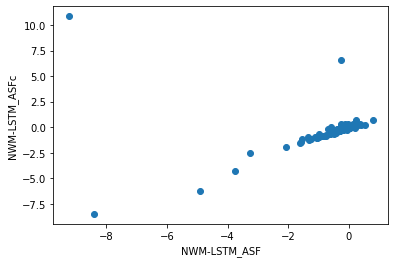

r2 = 0.46
slope = 1.05


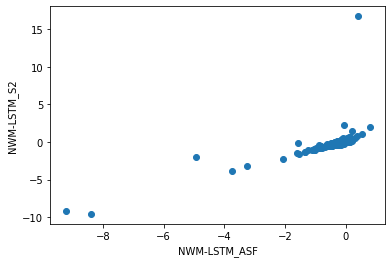

r2 = 0.93
slope = 1.11


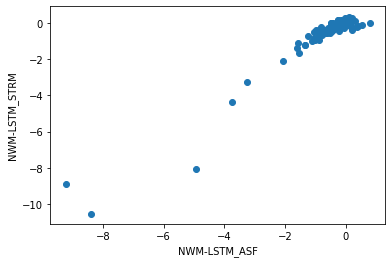

r2 = 0.9
slope = 0.93


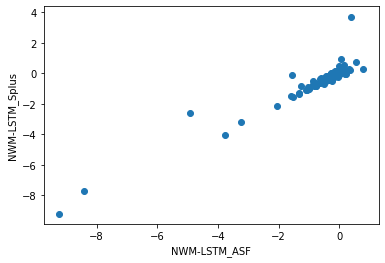

r2 = 0.94
slope = 1.14


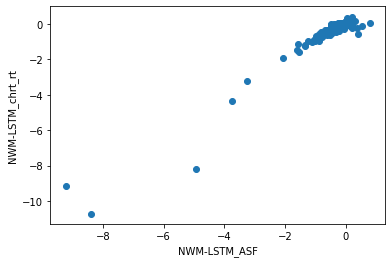

r2 = 0.94
slope = 1.14


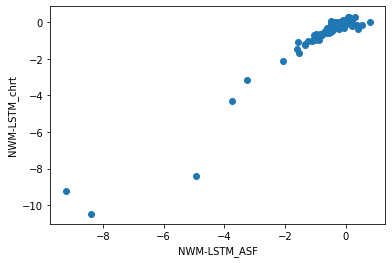

r2 = 0.9
slope = 1.17


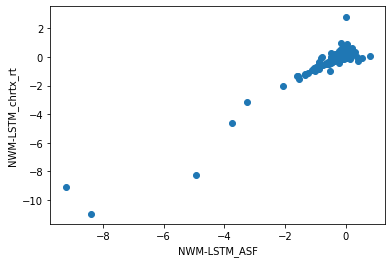

r2 = 0.9
slope = 1.18


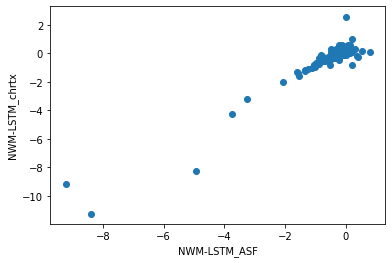

r2 = 0.32
slope = 1.1


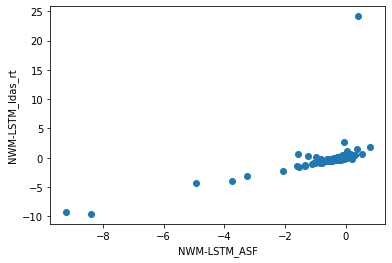

r2 = 0.52
slope = 1.02


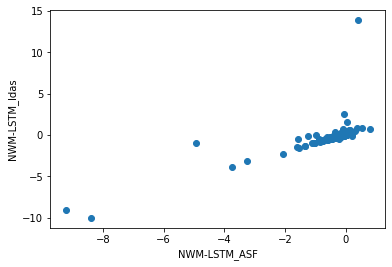

r2 = 0.87
slope = 1.18


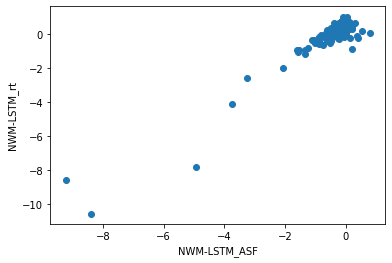

r2 = 0.95
slope = 1.15


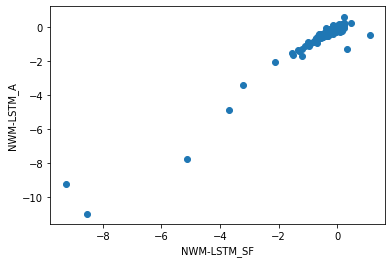

r2 = 0.88
slope = 0.97


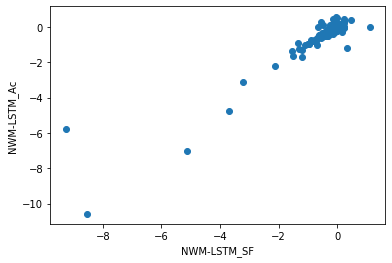

r2 = 0.99
slope = 0.99


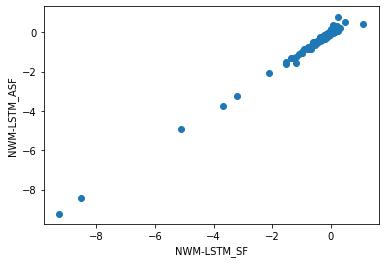

r2 = 1.0
slope = 1.0


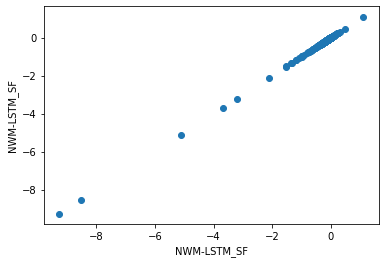

r2 = 0.73
slope = 1.08


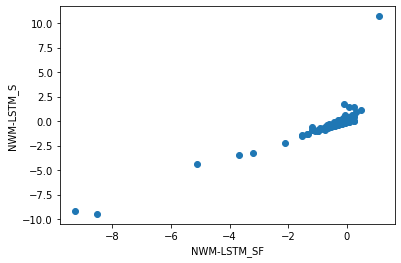

r2 = 0.03
slope = 0.21


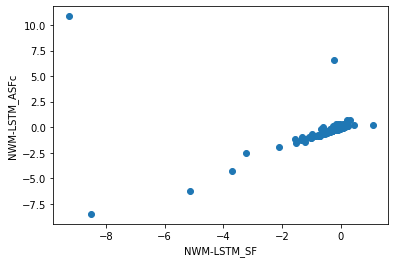

r2 = 0.5
slope = 1.08


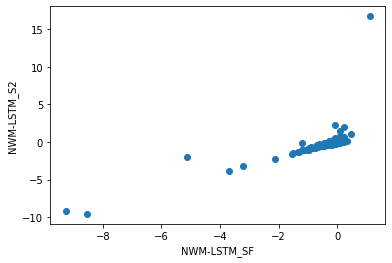

r2 = 0.94
slope = 1.11


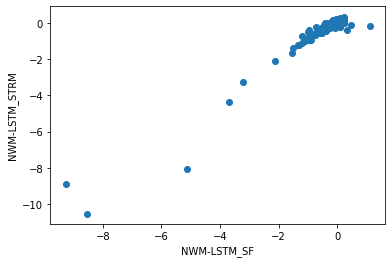

r2 = 0.92
slope = 0.94


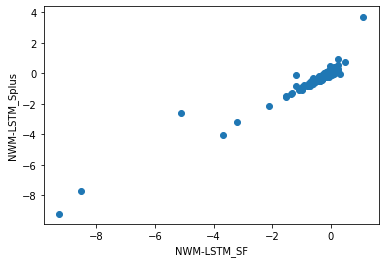

r2 = 0.94
slope = 1.13


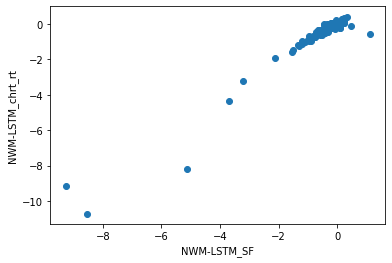

r2 = 0.94
slope = 1.13


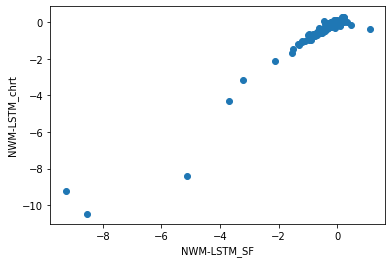

r2 = 0.9
slope = 1.16


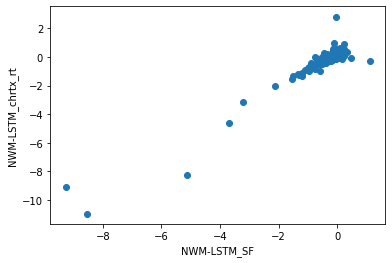

r2 = 0.91
slope = 1.17


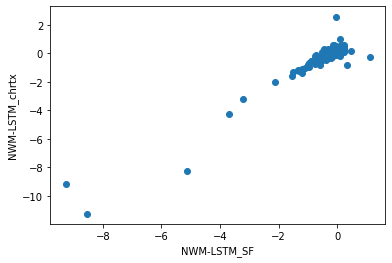

r2 = 0.36
slope = 1.16


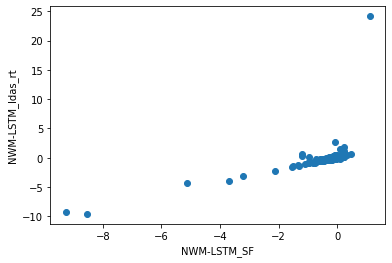

r2 = 0.56
slope = 1.04


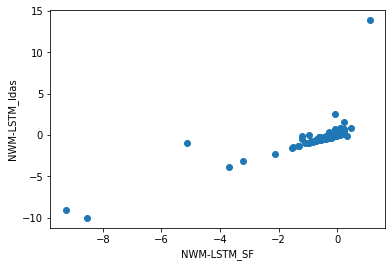

r2 = 0.87
slope = 1.17


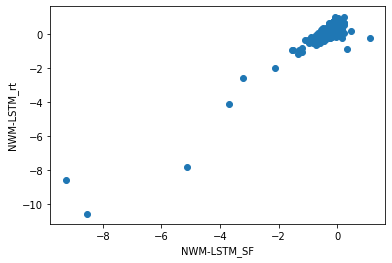

r2 = 0.61
slope = 0.72


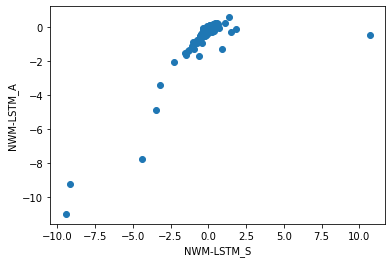

r2 = 0.58
slope = 0.62


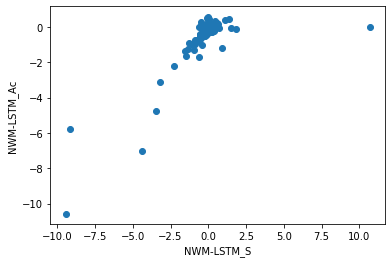

r2 = 0.69
slope = 0.65


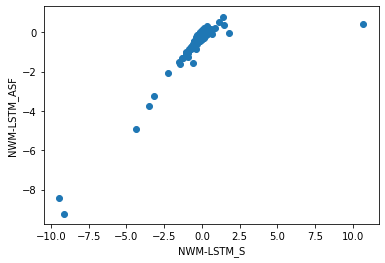

r2 = 0.73
slope = 0.67


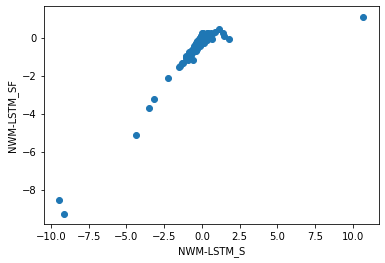

r2 = 1.0
slope = 1.0


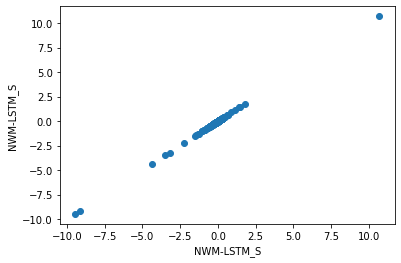

r2 = 0.03
slope = 0.16


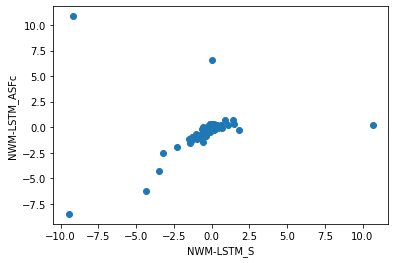

r2 = 0.93
slope = 1.15


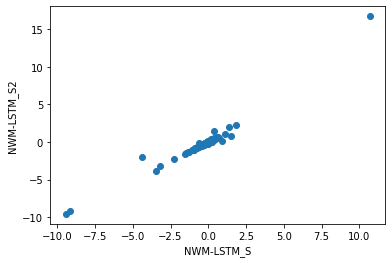

r2 = 0.6
slope = 0.7


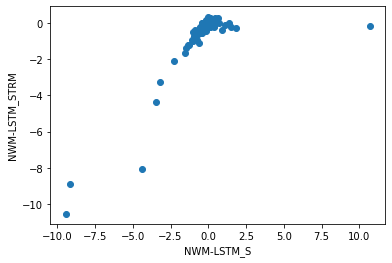

r2 = 0.85
slope = 0.71


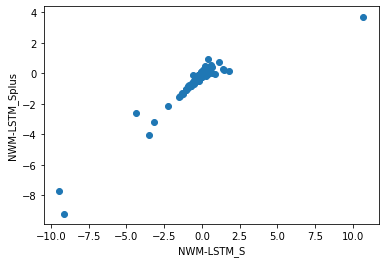

r2 = 0.59
slope = 0.7


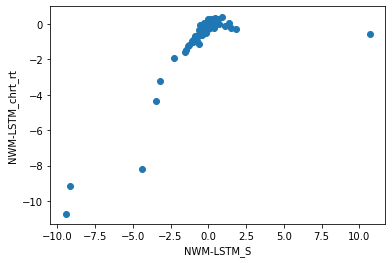

r2 = 0.6
slope = 0.71


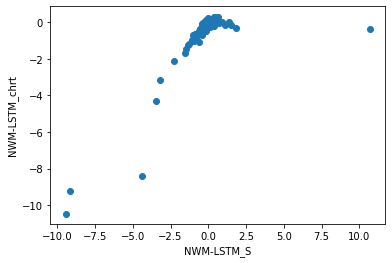

r2 = 0.58
slope = 0.73


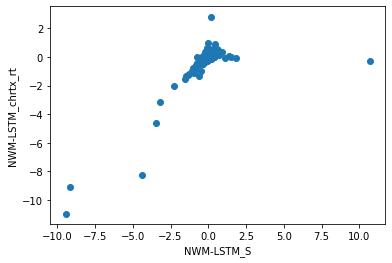

r2 = 0.58
slope = 0.73


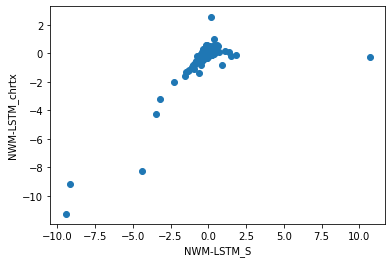

r2 = 0.85
slope = 1.39


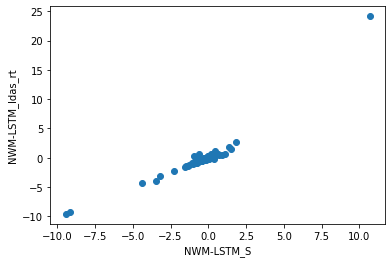

r2 = 0.94
slope = 1.06


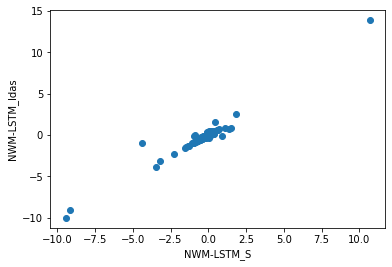

r2 = 0.54
slope = 0.72


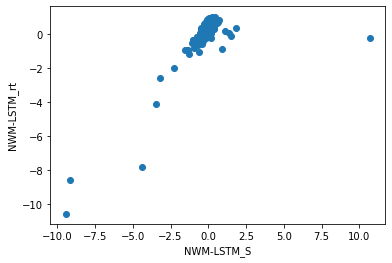

r2 = 0.07
slope = 0.27


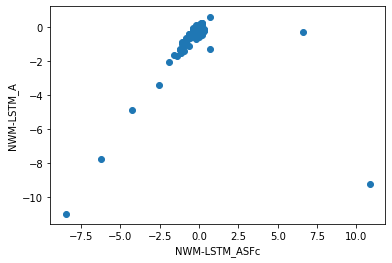

r2 = 0.17
slope = 0.36


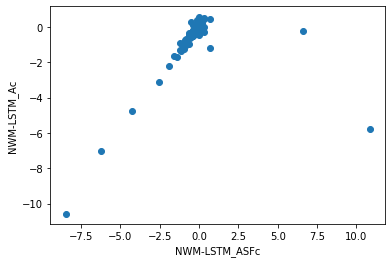

r2 = 0.03
slope = 0.15


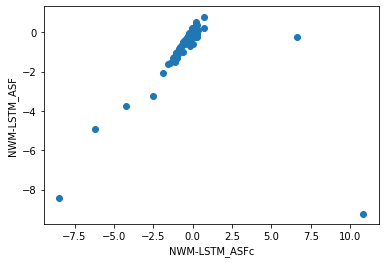

r2 = 0.03
slope = 0.15


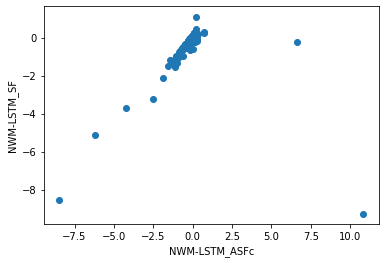

r2 = 0.03
slope = 0.18


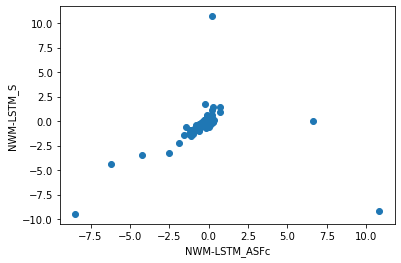

r2 = 1.0
slope = 1.0


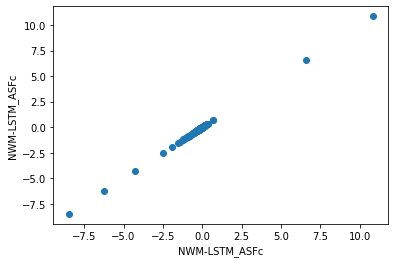

r2 = 0.01
slope = 0.15


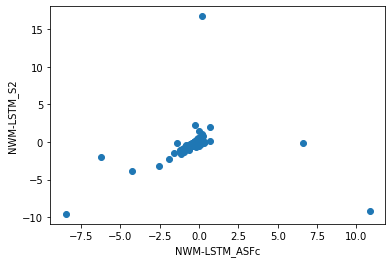

r2 = 0.07
slope = 0.26


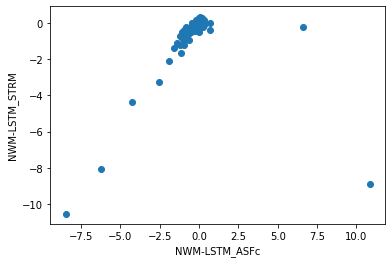

r2 = 0.01
slope = 0.09


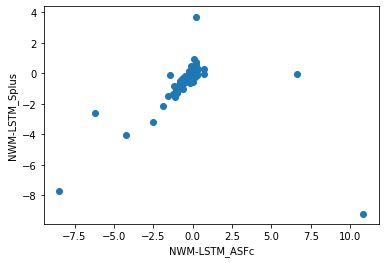

r2 = 0.07
slope = 0.27


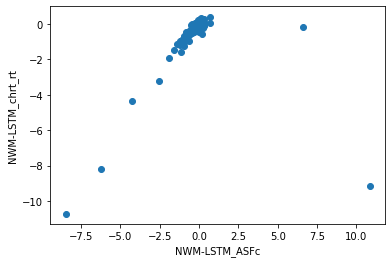

r2 = 0.07
slope = 0.26


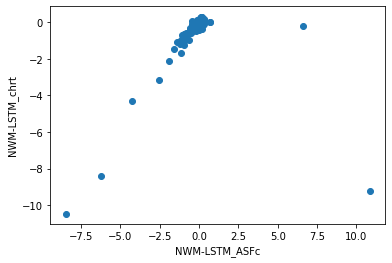

r2 = 0.08
slope = 0.28


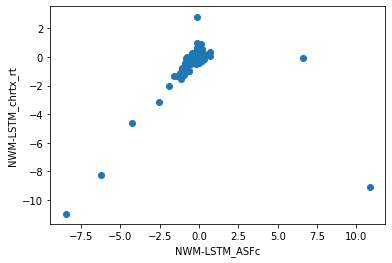

r2 = 0.07
slope = 0.28


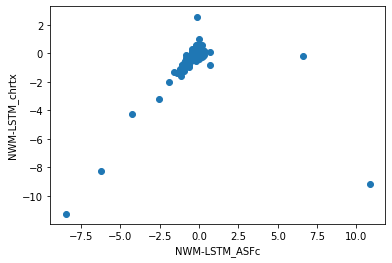

r2 = 0.01
slope = 0.19


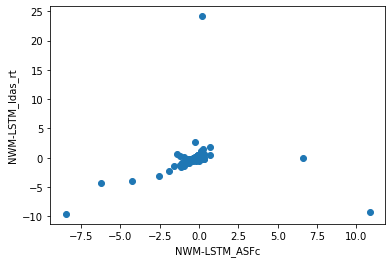

r2 = 0.01
slope = 0.13


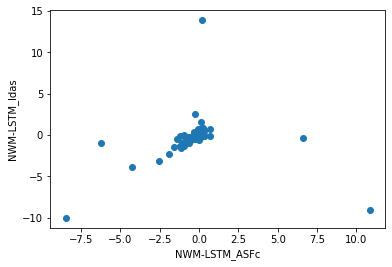

r2 = 0.08
slope = 0.29


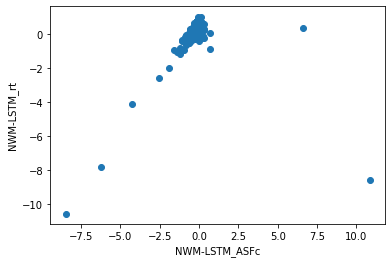

r2 = 0.38
slope = 0.48


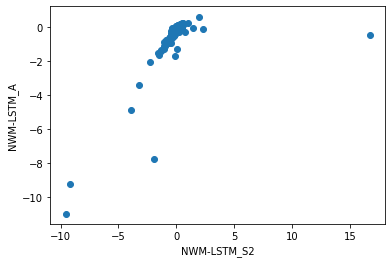

r2 = 0.37
slope = 0.42


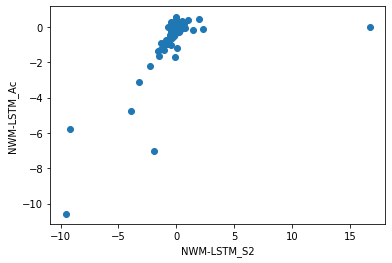

r2 = 0.46
slope = 0.44


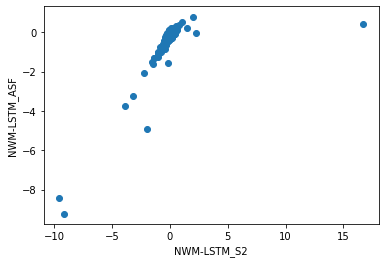

r2 = 0.5
slope = 0.46


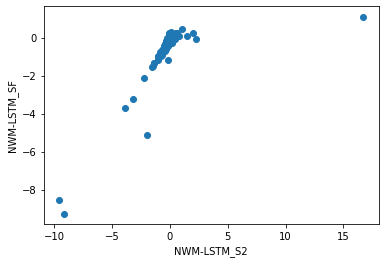

r2 = 0.93
slope = 0.81


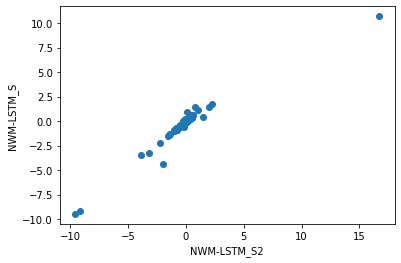

r2 = 0.01
slope = 0.09


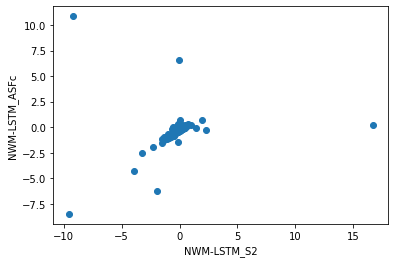

r2 = 1.0
slope = 1.0


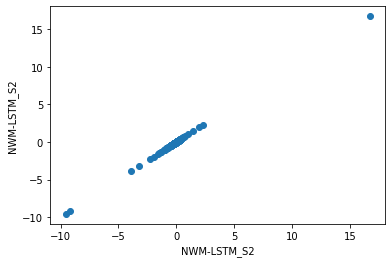

r2 = 0.37
slope = 0.46


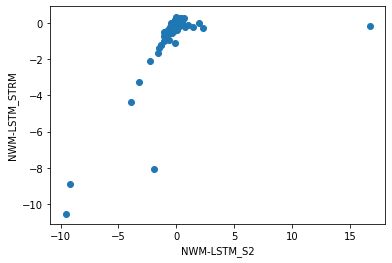

r2 = 0.69
slope = 0.53


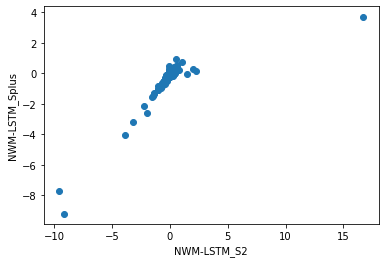

r2 = 0.35
slope = 0.45


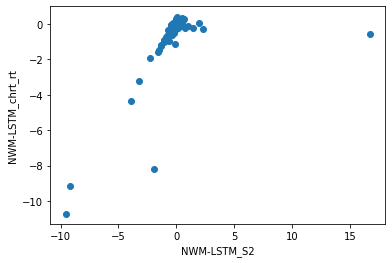

r2 = 0.36
slope = 0.46


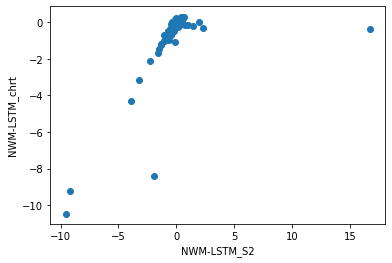

r2 = 0.35
slope = 0.48


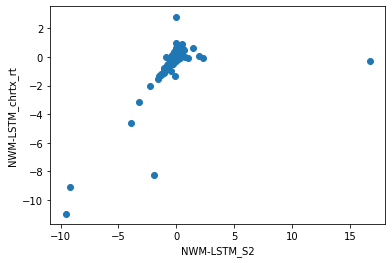

r2 = 0.36
slope = 0.48


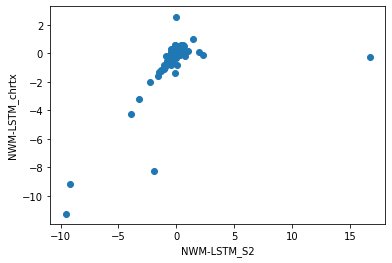

r2 = 0.95
slope = 1.23


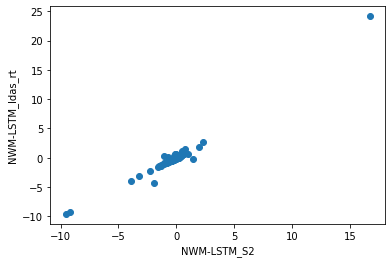

r2 = 0.97
slope = 0.9


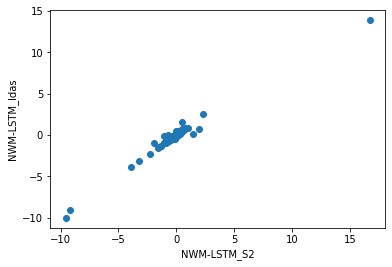

r2 = 0.33
slope = 0.47


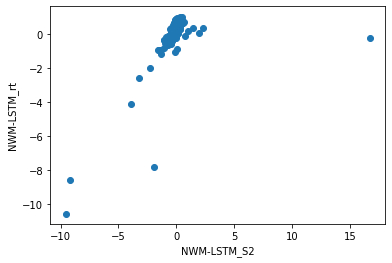

r2 = 0.98
slope = 1.02


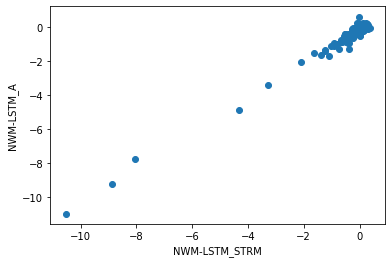

r2 = 0.93
slope = 0.88


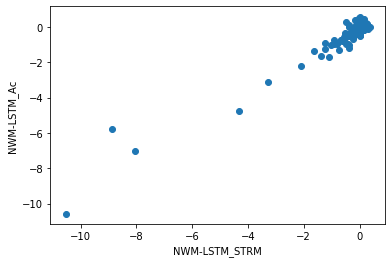

r2 = 0.93
slope = 0.84


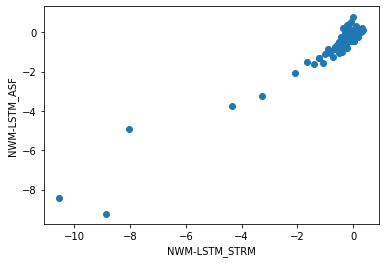

r2 = 0.94
slope = 0.85


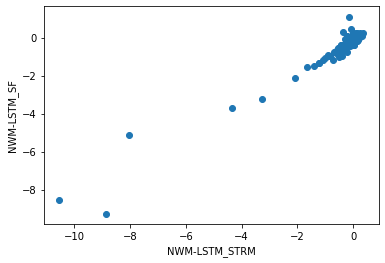

r2 = 0.6
slope = 0.87


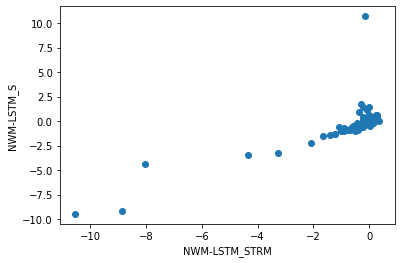

r2 = 0.07
slope = 0.28


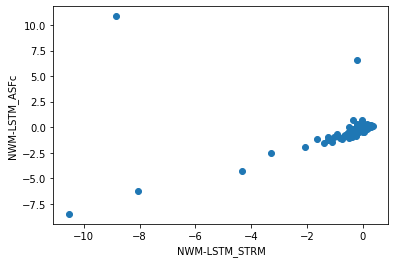

r2 = 0.37
slope = 0.81


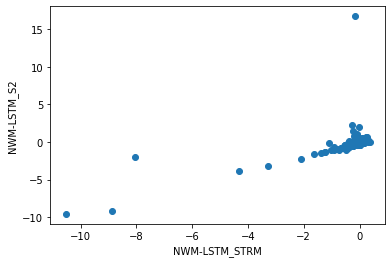

r2 = 1.0
slope = 1.0


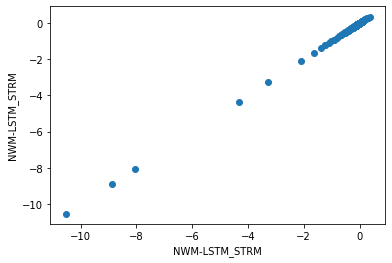

r2 = 0.79
slope = 0.76


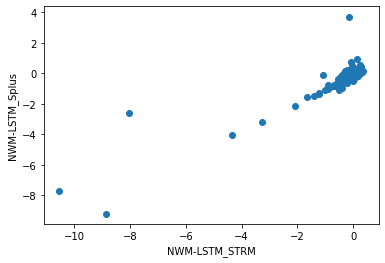

r2 = 0.99
slope = 1.02


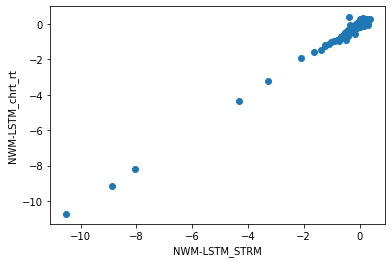

r2 = 0.99
slope = 1.01


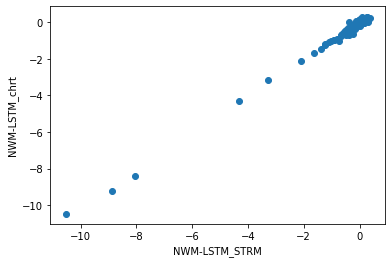

r2 = 0.94
slope = 1.04


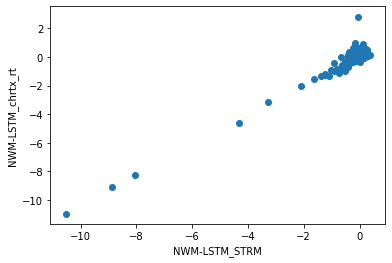

r2 = 0.95
slope = 1.05


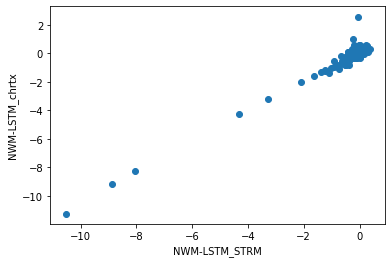

r2 = 0.27
slope = 0.87


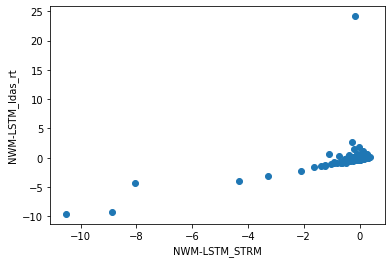

r2 = 0.43
slope = 0.8


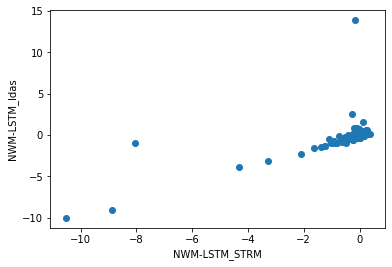

r2 = 0.91
slope = 1.05


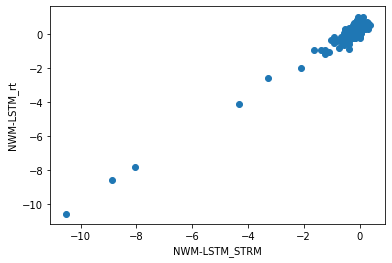

r2 = 0.81
slope = 1.09


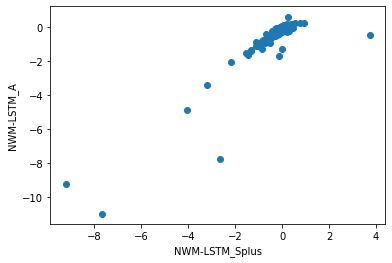

r2 = 0.74
slope = 0.92


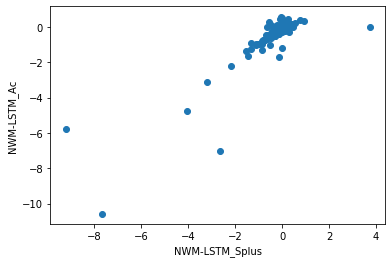

r2 = 0.9
slope = 0.97


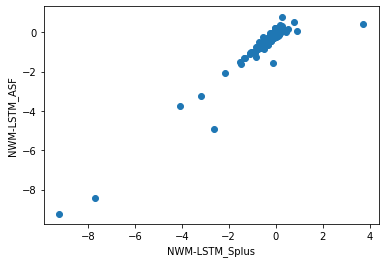

r2 = 0.92
slope = 0.99


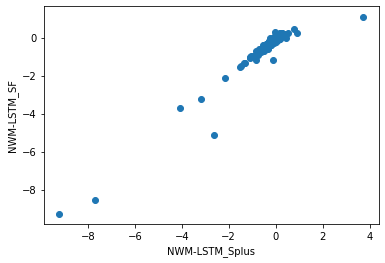

r2 = 0.85
slope = 1.21


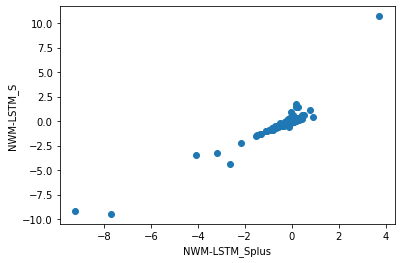

r2 = 0.01
slope = 0.13


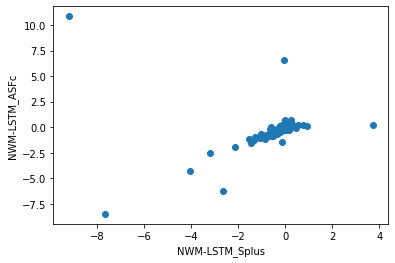

r2 = 0.69
slope = 1.3


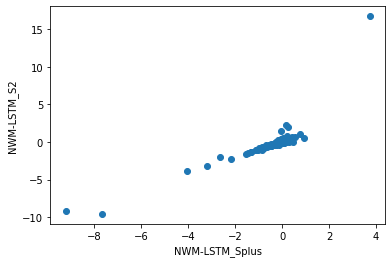

r2 = 0.79
slope = 1.04


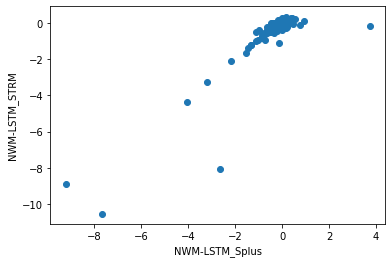

r2 = 1.0
slope = 1.0


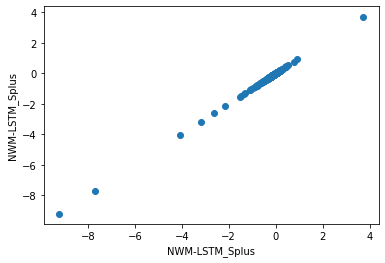

r2 = 0.79
slope = 1.06


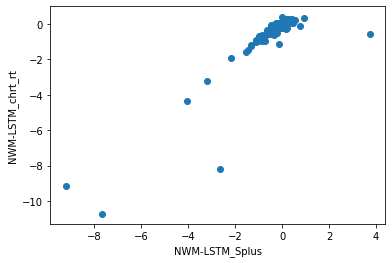

r2 = 0.79
slope = 1.06


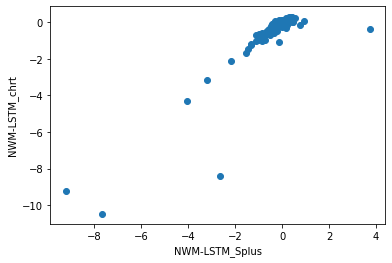

r2 = 0.78
slope = 1.11


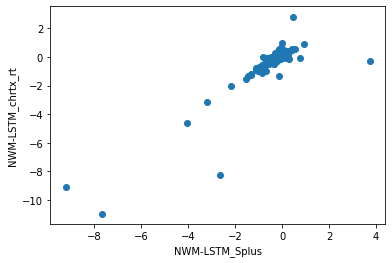

r2 = 0.78
slope = 1.11


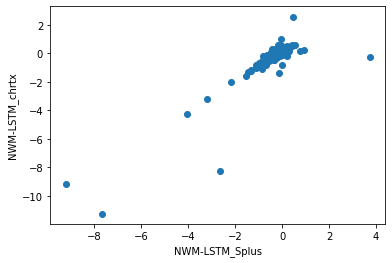

r2 = 0.54
slope = 1.45


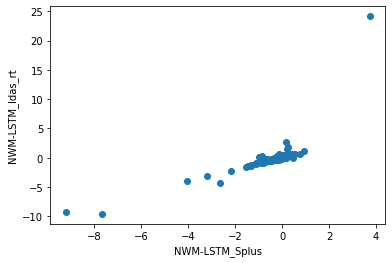

r2 = 0.76
slope = 1.24


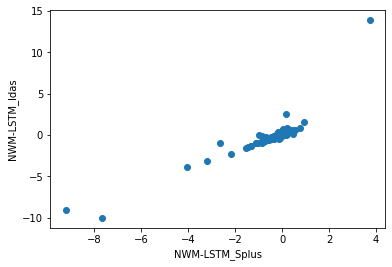

r2 = 0.73
slope = 1.11


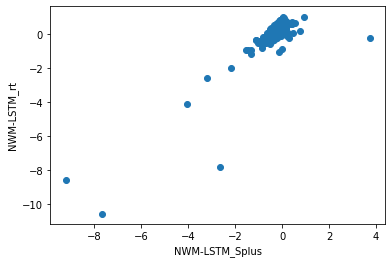

r2 = 0.97
slope = 1.0


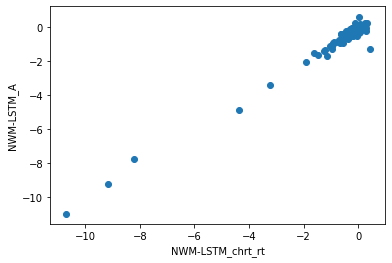

r2 = 0.92
slope = 0.86


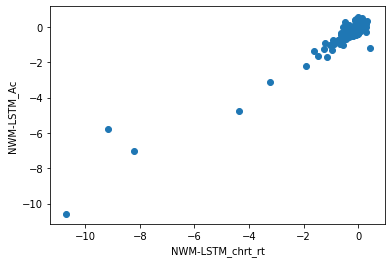

r2 = 0.94
slope = 0.82


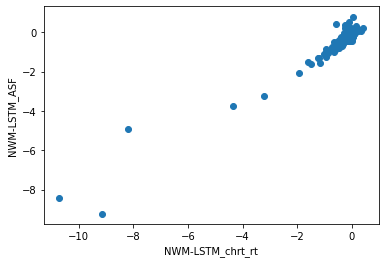

r2 = 0.94
slope = 0.83


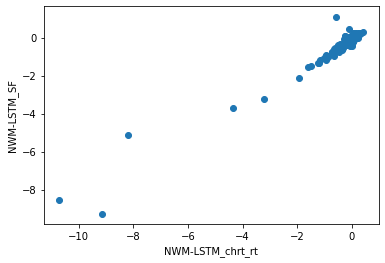

r2 = 0.59
slope = 0.84


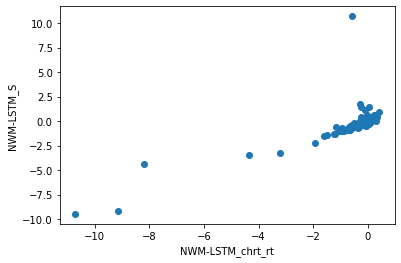

r2 = 0.07
slope = 0.27


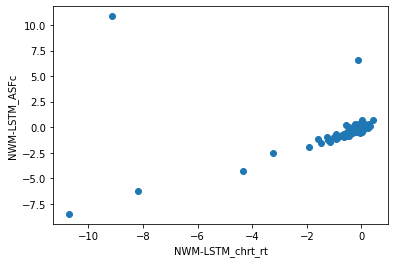

r2 = 0.35
slope = 0.78


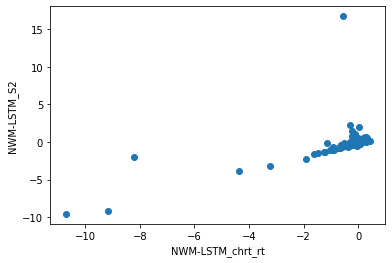

r2 = 0.99
slope = 0.98


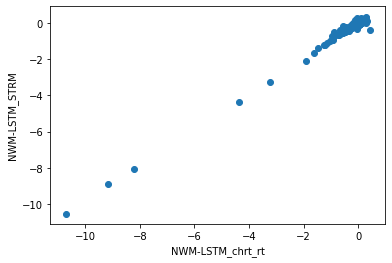

r2 = 0.79
slope = 0.74


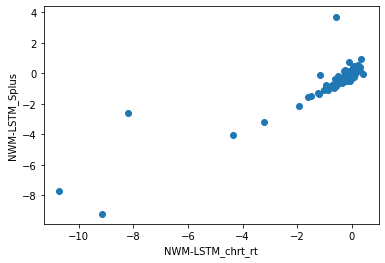

r2 = 1.0
slope = 1.0


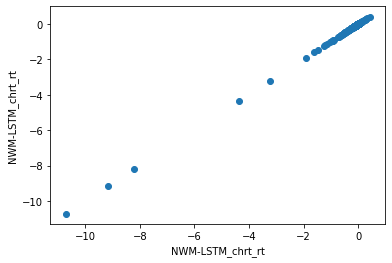

r2 = 1.0
slope = 1.0


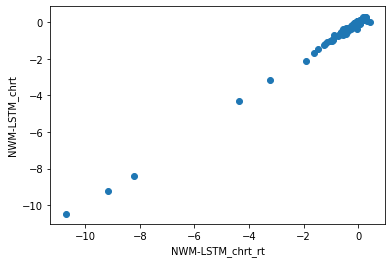

r2 = 0.95
slope = 1.03


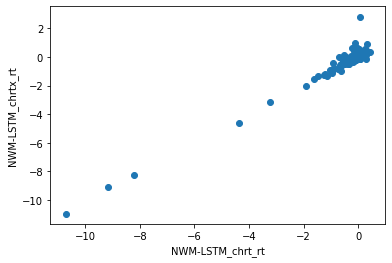

r2 = 0.95
slope = 1.03


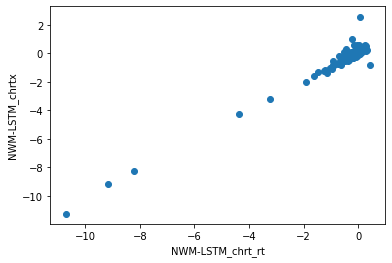

r2 = 0.25
slope = 0.82


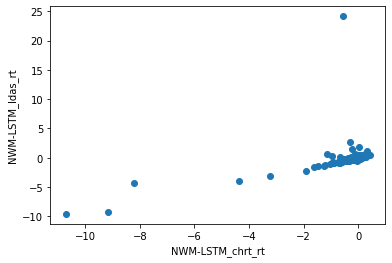

r2 = 0.41
slope = 0.77


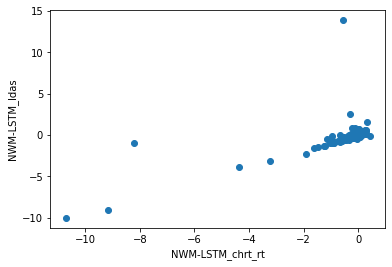

r2 = 0.91
slope = 1.03


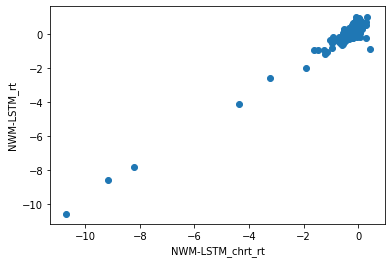

r2 = 0.98
slope = 1.0


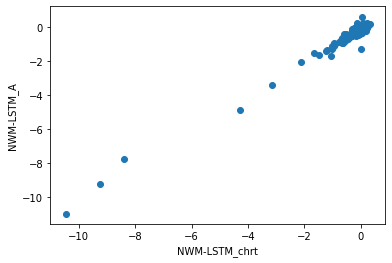

r2 = 0.93
slope = 0.86


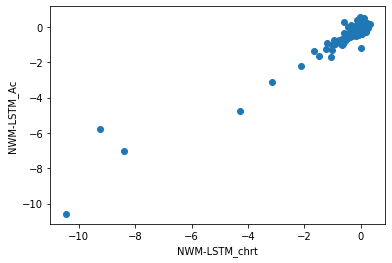

r2 = 0.94
slope = 0.83


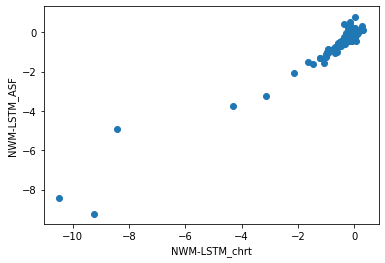

r2 = 0.94
slope = 0.84


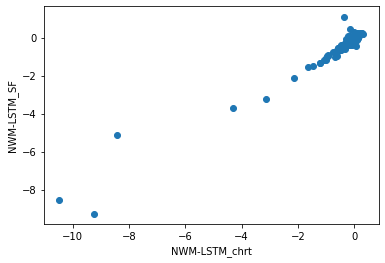

r2 = 0.6
slope = 0.85


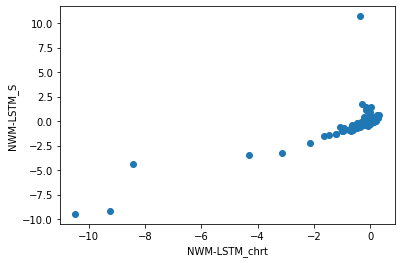

r2 = 0.07
slope = 0.27


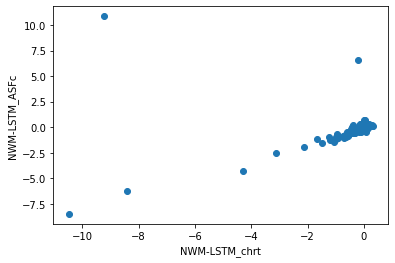

r2 = 0.36
slope = 0.79


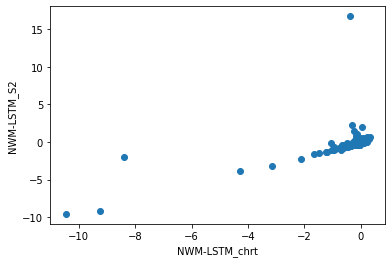

r2 = 0.99
slope = 0.98


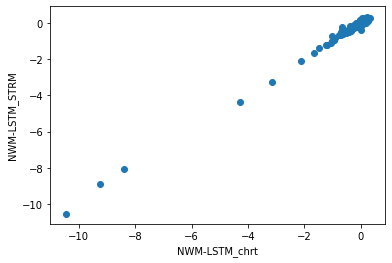

r2 = 0.79
slope = 0.75


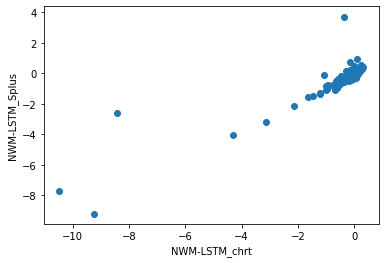

r2 = 1.0
slope = 1.0


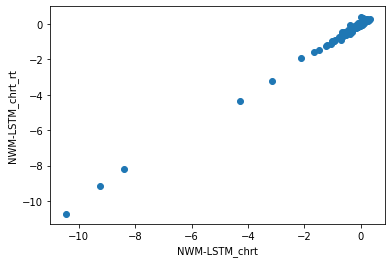

r2 = 1.0
slope = 1.0


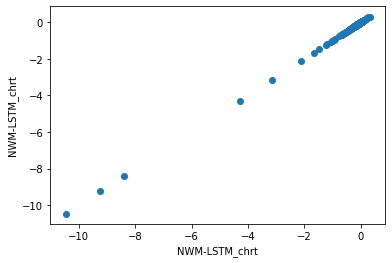

r2 = 0.95
slope = 1.03


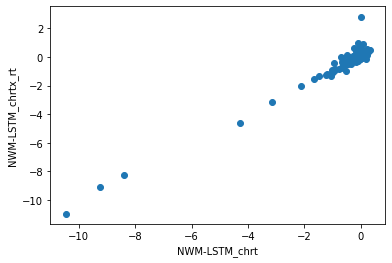

r2 = 0.95
slope = 1.03


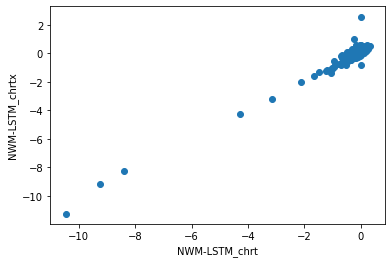

r2 = 0.26
slope = 0.84


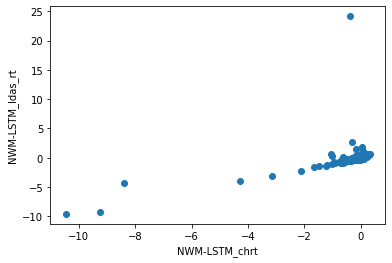

r2 = 0.42
slope = 0.77


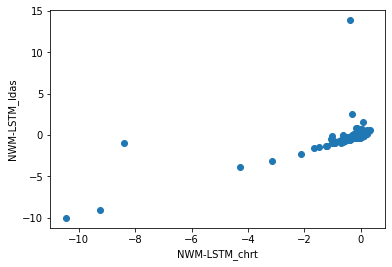

r2 = 0.91
slope = 1.03


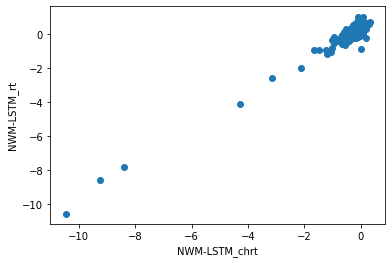

r2 = 0.94
slope = 0.93


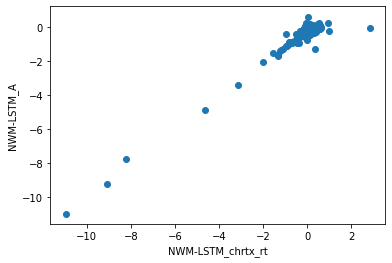

r2 = 0.9
slope = 0.8


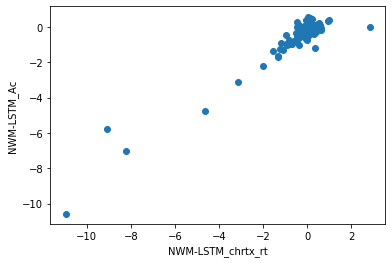

r2 = 0.9
slope = 0.77


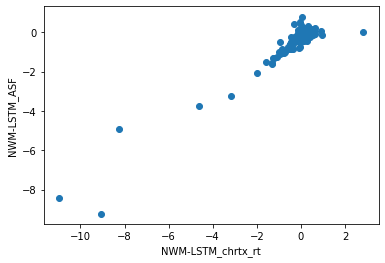

r2 = 0.9
slope = 0.78


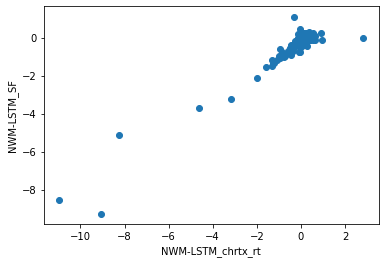

r2 = 0.58
slope = 0.79


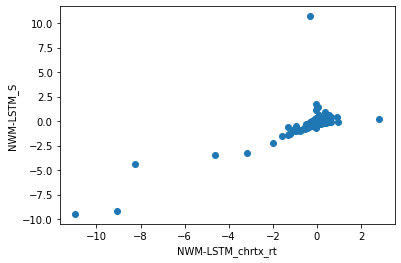

r2 = 0.08
slope = 0.27


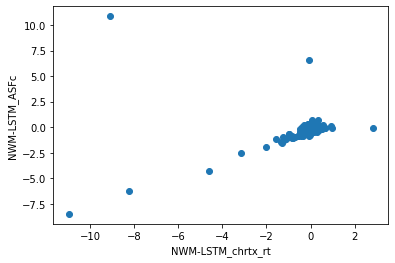

r2 = 0.35
slope = 0.74


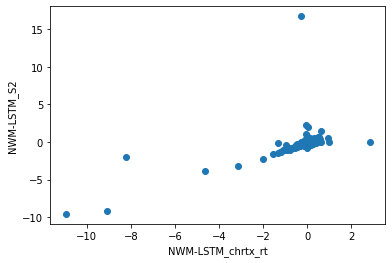

r2 = 0.94
slope = 0.91


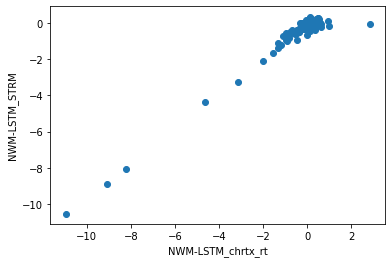

r2 = 0.78
slope = 0.7


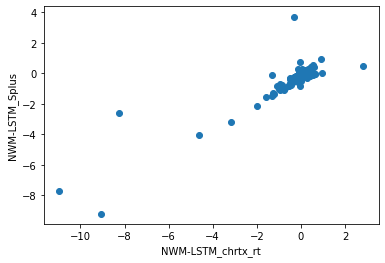

r2 = 0.95
slope = 0.93


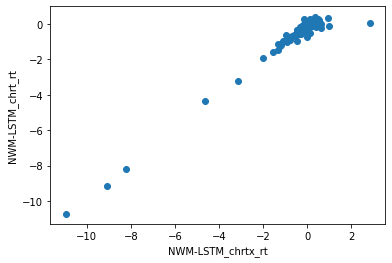

r2 = 0.95
slope = 0.93


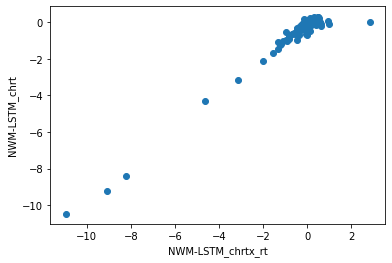

r2 = 1.0
slope = 1.0


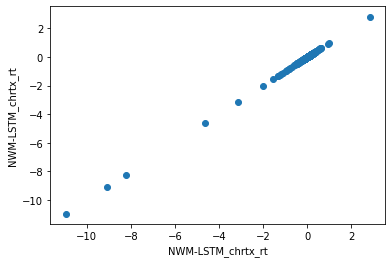

r2 = 0.99
slope = 1.0


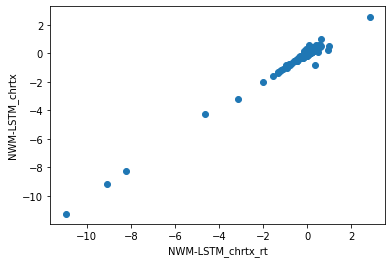

r2 = 0.25
slope = 0.78


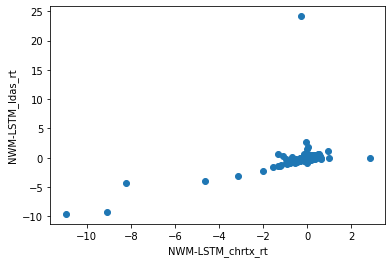

r2 = 0.41
slope = 0.73


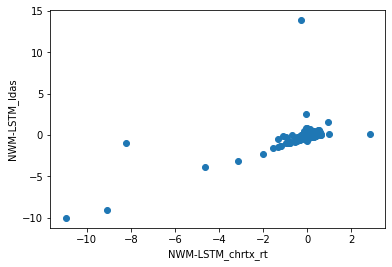

r2 = 0.88
slope = 0.97


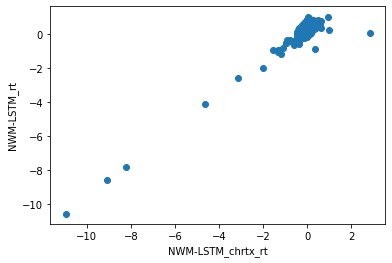

r2 = 0.95
slope = 0.94


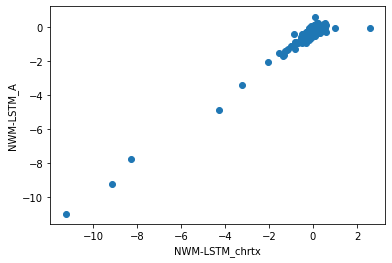

r2 = 0.91
slope = 0.8


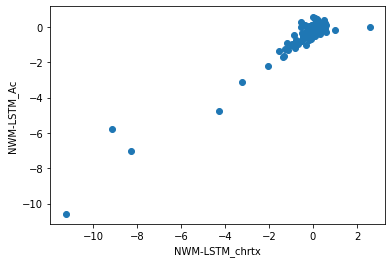

r2 = 0.9
slope = 0.77


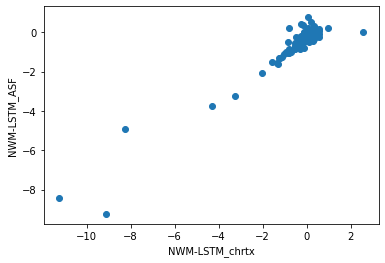

r2 = 0.91
slope = 0.77


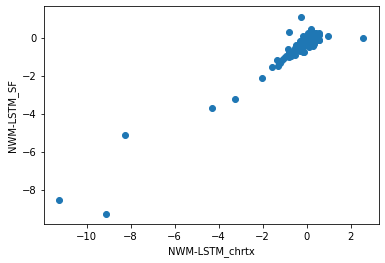

r2 = 0.58
slope = 0.79


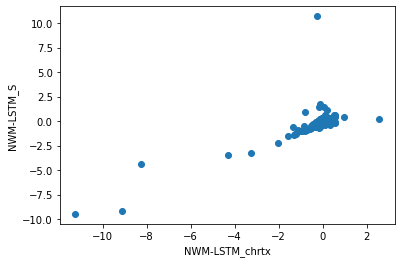

r2 = 0.07
slope = 0.26


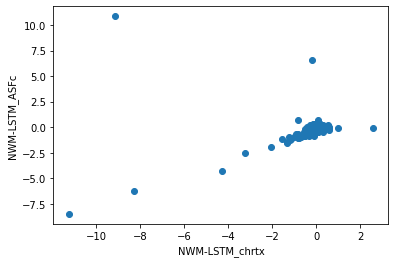

r2 = 0.36
slope = 0.74


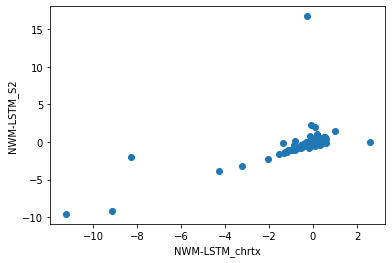

r2 = 0.95
slope = 0.91


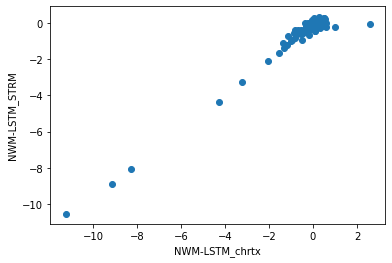

r2 = 0.78
slope = 0.7


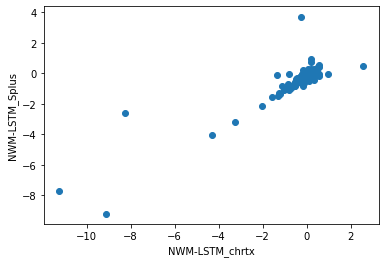

r2 = 0.95
slope = 0.92


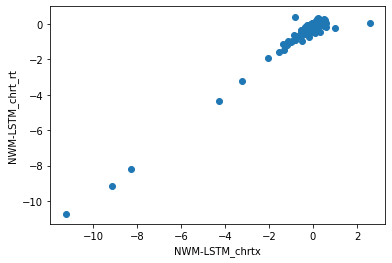

r2 = 0.95
slope = 0.92


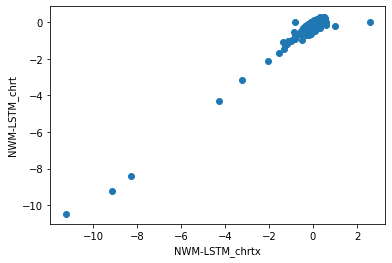

r2 = 0.99
slope = 0.99


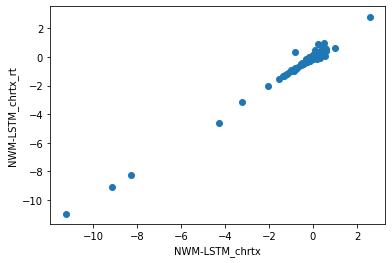

r2 = 1.0
slope = 1.0


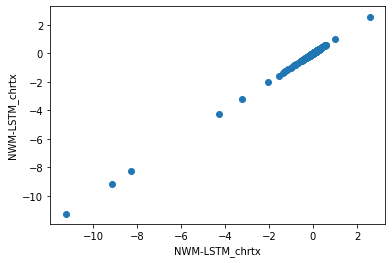

r2 = 0.25
slope = 0.78


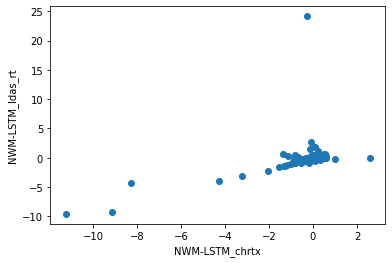

r2 = 0.41
slope = 0.72


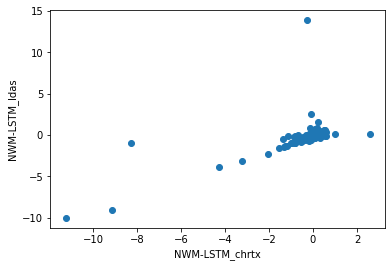

r2 = 0.88
slope = 0.96


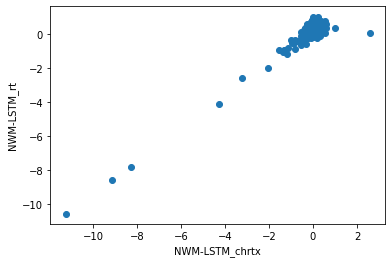

r2 = 0.26
slope = 0.31


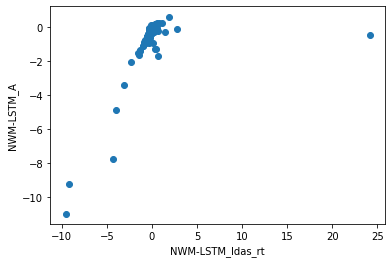

r2 = 0.26
slope = 0.28


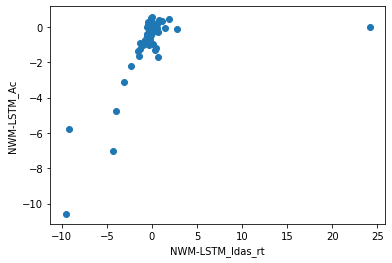

r2 = 0.32
slope = 0.29


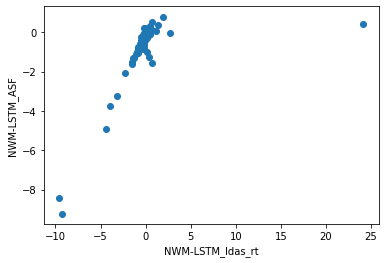

r2 = 0.36
slope = 0.31


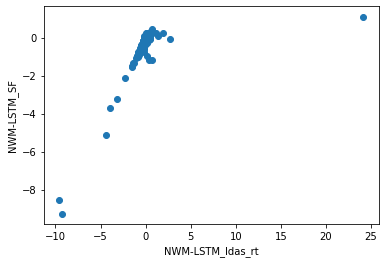

r2 = 0.85
slope = 0.61


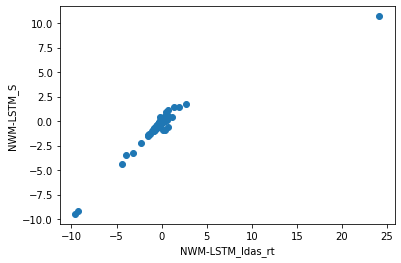

r2 = 0.01
slope = 0.07


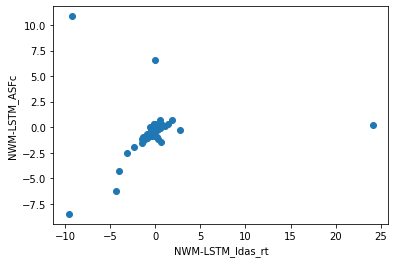

r2 = 0.95
slope = 0.77


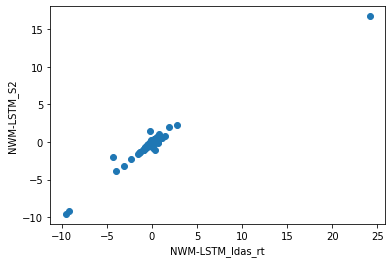

r2 = 0.27
slope = 0.31


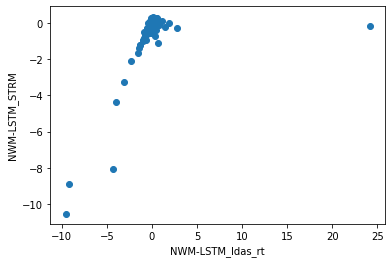

r2 = 0.54
slope = 0.37


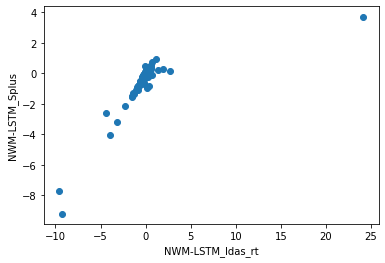

r2 = 0.25
slope = 0.3


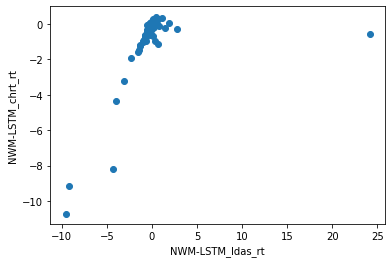

r2 = 0.26
slope = 0.3


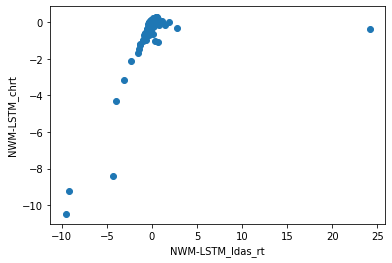

r2 = 0.25
slope = 0.31


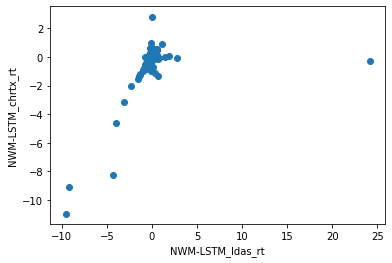

r2 = 0.25
slope = 0.32


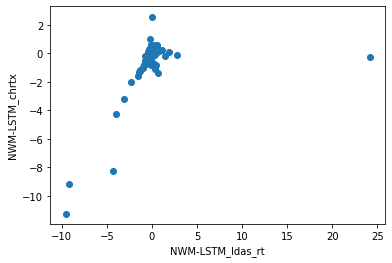

r2 = 1.0
slope = 1.0


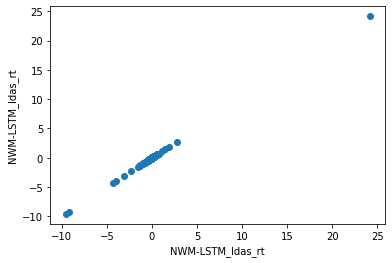

r2 = 0.91
slope = 0.69


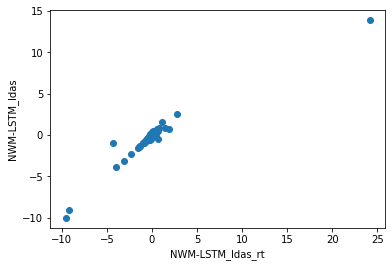

r2 = 0.22
slope = 0.31


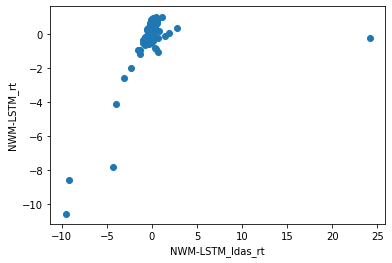

r2 = 0.44
slope = 0.56


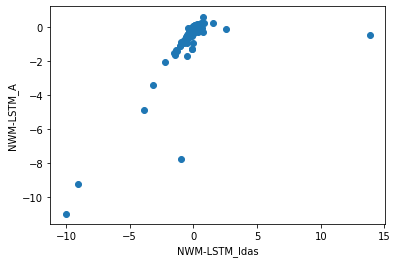

r2 = 0.42
slope = 0.49


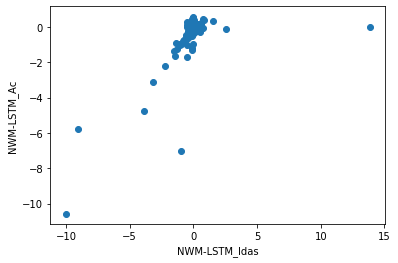

r2 = 0.52
slope = 0.51


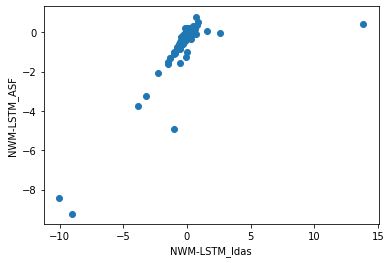

r2 = 0.56
slope = 0.54


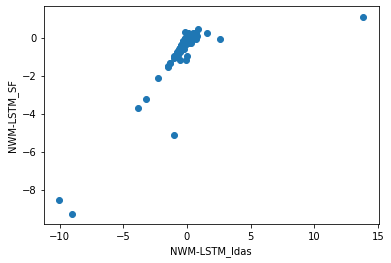

r2 = 0.94
slope = 0.88


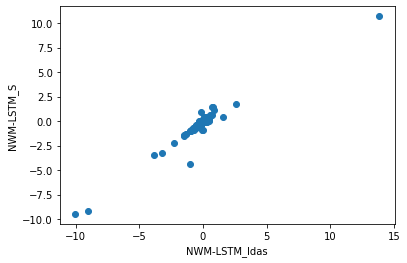

r2 = 0.01
slope = 0.09


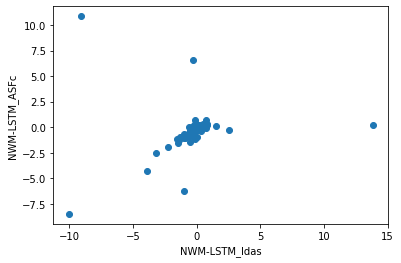

r2 = 0.97
slope = 1.08


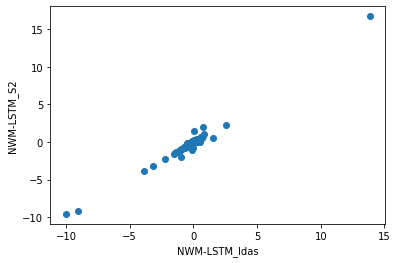

r2 = 0.43
slope = 0.54


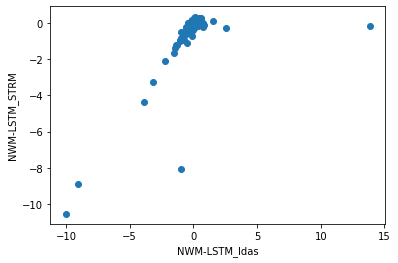

r2 = 0.76
slope = 0.61


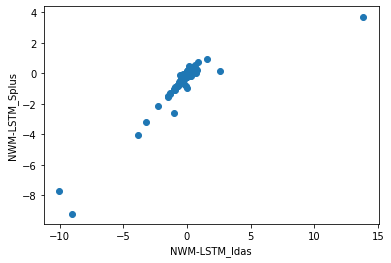

r2 = 0.41
slope = 0.54


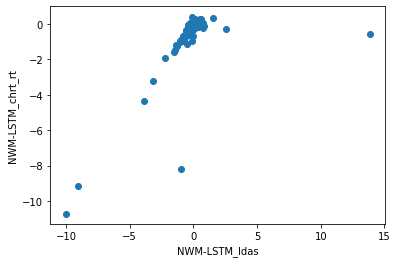

r2 = 0.42
slope = 0.54


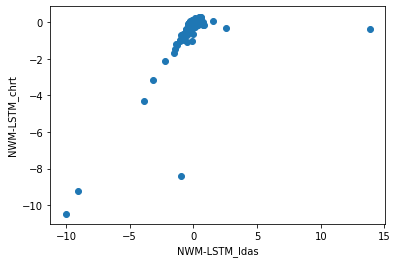

r2 = 0.41
slope = 0.56


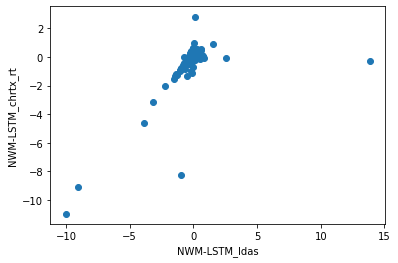

r2 = 0.41
slope = 0.56


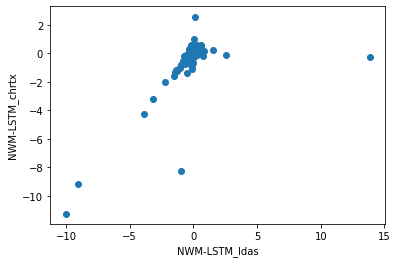

r2 = 0.91
slope = 1.32


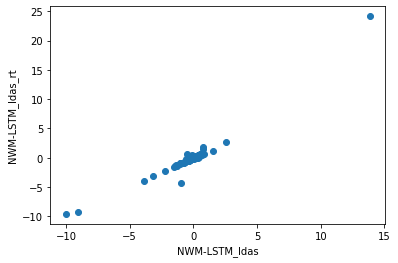

r2 = 1.0
slope = 1.0


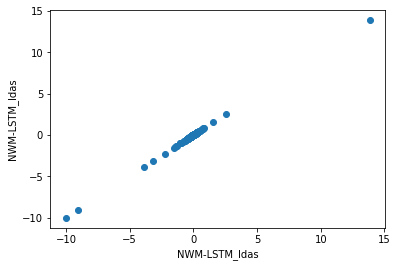

r2 = 0.38
slope = 0.56


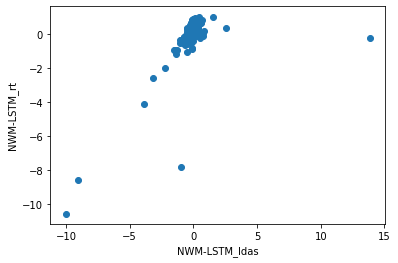

r2 = 0.92
slope = 0.9


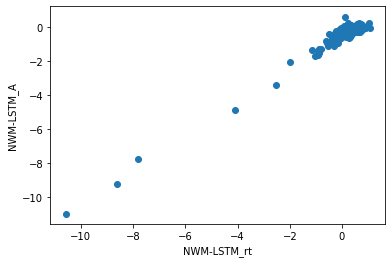

r2 = 0.89
slope = 0.78


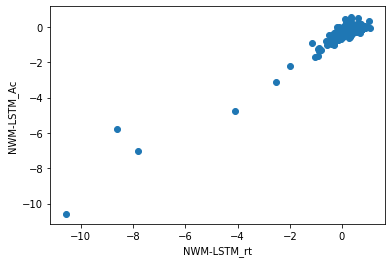

r2 = 0.87
slope = 0.73


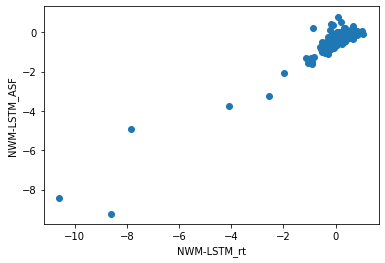

r2 = 0.87
slope = 0.74


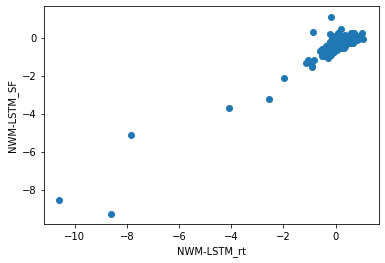

r2 = 0.54
slope = 0.74


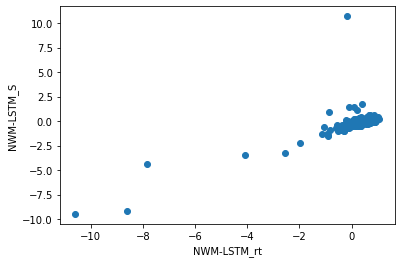

r2 = 0.08
slope = 0.26


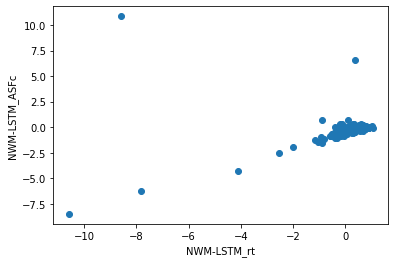

r2 = 0.33
slope = 0.69


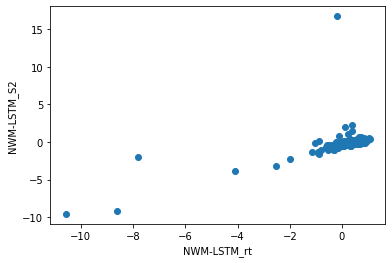

r2 = 0.91
slope = 0.86


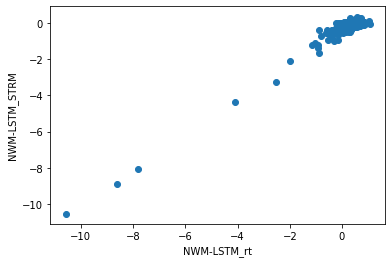

r2 = 0.73
slope = 0.66


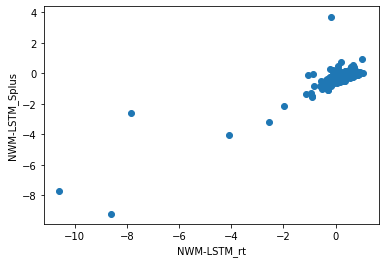

r2 = 0.91
slope = 0.88


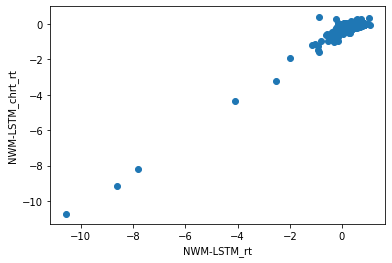

r2 = 0.91
slope = 0.88


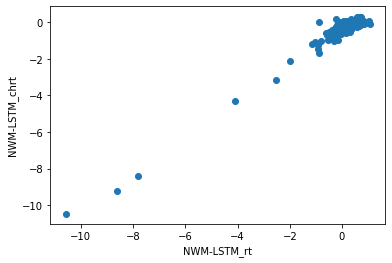

r2 = 0.88
slope = 0.91


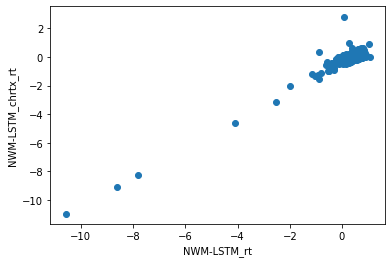

r2 = 0.88
slope = 0.92


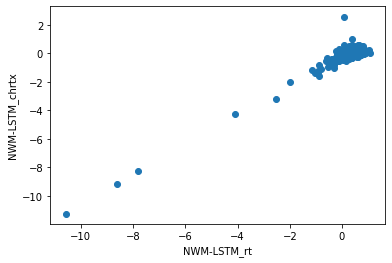

r2 = 0.22
slope = 0.72


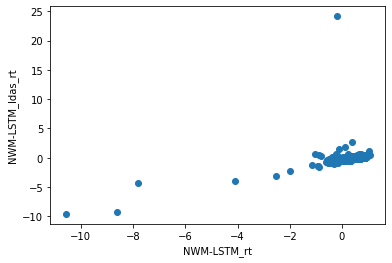

r2 = 0.38
slope = 0.68


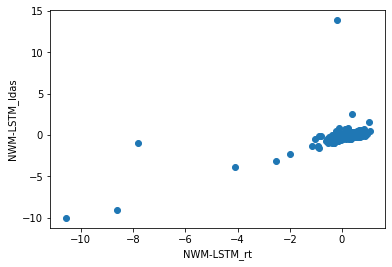

r2 = 1.0
slope = 1.0


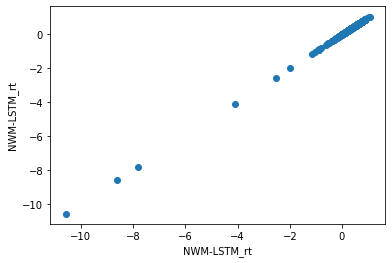

In [56]:
#df.columns.values[-30:-1]
model1 = 'NWM'
for model2 in lstm_version_list:
    model2_diff_name = str(model1)+'-'+str(model2)
    for model3 in lstm_version_list:
        model3_diff_name = str(model1)+'-'+str(model3)
        slope, _, r_value, _, _ = scipy.stats.linregress(df[model2_diff_name], df[model3_diff_name])
        r2 = r_value**2  
        print('r2 = '+str(round(r2,2)))
        print('slope = '+str(round(slope,2)))
        plt.scatter(df[model2_diff_name], df[model3_diff_name])
        plt.xlabel(model2_diff_name)
        plt.ylabel(model3_diff_name)
        plt.show()
        plt.close()

### All NWM state and flux values

In [57]:
# load dynamic features data, which has all the NWM States and Fluxes
with open(data_dir+'dynamic_features_nwm_v2.p', 'rb') as f:
    dynamic_features_data = pkl.load(f)

In [58]:
nwm_columns = list(dynamic_features_data[sample_basin].columns[10:])

In [59]:
nwm_average_values = pd.DataFrame(index=basin_list, columns=nwm_columns)
for b, basin in enumerate(basin_list):
    nwm_average_values.loc[basin,:] = dynamic_features_data[basin].iloc[10:].mean()
nwm_average_values

streamflow q_lateral velocity qSfcLatRunoff qBucket qBtmVertRunoff   ACCET     FIRA       FSA    FSNO  ... SOIL_W1 SOIL_W2 SOIL_W3 SOIL_W4      TRAD UGDRNOFF mean_sfcheadsubrt mean_zwattablrt max_sfcheadsubrt max_zwattablrt
01022500   11.80678   0.05726  0.67408       0.00901 0.04956      178.41287 0.16003 53.78358 133.90569 0.30298  ... 0.27061 0.28866 0.30100 0.30613 280.38024  0.05956           0.00000         2.00000          0.00000        2.00000
01031500   14.91785   0.09322  0.11252       0.08603 0.01723       62.05605 0.14284 51.75442 128.54072 0.38806  ... 0.28084 0.30631 0.32543 0.34309 278.06529  0.01613           0.00000         2.00000          0.00000        2.00000
01047000   20.97725   0.09989  0.76204       0.08411 0.02694       97.03694 0.14900 51.31855 135.75556 0.42473  ... 0.23537 0.26322 0.28487 0.30819 277.45750  0.02696           0.00000         2.00000          0.00000        2.00000
01052500    9.32967   0.02324  1.15628       0.00081 0.03600      129.59121 0.14388 48.70902 128.11123 0.43817  ... 0.28386 0.30584 0.31811 0.33307 276.81217  0.05022           0.00000         2.00000          0.00000        2.00000
01054200    5.51216   0.01970  0.96970       0.01941 0.01241       44.68099 0.17124 49.85445 142.05464 0.46513  ... 0.21850 0.25635 0.28580 0.30695 276.62149  0.07554           0.00000         2.00000          0.00000        2.00000
...             ...       ...      ...           ...     ...            ...     ...      ...       ...     ...  ...     ...     ...     ...     ...       ...      ...               ...             ...              ...            ...
11482500   25.29624   0.21110  0.58753       0.01624 0.19905      716.47005 0.14034 67.85576 179.18565 0.05828  ... 0.31058 0.31471 0.32340 0.34778 283.74471  0.12721           0.00000         2.00000          0.00000        2.00000
11522500   57.19554   0.06526  1.44764       0.01183 0.05777      207.93827 0.11116 72.13259 174.51202 0.33703  ... 0.24413 0.24986 0.25487 0.26544 280.66653  0.26009           0.00000         2.00000          0.00000        2.00000
11523200   11.01348   0.07853  1.11865       0.01893 0.06367      229.19817 0.06387 77.37446 164.46590 0.44909  ... 0.17525 0.19248 0.21120 0.25821 278.51080  0.23864           0.00000         2.00000          0.00000        2.00000
11528700   42.45678   0.04810  1.02632       0.00260 0.05117      184.20374 0.16493 71.07061 177.73345 0.30486  ... 0.25251 0.26180 0.26651 0.27415 280.68853  0.13078           0.00000         2.00000          0.00000        2.00000
11532500  103.87407   0.02944  1.39749       0.01453 0.02531       91.11037 0.10754 63.29900 179.69583 0.01072  ... 0.33036 0.33231 0.33585 0.34350 282.50251  0.40909           0.00000         2.00000          0.00000        2.00000

[531 rows x 28 columns]

In [60]:
nwm_average_values_soil_M = nwm_average_values.columns[14:18]
nwm_average_values_soil_W = nwm_average_values.columns[18:22]
nwm_average_values_soil_slim = nwm_average_values.copy(deep=True)
nwm_average_values_soil_slim = nwm_average_values_soil_slim.drop(nwm_average_values_soil_M, axis = 1)
nwm_average_values_soil_slim = nwm_average_values_soil_slim.drop(nwm_average_values_soil_W, axis = 1)
nwm_average_values_soil_slim = nwm_average_values_soil_slim.drop(['mean_sfcheadsubrt',
                                'mean_zwattablrt','max_sfcheadsubrt','max_zwattablrt'], axis = 1)
nwm_average_values_soil_slim['SM_W'] = np.mean(nwm_average_values.loc[:,nwm_average_values_soil_W], axis=1)
nwm_average_values_soil_slim['SM_M'] = np.mean(nwm_average_values.loc[:,nwm_average_values_soil_M], axis=1)

nwm_average_values_soil_slim['zwattablrt'] = np.mean(nwm_average_values.loc[:,
                                                    ('mean_zwattablrt','max_zwattablrt')], axis=1)
nwm_average_values_soil_slim['sfcheadsubrt'] = np.mean(nwm_average_values.loc[:,
                                                    ('mean_sfcheadsubrt','max_sfcheadsubrt')], axis=1)
nwm_average_values_soil_slim
nwm_columns_soil_slim = nwm_average_values_soil_slim.columns.values

In [61]:
optimal = [1, 0, 0]
improvements = {}
for ifc, fc in enumerate(flow_categories_very_slim):    
    for imt, mod in enumerate(base_models):
        for imet, metric in enumerate(use_metrics):
            control = met_mat[fc][:,imt,imet]       #metric_values.loc[:,(hyd, metric, 'test')]
            test = met_mat[fc][:,2,imet]
            if optimal[imt] == 1:
                improvements[(fc,mod,metric)] = test-control
            elif optimal[imt] == 0:
                improvements[(fc,mod,metric)] = (np.abs(test)-np.abs(control))

In [62]:
corr = {}
for ifc, fc in enumerate(flow_categories_very_slim):    
    for imt, mod in enumerate(base_models):
        corr[(fc,mod)] = pd.DataFrame(index=nwm_columns_soil_slim, columns=use_metrics)
        for imet, metric in enumerate(use_metrics):
            for i, inpt in enumerate(nwm_columns_soil_slim):
                x = nwm_average_values_soil_slim[inpt].values.astype(float)
                y = improvements[(fc,mod,metric)]
                corr[(fc,mod)].loc[inpt,metric] = np.corrcoef(x, y)[0,1]          

In [63]:
for ifc, fc in enumerate(flow_categories_very_slim):    
    for imt, mod in enumerate(base_models):
        corr[(fc,mod)].rename(columns={use_metrics[0]:short_metric_names[0], use_metrics[1]:short_metric_names[1],
                    use_metrics[2]:short_metric_names[2]})
        corr[(fc,mod)] = corr[(fc,mod)].rename(index={'qSfcLatRunoff':'qLateral', 'qBtmVertRunoff':'qBottom'})

In [64]:
corr

{('all',
  'NWM'):                   NSE Beta-NSE Peak-Timing
 streamflow   -0.07965 -0.19560    -0.08959
 q_lateral    -0.06500 -0.07655    -0.00054
 velocity      0.01718 -0.23130    -0.18640
 qLateral     -0.08776 -0.03829     0.03965
 qBucket      -0.02908 -0.10219    -0.04641
 qBottom      -0.02913 -0.10212    -0.04630
 ACCET        -0.06725  0.20134     0.16948
 FIRA          0.13515  0.06703     0.03051
 FSA          -0.04031  0.09961     0.17096
 FSNO          0.13416 -0.16061    -0.24621
 HFX          -0.09910 -0.07345     0.08481
 LH           -0.06538  0.20336     0.17022
 SNEQV         0.01601 -0.23845    -0.26373
 SNOWH         0.02706 -0.25603    -0.29321
 TRAD         -0.13051  0.19428     0.26245
 UGDRNOFF      0.03110 -0.37268    -0.28979
 SM_W         -0.10192 -0.00386     0.08541
 SM_M         -0.04126 -0.01540     0.03693
 zwattablrt   -0.03745 -0.14868    -0.11823
 sfcheadsubrt -0.01104  0.01333     0.00904,
 ('all',
  'LSTM_A'):                   NSE Beta-NSE Peak

Text(0, 0.5, 'Correlation')

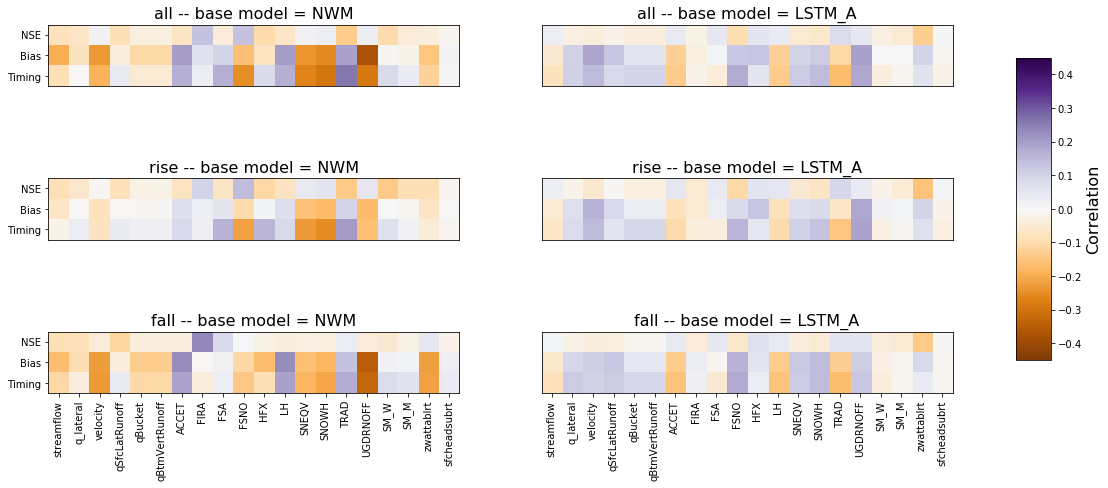

In [65]:
fig, ax = plt.subplots(3,2,figsize=(16,8))
for ifc,fc in enumerate(flow_categories_very_slim):    
    for imt, mod in enumerate(base_models):
        im = ax[ifc,imt].imshow(corr[(fc,mod)].transpose().astype(float),
                       cmap='PuOr',
                      vmax=0.45, vmin=-0.45)
        ax[ifc,imt].set_xticks([])
        ax[ifc,imt].set_yticks([])
        ax[ifc,imt].set_title(f"{fc.replace('_',' ')} -- base model = {base_models[imt]}", fontsize=16)
        
ax[2,0].set_xticks(range(len(nwm_average_values_soil_slim.columns)))
ax[2,1].set_xticks(range(len(nwm_average_values_soil_slim.columns)))
ax[2,0].set_xticklabels(nwm_average_values_soil_slim.columns, rotation='vertical')
ax[2,1].set_xticklabels(nwm_average_values_soil_slim.columns, rotation='vertical')

ax[0,0].set_yticks(range(len(use_metrics)))
ax[1,0].set_yticks(range(len(use_metrics)))
ax[2,0].set_yticks(range(len(use_metrics)))
ax[0,0].set_yticklabels(short_metric_names)
ax[1,0].set_yticklabels(short_metric_names)
ax[2,0].set_yticklabels(short_metric_names)

fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.965, 0.24, 0.03, 0.525])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel('Correlation', fontsize=16)


Text(0, 0.5, 'Correlation')

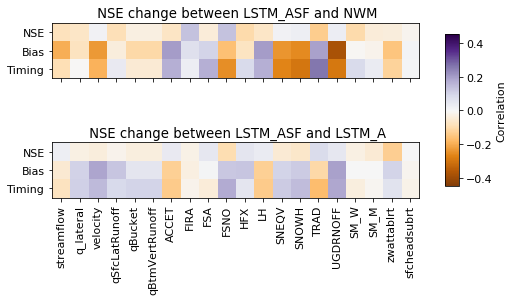

In [66]:
mpl.rcParams.update({'font.size': 11})
fig, ax = plt.subplots(2,1,figsize=(6.5,4.02))
for imt, mod in enumerate(base_models):
    im = ax[imt].imshow(corr[('all',mod)].transpose().astype(float),
                   cmap='PuOr',
                  vmax=0.45, vmin=-0.45)
    ax[imt].set_xticks([])
    ax[imt].set_yticks([])
    ax[imt].set_title(' NSE change between LSTM_ASF and ' + base_models[imt])
        
ax[0].set_xticks(range(len(nwm_average_values_soil_slim.columns)))
ax[1].set_xticks(range(len(nwm_average_values_soil_slim.columns)))
ax[0].set_xticklabels([])
ax[1].set_xticklabels(nwm_average_values_soil_slim.columns, rotation='vertical')

ax[0].set_yticks(range(len(use_metrics)))
ax[1].set_yticks(range(len(use_metrics)))
ax[0].set_yticklabels(short_metric_names)
ax[1].set_yticklabels(short_metric_names)

fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.965, 0.24, 0.03, 0.525])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel('Correlation')

In [67]:
for imt, mod in enumerate(base_models):
    print(np.abs(np.mean(corr[('all',mod)].transpose().astype(float), axis=0)).sort_values())

sfcheadsubrt   0.00378
SM_M           0.00658
SM_W           0.00679
qLateral       0.02880
HFX            0.02925
q_lateral      0.04736
qBottom        0.05919
qBucket        0.05923
FSA            0.07675
FIRA           0.07756
FSNO           0.09088
ACCET          0.10119
zwattablrt     0.10145
LH             0.10273
TRAD           0.10874
streamflow     0.12161
velocity       0.13350
SNEQV          0.16206
SNOWH          0.17406
UGDRNOFF       0.21045
dtype: float64
FSA            0.00487
sfcheadsubrt   0.00952
zwattablrt     0.01203
SM_M           0.01799
SM_W           0.01894
FIRA           0.02318
streamflow     0.03203
qBottom        0.04071
qBucket        0.04073
SNEQV          0.05689
q_lateral      0.06068
TRAD           0.06201
SNOWH          0.06749
qLateral       0.06768
FSNO           0.07008
ACCET          0.07366
LH             0.07382
HFX            0.07941
velocity       0.09994
UGDRNOFF       0.14207
dtype: float64


# Split by if calibrated basin

In [68]:
for imet, nmet in enumerate([0,6,11]):
    attributes2 = attributes.copy(deep=True)
    
    list_mod = ['NWM','LSTM_A','LSTM_Ac','LSTM_ASF','LSTM_ASFc','diff0','diff2','diff0c','diff2c','diff0c2c']
    for imod in list_mod:
        attributes2[imod] = [np.nan]*attributes2.shape[0]

    r=0
    for i, b in enumerate(basin_list):
        for imod in ['LSTM_A','LSTM_Ac','LSTM_ASF','LSTM_ASFc','NWM']:
            attributes2.loc[int(b), imod] = ensemble_metric_dictionary[imod][i,nmet]
        attributes2.loc[int(b), 'diff0'] = \
                           ensemble_metric_dictionary['LSTM_A'][i,nmet] - \
                           ensemble_metric_dictionary['NWM'][i,nmet]
        attributes2.loc[int(b), 'diff2'] = \
                           ensemble_metric_dictionary['LSTM_ASF'][i,nmet] - \
                           ensemble_metric_dictionary['NWM'][i,nmet]
        attributes2.loc[int(b), 'diff0c'] = \
                           ensemble_metric_dictionary['LSTM_Ac'][i,nmet] - \
                           ensemble_metric_dictionary['NWM'][i,nmet]
        attributes2.loc[int(b), 'diff2c'] = \
                           ensemble_metric_dictionary['LSTM_ASFc'][i,nmet] - \
                           ensemble_metric_dictionary['NWM'][i,nmet]
        attributes2.loc[int(b), 'diff0c2c'] = \
                           ensemble_metric_dictionary['LSTM_Ac'][i,nmet] - \
                           ensemble_metric_dictionary['LSTM_ASFc'][i,nmet]

    # Remove any rows with nan
    df = attributes2.dropna()

    mod_namez = ['NWM', 'LSTM_A', 'LSTM_A(C)', 'LSTM_ASF', 'LSTM_ASF(C)', 'LSTM_A - NWM', 'LSTM_ASF - NWM']
    cal_df = pd.DataFrame(index=mod_namez, columns=['mean', 'median', 'max', 'min'])
    uncal_df = pd.DataFrame(index=mod_namez, columns=['mean', 'median', 'max', 'min'])    
    for model_type, model_namex in zip(['NWM', 'LSTM_A', 'LSTM_Ac', 'LSTM_ASF', 'LSTM_ASFc', 'diff0c', 'diff2c'], mod_namez):
        uncal_df.loc[model_namex, 'mean'] = df.groupby('calibrated')[model_type].mean()[0]
        uncal_df.loc[model_namex, 'median'] = df.groupby('calibrated')[model_type].median()[0]
        uncal_df.loc[model_namex, 'max'] = df.groupby('calibrated')[model_type].max()[0]
        uncal_df.loc[model_namex, 'min'] = df.groupby('calibrated')[model_type].min()[0]
        cal_df.loc[model_namex, 'mean'] = df.groupby('calibrated')[model_type].mean()[1]
        cal_df.loc[model_namex, 'median'] = df.groupby('calibrated')[model_type].median()[1]
        cal_df.loc[model_namex, 'max'] = df.groupby('calibrated')[model_type].max()[1]
        cal_df.loc[model_namex, 'min'] = df.groupby('calibrated')[model_type].min()[1]
    print(cal_df)
    print(uncal_df)
    
    cal_dict = {imod:[] for imod in list_mod}
    uncal_dict = {imod:[] for imod in list_mod}
    
    for ib, b in enumerate(basin_list):
        if int(b) in list(df.index.values):
            if df.loc[int(b),'calibrated']:
                for imod in list_mod:
                    cal_dict[imod].append(df.loc[int(b),imod])
            else:
                for imod in list_mod:
                    uncal_dict[imod].append(df.loc[int(b),imod])

    # Check for significance between the two samples.
    print('significance tests')
    print('cal_bas_nwm vs uncal_bas_nwm', st.mannwhitneyu(cal_dict['NWM'], uncal_dict['NWM'])[1])
    print('cal_bas_v0 vs uncal_bas_v0', st.mannwhitneyu(cal_dict['LSTM_A'], uncal_dict['LSTM_A'])[1])
    print('cal_bas_v0c vs uncal_bas_v0c', st.mannwhitneyu(cal_dict['LSTM_Ac'], uncal_dict['LSTM_Ac'])[1])
    print('cal_bas_v2 vs uncal_bas_v2', st.mannwhitneyu(cal_dict['LSTM_ASF'], uncal_dict['LSTM_ASF'])[1])
    print('cal_bas_v2c vs uncal_bas_v2c', st.mannwhitneyu(cal_dict['LSTM_ASFc'], uncal_dict['LSTM_ASFc'])[1])
    print('diff0_cal vs diff0_uncal', st.mannwhitneyu(cal_dict['diff0'], uncal_dict['diff0'])[1])
    print('diff2_cal vs diff2_uncal', st.mannwhitneyu(cal_dict['diff2'], uncal_dict['diff2'])[1])
    print('diff0c_cal vs diff0c_uncal', st.mannwhitneyu(cal_dict['diff0c'], uncal_dict['diff0c'])[1])
    print('diff2c_cal vs diff2c_uncal', st.mannwhitneyu(cal_dict['diff2c'], uncal_dict['diff2c'])[1])
    print('diff0c2c_cal vs diff0c2c_uncal', st.mannwhitneyu(cal_dict['diff0c2c'], uncal_dict['diff0c2c'])[1])
    print('cal_bas_v0c vs cal_bas_v2c', st.wilcoxon(cal_dict['LSTM_Ac'], cal_dict['LSTM_ASFc'])[1])
    print('uncal_bas_v0c vs uncal_bas_v2c', st.wilcoxon(uncal_dict['LSTM_Ac'], uncal_dict['LSTM_ASFc'])[1])
    
    for imod in ['LSTM_Ac', 'LSTM_ASFc']:
        for idict in [cal_dict, uncal_dict]:
            for i, j in enumerate(idict[imod]):
                if j < met_lims[nmet][0]:
                    idict[imod][i] = met_lims[nmet][0]
                if j > met_lims[nmet][1]:
                    idict[imod][i] = met_lims[nmet][1]
    
    # Uncalibrated
    bins = np.linspace(met_lims[nmet][0], met_lims[nmet][1], 10)
    plt.hist([uncal_dict['LSTM_Ac'], uncal_dict['LSTM_ASFc']], bins, label=['LSTM_A(C)', 'LSTM_ASF(C)'])
    plt.title('Uncalibrated '+use_metric_names[imet])
    plt.legend(loc='upper left')
    plt.show()
    plt.close()
    # Calibrated
    bins = np.linspace(met_lims[nmet][0], met_lims[nmet][1], 10)
    plt.hist([cal_dict['LSTM_Ac'], cal_dict['LSTM_ASFc']], bins, label=['LSTM_A(C)', 'LSTM_ASF(C)'])
    plt.title('Calibrated '+use_metric_names[imet])
    plt.legend(loc='upper left')
    plt.show()
    plt.close()

    # Scatter plot comparing the LSTM and LSTM+NWM trained on calibrated only, tested on all
    plt_limz = met_lims[nmet]
    plt.scatter(cal_dict['LSTM_Ac'], cal_dict['LSTM_ASFc'], c='b', label='calibrated (n=480)')
    plt.scatter(uncal_dict['LSTM_Ac'], uncal_dict['LSTM_ASFc'], c='r', label='Uncalibrated (n=51)')
    plt.plot(plt_limz, plt_limz, 'k--')
    plt.ylim(plt_limz)
    plt.xlim(plt_limz)
    plt.title('Trained on calibrated basins only\n '+use_metric_names[imet])
    plt.ylabel('LSTM_ASF(C)')
    plt.xlabel('LSTM_A(C)')
    plt.legend()
    plt.show()
    plt.close()

    plt_limz = met_lims[nmet]
    plt.scatter(cal_dict['NWM'], cal_dict['LSTM_Ac'], c='b', label='calibrated (n=480)')
    plt.scatter(uncal_dict['NWM'], uncal_dict['LSTM_Ac'], c='r', label='Uncalibrated (n=51)')
    plt.plot(plt_limz, plt_limz, 'k--')
    plt.ylim(plt_limz)
    plt.xlim(plt_limz)
    plt.title('LSTM Trained on calibrated basins only\n '+use_metric_names[imet])
    plt.ylabel('LSTM_A(C)')
    plt.xlabel('NWM')
    plt.legend()
    plt.show()
    plt.close()

    
    plt_limz = met_lims[nmet]
    plt.scatter(cal_dict['NWM'], cal_dict['LSTM_ASFc'], c='b', label='calibrated (n=480)')
    plt.scatter(uncal_dict['NWM'], uncal_dict['LSTM_ASFc'], c='r', label='Uncalibrated (n=51)')
    plt.plot(plt_limz, plt_limz, 'k--')
    plt.ylim(plt_limz)
    plt.xlim(plt_limz)
    plt.title('LSTM+NWM Trained on calibrated basins only\n '+use_metric_names[imet])
    plt.ylabel('LSTM_ASF(C)')
    plt.xlabel('NWM')
    plt.legend()
    plt.show()
    plt.close()


                  mean  median      max       min
NWM            0.48785 0.62856  0.94170 -10.81832
LSTM_A         0.68204 0.73876  0.92232  -0.60125
LSTM_A(C)      0.67384 0.73463  0.92333  -0.97832
LSTM_ASF       0.66493 0.74578  0.92329  -3.07345
LSTM_ASF(C)    0.66821 0.74642  0.92679  -2.34372
LSTM_A - NWM   0.18599 0.08756 10.57499  -0.44817
LSTM_ASF - NWM 0.18036 0.09934  8.47461  -0.71028
                   mean  median     max       min
NWM             0.13869 0.45873 0.76924  -8.74918
LSTM_A          0.72931 0.75161 0.89094   0.42503
LSTM_A(C)       0.48640 0.66731 0.84557  -2.99519
LSTM_ASF        0.70889 0.72251 0.89758   0.42010
LSTM_ASF(C)     0.03191 0.60519 0.84614 -19.58815
LSTM_A - NWM    0.34772 0.12511 5.75399  -0.58277
LSTM_ASF - NWM -0.10678 0.12983 2.51282 -10.83897
significance tests
cal_bas_nwm vs uncal_bas_nwm 6.280316715470989e-06
cal_bas_v0 vs uncal_bas_v0 0.2486164486082456
cal_bas_v0c vs uncal_bas_v0c 4.241845591253745e-06
cal_bas_v2 vs uncal_bas_v2 0.1705

NameError: name 'met_lims' is not defined

In [ ]:
ensemble_metric_dictionary_cal = ensemble_metric_dictionary.copy()
ensemble_metric_dictionary_uncal = ensemble_metric_dictionary.copy()
cal_del_id = []
uncal_del_id = []
for ib, b in enumerate(basin_list):
    if b in cb:
        cal_del_id.append(ib)
    else:
        uncal_del_id.append(ib)
for ik, k in enumerate(ensemble_metric_dictionary.keys()):
    ensemble_metric_dictionary_cal[k] = np.delete(ensemble_metric_dictionary_cal[k], (uncal_del_id), axis=0)
    ensemble_metric_dictionary_uncal[k] = np.delete(ensemble_metric_dictionary_uncal[k], (cal_del_id), axis=0)

In [ ]:
plot_these_curves = [0,1,2,3,6]

In [ ]:
##### UNCALIBRATED BASINS
met_lims = [[0,1], [-5,40], [-5,10], [-1,1], [0,2], [0,1], [-.3,.4],[-50,50], [],[],[],[0,2]]
place_text = [[[0,.9], [.6,.0]], [[-.2,.2],[.1,.3]], [[0,1.7], [0,1.6]]]
yvalues = list(range(len(basin_list)))
for i, _ in enumerate(yvalues):
    yvalues[i] = yvalues[i]/len(yvalues)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axes = plt.subplots(3,1, figsize=(6.5,3*4.02))

for imet, nmet in enumerate([0,6,11]):
    met_name = mets[imet]
    x_lim_imet = met_lims[imet]
    x = [np.array(ensemble_metric_dictionary_uncal[SMN][:,nmet]) for SMN in nwm_lstm_version_list]
#    for imod,X in enumerate(x):
    for imod in plot_these_curves:
        plotdata = x[imod]
        plotdata = np.sort(plotdata[~pd.isnull(plotdata)])
        label_name = nwm_lstm_version_list[imod]
        axes[imet].plot(plotdata,  yvalues[:len(plotdata)], label=label_name, lw=2)
        axes[imet].grid()
        axes[imet].set_xlim(list(met_lims[nmet]))
        axes[imet].set_title('Uncalibrated basins ' + metric_names[imet])
        axes[imet].set_ylabel('Frequency')
        
axes[0].legend()
fig.tight_layout() 

In [ ]:
##### CALIBRATED BASINS
met_lims = [[0,1], [-5,40], [-5,10], [-1,1], [0,2], [0,1], [-.3,.4],[-50,50], [],[],[],[0,2]]
place_text = [[[0,.9], [.6,.0]], [[-.2,.2],[.1,.3]], [[0,1.7], [0,1.6]]]
yvalues = list(range(len(basin_list)))
for i, _ in enumerate(yvalues):
    yvalues[i] = yvalues[i]/len(yvalues)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axes = plt.subplots(3,1, figsize=(6.5,3*4.02))

for imet, nmet in enumerate([0,6,11]):
    met_name = mets[imet]
    x_lim_imet = met_lims[imet]
    x = [np.array(ensemble_metric_dictionary_cal[SMN][:,nmet]) for SMN in nwm_lstm_version_list]
#    for imod,X in enumerate(x):
    for imod in plot_these_curves:
        plotdata = x[imod]
        plotdata = np.sort(plotdata[~pd.isnull(plotdata)])
        label_name = nwm_lstm_version_list[imod]
        axes[imet].plot(plotdata,  yvalues[:len(plotdata)], label=label_name, lw=2)
        axes[imet].grid()
        axes[imet].set_xlim(list(met_lims[nmet]))
        axes[imet].set_title('Calibrated basins ' + metric_names[imet])
        axes[imet].set_ylabel('Frequency')
        
axes[0].legend()
fig.tight_layout() 

# Regional analysis

In [ ]:
unique_hydro_unit = attributes.basin_hydro_unit.unique()
nregions = len(unique_hydro_unit)

In [ ]:
unique_hydro_unit

In [ ]:
def calc_wilcoxon_huc(huc, M_base, M_test):
    _, p = st.wilcoxon(huc_stat[M_base][huc], huc_stat[M_test][huc])
    return p

In [ ]:
# Need an array with huc,metric,basin,model
mod_types = ['NWM', 'LSTM_A', 'LSTM_ASF','LSTM_SF', 'LSTM_STRM', 'LSTM_chrt', 'LSTM_ldas']

huc_stat_dict = {m:pd.DataFrame(index=unique_hydro_unit, columns=mod_types) for m in metric_names}

for imet, nmet in enumerate([0,6,11]):
    
    huc_stat = {model:{huc:[] for huc in unique_hydro_unit} for model in mod_types}

    for ihuc, huc in enumerate(unique_hydro_unit):
        for ib, b in enumerate(basin_list):
            if attributes.loc[int(b), 'basin_hydro_unit'] == huc:
                for imod, mod_name in enumerate(mod_types):
                    huc_stat[mod_name][huc].append(ensemble_metric_dictionary[mod_name][ib,nmet])
        for imod, mod_name in enumerate(mod_types):
            huc_stat_dict[metric_names[imet]].loc[huc,mod_name] = np.mean(huc_stat[mod_name][huc])


huc_sig_dict = {m:pd.DataFrame(index=unique_hydro_unit, columns=['NWM', 'LSTM_A', 'n']) for m in metric_names}
for imet, nmet in enumerate([0,6,11]):
    for ihuc, huc in enumerate(unique_hydro_unit):
        p = calc_wilcoxon_huc(huc, 'NWM', 'LSTM_ASF')
        huc_sig_dict[metric_names[imet]].loc[huc,'NWM'] = p
        p = calc_wilcoxon_huc(huc, 'LSTM_A', 'LSTM_ASF')
        huc_sig_dict[metric_names[imet]].loc[huc,'LSTM_A'] = p
        huc_sig_dict[metric_names[imet]].loc[huc,'n'] = len(huc_stat[mod_name][huc])

for m in metric_names:
    huc_sig_dict[m] = huc_sig_dict[m].sort_index()
    huc_stat_dict[m] = huc_stat_dict[m].sort_index()

In [ ]:
huc_sig_dict

In [ ]:
huc_stat_dict

In [ ]:
for imod in model_types:
    for jmod in model_types:
#         diffss = (huc_stat_dict['Nash-Sutcliffe Efficiency']['LSTM_ASF'].values - 
#                   huc_stat_dict['Nash-Sutcliffe Efficiency']['LSTM_A'].values)
        plt.scatter(huc_stat_dict['Nash-Sutcliffe Efficiency'][imod].values, 
                    huc_stat_dict['Nash-Sutcliffe Efficiency'][jmod].values)
        plt.xlabel(imod)
        plt.ylabel(jmod)
        plt.show()
        plt.close()

In [ ]:
colorz = plt.cm.plasma(np.linspace(0,1,len(unique_hydro_unit)))
for i, huc in enumerate(unique_hydro_unit):
    plt.plot(mod_types,np.array(huc_stat_dict[metric_names[0]].loc[huc,:]), color=colorz[i])
    plt.xticks(rotation = 45)
    plt.legend(unique_hydro_unit, bbox_to_anchor=(1.0, 1.05), loc='upper left', ncol=1)

In [ ]:
for imod in model_types:
    plt.scatter(huc_stat_dict['Nash-Sutcliffe Efficiency'][imod].values,
                huc_sig_dict['Nash-Sutcliffe Efficiency']['n'].values)
    plt.xlabel(imod)
    plt.ylabel(jmod)
    plt.show()
    plt.close()

In [ ]:
huc_stat_dict['Nash-Sutcliffe Efficiency']

In [ ]:
plot_models = lstm_version_list#['LSTM_ASF', 'LSTM_SF', 'LSTM_A']
# plot_models = ['LSTM_A', 'LSTM_Ac', 'LSTM_ASF', 'LSTM_SF', 'LSTM_S', 'LSTM_ASFc', 
#                      'LSTM_S2', 'LSTM_STRM', 'LSTM_Splus', 'LSTM_chrt_rt', 'LSTM_chrt', 'LSTM_chrtx_rt',
#                      'LSTM_chrtx', 'LSTM_ldas_rt', 'LSTM_ldas', 'LSTM_rt']
#plot_models = ['LSTM_STRM', 'LSTM_chrt', 'LSTM_ldas_rt','LSTM_ldas','LSTM_Splus','LSTM_A']
#plot_models = ['LSTM_ldas_rt','LSTM_ldas','LSTM_rt']
#colorz=['purple','g', 'orange']
plot_models = ['LSTM_STRM','LSTM_chrtx', 'LSTM_chrt','LSTM_ldas','LSTM_Splus']
colorz=['purple','g', 'orange','pink', 'aqua']
fig_scale=3
# colorz= plt.cm.plasma(np.linspace(0,1,len(plot_models)))
random_basins = list(range(len(list(lstm_sample.keys()))))
random.shuffle(random_basins)
plot_these_basins = ['01466500', '01484100']
for i in range(5):
    plot_these_basins.append(list(lstm_sample.keys())[random_basins[i]])
for b in plot_these_basins:
    print(b)
    plot_start = 0
    plot_end = 365
    model_year_averages={imodel:np.zeros(365) for imodel in plot_models}
    nwm_year_averages=np.zeros(365)
    obs_year_averages=np.zeros(365)
    fig, ax = plt.subplots(figsize=(fig_scale*6.5,fig_scale*4.02))
    nyears=7
    for iyear in range(nyears):
        plot_start = plot_start+365
        plot_end = plot_end+365
        xtime=lstm_sample[b].iloc[plot_start:plot_end, 0].index
        for t in range(365):
            for imodel in plot_models:
                model_year_averages[imodel][t] += ensemble_q_dictionary[imodel][b].iloc[plot_start+t]
            obs_year_averages[t] += lstm_sample[b].iloc[plot_start+t, 0]
            nwm_year_averages[t] += lstm_sample[b].iloc[plot_start+t, 1]
    for istyle, imodel in enumerate(plot_models):
        ax.plot(xtime,model_year_averages[imodel]/nyears, label=imodel, c=colorz[istyle])
    ax.plot(xtime,obs_year_averages/nyears, label='obs', c='k')
    ax.plot(xtime,nwm_year_averages/nyears, label='nwm', c='navy',linestyle='--')
    ax.legend()
    ax.set_yscale('log')
    ax.set_title(b+', '+str(iyear+1996))
    plt.show()
    plt.close()